In [1]:
import os
import struct
import numpy as np
import tensorflow as tf
from tensorflow.python.estimator.export.export_output import PredictOutput

tf.logging.set_verbosity(tf.logging.INFO)

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
!rm -rf logdir-big

In [3]:
#load MNIST data from files

fname_img_train = os.path.join(os.getcwd(), 'MNIST-data/train-images.idx3-ubyte')
fname_lbl_train = os.path.join(os.getcwd(), 'MNIST-data/train-labels.idx1-ubyte')

fname_img_eval = os.path.join(os.getcwd(), 'MNIST-data/t10k-images.idx3-ubyte')
fname_lbl_eval = os.path.join(os.getcwd(), 'MNIST-data/t10k-labels.idx1-ubyte')


with open(fname_lbl_train, 'rb') as flbl:
    magic, num = struct.unpack(">II", flbl.read(8))
    train_labels = np.fromfile(flbl, dtype=np.int8).astype(dtype=np.int32)
    
with open(fname_lbl_eval, 'rb') as flbl:
    magic, num = struct.unpack(">II", flbl.read(8))
    eval_labels = np.fromfile(flbl, dtype=np.int8).astype(dtype=np.int32)
    
with open(fname_img_train, 'rb') as fimg:
    magic, num, rows, cols = struct.unpack(">IIII", fimg.read(16))
    train_data = np.fromfile(fimg, dtype=np.uint8).reshape(len(train_labels), rows, cols, 1).astype(dtype=np.float32)
    train_data = np.true_divide(train_data, 256)
    
with open(fname_img_eval, 'rb') as fimg:
    magic, num, rows, cols = struct.unpack(">IIII", fimg.read(16))
    eval_data = np.fromfile(fimg, dtype=np.uint8).reshape(len(eval_labels), rows, cols, 1).astype(dtype=np.float32)
    eval_data = np.true_divide(eval_data, 256)
    
print('train_data shape:   ' + str(train_data.shape))
print('train_labels shape: ' + str(train_labels.shape))

print('eval_data shape:    ' + str(eval_data.shape))
print('eval_labels shape:  ' + str(eval_labels.shape))

train_data shape:   (60000, 28, 28, 1)
train_labels shape: (60000,)
eval_data shape:    (10000, 28, 28, 1)
eval_labels shape:  (10000,)


In [4]:
def cnn_model_fn(features, labels, mode):
    """Model function for CNN."""

    # Convolutional Layer #1
    conv1 = tf.layers.conv2d(
        inputs=features["x"],
        filters=32,
        kernel_size=[4, 4],
        padding="same",
        activation=tf.nn.relu)

    # Pooling Layer #1
    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

    # Convolutional Layer #2
    conv2 = tf.layers.conv2d(
        inputs=pool1,
        filters=64,
        kernel_size=[4, 4],
        padding="same",
        activation=tf.nn.relu)

    # Pooling Layer #2
    pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)
    
    # Dense Layer
    pool2_flat = tf.reshape(pool2, [-1, 7 * 7 * 64])
    dense = tf.layers.dense(inputs=pool2_flat, units=1024, activation=tf.nn.relu)
    dense1 = tf.layers.dense(inputs=dense, units=1024, activation=tf.nn.relu)
    dropout = tf.layers.dropout(
        inputs=dense1, rate=0.4, training=mode == tf.estimator.ModeKeys.TRAIN)

    # Logits Layer
    logits = tf.layers.dense(inputs=dropout, units=10)

    predictions = {
        # Generate predictions (for PREDICT and EVAL mode)
        "classes": tf.argmax(input=logits, axis=1),
        # Add `softmax_tensor` to the graph. It is used for PREDICT and by the
        # `logging_hook`.
        "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
    }
    
    export_outputs={"SIGNATURE_NAME": PredictOutput({
        # Generate predictions (for PREDICT and EVAL mode)
        "classes": tf.argmax(input=logits, axis=1),
        # Add `softmax_tensor` to the graph. It is used for PREDICT and by the
        # `logging_hook`.
        "probabilities": tf.nn.softmax(logits, name="final_result")
    })}
    
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions,export_outputs=export_outputs)

    # Calculate Loss (for both TRAIN and EVAL modes)
    loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)

    # Configure the Training Op (for TRAIN mode)
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
        train_op = optimizer.minimize(
            loss=loss,
            global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

    # Add evaluation metrics (for EVAL mode)
    eval_metric_ops = {
        "accuracy": tf.metrics.accuracy(
            labels=labels, predictions=predictions["classes"])}
    return tf.estimator.EstimatorSpec(
        mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

In [5]:
# Create the Estimator
mnist_classifier = tf.estimator.Estimator(
    model_fn=cnn_model_fn, model_dir="./logdir-big")

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_task_type': 'worker', '_train_distribute': None, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7ff777cc1f90>, '_evaluation_master': '', '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_service': None, '_num_ps_replicas': 0, '_tf_random_seed': None, '_master': '', '_num_worker_replicas': 1, '_task_id': 0, '_log_step_count_steps': 100, '_model_dir': './logdir-big', '_global_id_in_cluster': 0, '_save_summary_steps': 100}


In [6]:
# Set up logging for predictions
tensors_to_log = {"probabilities": "final_result"}
logging_hook = tf.train.LoggingTensorHook(
    tensors=tensors_to_log, every_n_iter=50)

In [7]:
# Train the model
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": train_data},
    y=train_labels,
    batch_size=50,
    num_epochs=None,
    shuffle=True)

mnist_classifier.train(
    input_fn=train_input_fn,
    steps=20000,
    hooks=[logging_hook])

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into ./logdir-big/model.ckpt.
INFO:tensorflow:probabilities = [[0.11166739 0.0891678  0.0924105  0.09791566 0.11682339 0.0942674
  0.10502929 0.10914076 0.10585882 0.07771895]
 [0.1032986  0.09645895 0.10147504 0.10047577 0.10417784 0.10337603
  0.10282375 0.10409059 0.09386162 0.08996177]
 [0.09604614 0.10038478 0.09337562 0.0935471  0.11019281 0.10459682
  0.10379683 0.10371251 0.09187587 0.10247153]
 [0.09153569 0.09675868 0.09561881 0.09253654 0.104164   0.10355955
  0.10883461 0.11262912 0.09335741 0.10100546]
 [0.09983786 0.10238739 0.09226912 0.09954118 0.10579365 0.10569594
  0.09658426 0.10290326 0.10100234 0.09398503]
 [0.10748554 0.09187873 0.09448688 0.09956767 0.10662712 0.10388917
  0.10450724 0.108

INFO:tensorflow:global_step/sec: 122.611
INFO:tensorflow:probabilities = [[0.09927041 0.09034984 0.11053603 0.09708663 0.09981968 0.09847646
  0.10502675 0.10335494 0.10175825 0.09432103]
 [0.11093247 0.09714289 0.09886167 0.09438691 0.10572924 0.10265387
  0.10129652 0.10417591 0.09279864 0.0920219 ]
 [0.09529275 0.09197653 0.09485772 0.10574006 0.1076484  0.09786729
  0.10495691 0.10853524 0.09963295 0.0934922 ]
 [0.10355442 0.09846293 0.09521984 0.10329551 0.10000062 0.11098967
  0.09651753 0.10541904 0.09826151 0.08827898]
 [0.10786952 0.08704027 0.09935439 0.09804553 0.09816934 0.11059644
  0.10139827 0.11019275 0.093904   0.09342942]
 [0.10505345 0.0867416  0.09029937 0.10629646 0.09787118 0.10244556
  0.10007528 0.11694049 0.10788216 0.08639441]
 [0.1031096  0.09628307 0.10133924 0.10034579 0.10793856 0.1010943
  0.09397467 0.1028689  0.09894015 0.09410574]
 [0.10021942 0.08939534 0.09244137 0.09253964 0.11264831 0.10140371
  0.11113334 0.09152376 0.11679432 0.09190076]
 [0.1009

INFO:tensorflow:global_step/sec: 154.486
INFO:tensorflow:probabilities = [[0.09583446 0.08831497 0.09977187 0.09500018 0.10405977 0.1044065
  0.09839343 0.10324676 0.1134137  0.09755833]
 [0.10248404 0.09240686 0.10141917 0.09448244 0.10505957 0.09408898
  0.097722   0.12016124 0.09812861 0.09404719]
 [0.10123482 0.0987188  0.09567437 0.10356569 0.1031094  0.10486718
  0.09971773 0.09769643 0.09763426 0.09778129]
 [0.10074267 0.08749219 0.0901349  0.10037769 0.1046575  0.1083394
  0.1020842  0.10749421 0.11216383 0.08651344]
 [0.10674006 0.09670909 0.10116666 0.0974461  0.09565917 0.10311786
  0.10469732 0.100137   0.0993089  0.09501783]
 [0.10340292 0.09040656 0.09810409 0.09741487 0.09873153 0.10737941
  0.10717865 0.10606162 0.10564487 0.08567551]
 [0.09972705 0.09650344 0.09957063 0.09901616 0.1085868  0.10261081
  0.10555027 0.09470635 0.09832592 0.09540263]
 [0.09938142 0.0927173  0.09667411 0.09225037 0.09943065 0.10902895
  0.10168625 0.11184646 0.10032991 0.09665459]
 [0.09577

INFO:tensorflow:global_step/sec: 154.656
INFO:tensorflow:probabilities = [[0.10707307 0.09602185 0.1006908  0.10458502 0.11640728 0.09678406
  0.0961862  0.0980959  0.08784916 0.09630667]
 [0.10952292 0.0899748  0.10317128 0.08737024 0.09698743 0.10442462
  0.10773564 0.10502425 0.1055467  0.09024217]
 [0.10503256 0.1039845  0.09949415 0.0996616  0.103167   0.09858425
  0.09575092 0.10044611 0.09549544 0.09838346]
 [0.12347257 0.07888177 0.08576613 0.09590852 0.09001354 0.10045996
  0.11660493 0.11819256 0.09929943 0.09140062]
 [0.11255379 0.09775309 0.09929996 0.10234074 0.0993839  0.10338087
  0.10192106 0.097403   0.10081545 0.08514813]
 [0.10285181 0.09485035 0.09090552 0.10508463 0.10693129 0.09565882
  0.0996515  0.11425508 0.09803085 0.0917802 ]
 [0.09833089 0.10762201 0.09515253 0.10323183 0.09836025 0.10632176
  0.10149188 0.09607071 0.10024266 0.0931754 ]
 [0.11097565 0.0803159  0.09869377 0.09795059 0.10768297 0.1031925
  0.10814221 0.09186205 0.10418623 0.09699816]
 [0.1022

INFO:tensorflow:global_step/sec: 154.439
INFO:tensorflow:probabilities = [[0.10565    0.09786967 0.09504338 0.1073392  0.09525121 0.09509584
  0.10116708 0.10676177 0.09783394 0.09798795]
 [0.10413103 0.08280074 0.10054263 0.09994432 0.10486443 0.10479152
  0.09907465 0.1083587  0.09704801 0.09844398]
 [0.1003558  0.09008559 0.08524025 0.11143664 0.09856217 0.1014908
  0.11104632 0.10063532 0.10480321 0.09634386]
 [0.12709905 0.07806914 0.10233389 0.09569272 0.10073899 0.09478617
  0.1157503  0.09558132 0.10382684 0.08612162]
 [0.10914569 0.08014113 0.10193691 0.11234196 0.09126538 0.10370468
  0.10484692 0.1085577  0.09399553 0.0940641 ]
 [0.10194698 0.09701531 0.09320621 0.10218409 0.09868234 0.11399255
  0.09777075 0.09716453 0.10548393 0.09255337]
 [0.0988569  0.09215416 0.09813786 0.0990437  0.10549589 0.10673504
  0.09558686 0.09925258 0.10135343 0.10338365]
 [0.10951611 0.08231924 0.10488179 0.10873531 0.09382416 0.1000271
  0.10329924 0.10486224 0.11193162 0.08060321]
 [0.11284

INFO:tensorflow:global_step/sec: 155.102
INFO:tensorflow:probabilities = [[0.10028633 0.07271009 0.10282859 0.12358402 0.10578915 0.10817961
  0.09002006 0.09387492 0.10596032 0.09676693]
 [0.10302302 0.09102257 0.10803291 0.10473868 0.0983351  0.09183898
  0.10474135 0.09890031 0.11343285 0.08593418]
 [0.10660563 0.08447633 0.10639445 0.10894666 0.10645543 0.09683336
  0.11054325 0.08511407 0.11284519 0.08178566]
 [0.12583522 0.07664072 0.09682485 0.10658911 0.0945239  0.10111711
  0.10520016 0.10093322 0.09607127 0.09626439]
 [0.09540522 0.11387579 0.10128777 0.09651164 0.09735156 0.09512752
  0.08957257 0.10650672 0.10692941 0.09743179]
 [0.13159458 0.07480101 0.11250482 0.11656508 0.08679517 0.09761061
  0.09443361 0.09505625 0.0977409  0.09289803]
 [0.11783097 0.07291609 0.09951411 0.09757313 0.10490317 0.1099719
  0.09099438 0.10385852 0.10239772 0.10004006]
 [0.09439439 0.11358347 0.10275111 0.09870373 0.09260834 0.10237088
  0.1047902  0.09609731 0.10627666 0.08842396]
 [0.1073

INFO:tensorflow:global_step/sec: 153.239
INFO:tensorflow:probabilities = [[0.10940991 0.0870906  0.09697689 0.11340977 0.08879948 0.11191511
  0.10840306 0.08766465 0.10442376 0.09190672]
 [0.09780398 0.10128128 0.10595143 0.10046689 0.10474716 0.10695817
  0.08860914 0.10042241 0.09356473 0.10019486]
 [0.1141571  0.09693982 0.08767733 0.09717217 0.09301353 0.09506482
  0.09727813 0.11890846 0.09577001 0.10401854]
 [0.12243172 0.08486108 0.10445416 0.09886    0.08839245 0.09774812
  0.10106942 0.10454967 0.10639701 0.09123634]
 [0.11475584 0.08399563 0.10630549 0.10342537 0.11329141 0.09742673
  0.11102985 0.08743647 0.09053726 0.09179591]
 [0.09967673 0.08039946 0.09113842 0.12072752 0.08524904 0.10571168
  0.09021337 0.10207053 0.11338036 0.11143292]
 [0.10818299 0.08617518 0.09579426 0.12041906 0.09698424 0.10039137
  0.09396466 0.09935959 0.09828176 0.10044692]
 [0.10400237 0.0981219  0.08603982 0.10871927 0.09681731 0.11176375
  0.10229307 0.093771   0.10570839 0.0927631 ]
 [0.096

INFO:tensorflow:global_step/sec: 153.535
INFO:tensorflow:probabilities = [[0.10221635 0.08404972 0.10115197 0.1433696  0.08669216 0.09903514
  0.09993961 0.09048281 0.09837513 0.09468744]
 [0.17214112 0.07184028 0.09229019 0.09325781 0.09425517 0.1011136
  0.1033477  0.08676241 0.10361152 0.0813802 ]
 [0.09294902 0.10016274 0.09981949 0.09781554 0.10642945 0.10365841
  0.09354525 0.10464093 0.0902198  0.11075933]
 [0.10833777 0.07708886 0.09833386 0.11689106 0.11458402 0.10420153
  0.09499232 0.10131685 0.08267487 0.10157893]
 [0.08960102 0.09436282 0.09495186 0.1012181  0.09519939 0.11026779
  0.11012494 0.10181952 0.1113277  0.09112681]
 [0.10063595 0.07884008 0.10732967 0.08897604 0.12425292 0.11342143
  0.08814234 0.09682283 0.09805307 0.10352565]
 [0.12408083 0.06759075 0.08283781 0.10253388 0.09378278 0.11144206
  0.12652543 0.09284175 0.10510985 0.09325486]
 [0.14062637 0.06969172 0.08568288 0.10605478 0.09558196 0.10174857
  0.12035628 0.10903762 0.08758115 0.08363868]
 [0.1415

INFO:tensorflow:global_step/sec: 153.836
INFO:tensorflow:probabilities = [[0.10644311 0.07132886 0.10512634 0.10471737 0.09938475 0.1009697
  0.08714944 0.10584534 0.10064777 0.11838727]
 [0.09459613 0.11403943 0.10246905 0.09073967 0.09341802 0.09999029
  0.11837335 0.09193262 0.09840772 0.09603376]
 [0.08639245 0.09697349 0.10412557 0.10086796 0.09113494 0.09582541
  0.10197107 0.11029134 0.12431354 0.08810421]
 [0.12474775 0.07589589 0.0905795  0.09481972 0.12555787 0.10033313
  0.09884824 0.09888034 0.07793871 0.11239891]
 [0.10498815 0.09322832 0.09970675 0.07991964 0.1067845  0.10809488
  0.11078656 0.08815715 0.10980777 0.09852628]
 [0.12695047 0.10118306 0.10676213 0.09700693 0.08590154 0.09482991
  0.12245294 0.07900161 0.11050338 0.07540806]
 [0.1106087  0.11714695 0.09290036 0.09202878 0.09619912 0.09103496
  0.10019808 0.09570122 0.11311709 0.0910648 ]
 [0.09326533 0.12401229 0.10643631 0.10605016 0.09009853 0.07989001
  0.10764493 0.09811803 0.0976266  0.09685771]
 [0.0955

INFO:tensorflow:global_step/sec: 153.513
INFO:tensorflow:probabilities = [[0.11036392 0.0818482  0.10620768 0.10196425 0.09679887 0.10503557
  0.09988259 0.10175191 0.10486574 0.09128132]
 [0.09849408 0.06924541 0.09579214 0.11514407 0.10199459 0.10418265
  0.10024702 0.1020138  0.11422376 0.09866249]
 [0.0820544  0.11461361 0.10550875 0.0970736  0.08857626 0.09562977
  0.10401551 0.10665116 0.10208348 0.10379346]
 [0.10144921 0.08828282 0.08309085 0.09090723 0.07674203 0.12047847
  0.11245839 0.10306272 0.12028433 0.10324396]
 [0.11651098 0.07089151 0.08710694 0.13419342 0.08264211 0.10828496
  0.09309047 0.10107104 0.12089343 0.08531515]
 [0.11438072 0.08774794 0.09857383 0.10739466 0.09785287 0.08847032
  0.08171348 0.1398119  0.09623168 0.08782264]
 [0.0870494  0.08015347 0.13539717 0.11683102 0.08137605 0.10972263
  0.10562099 0.09084484 0.11450897 0.07849541]
 [0.10799727 0.11769734 0.08880916 0.09383518 0.11203901 0.09677017
  0.09150273 0.09762695 0.11382393 0.07989829]
 [0.111

INFO:tensorflow:global_step/sec: 154.492
INFO:tensorflow:probabilities = [[0.08144449 0.07964762 0.10356304 0.09454081 0.12372985 0.10986559
  0.09610645 0.1024537  0.10125139 0.107397  ]
 [0.09881309 0.12402972 0.10927299 0.09285553 0.07871065 0.09305326
  0.10817647 0.08985253 0.11968807 0.08554776]
 [0.11160869 0.08050928 0.09327041 0.08399013 0.13422704 0.08873283
  0.10682015 0.09514963 0.08543062 0.12026128]
 [0.11163992 0.0860048  0.12017559 0.10427568 0.09381867 0.09142805
  0.10628383 0.09275962 0.10556123 0.08805261]
 [0.11793315 0.07366864 0.1265508  0.09241604 0.09781814 0.09371795
  0.13999975 0.07028291 0.12032483 0.06728784]
 [0.08349542 0.08684543 0.09176618 0.11638709 0.08051249 0.09541477
  0.13444924 0.08910531 0.12777196 0.0942521 ]
 [0.0859725  0.08280828 0.12383692 0.10924749 0.09031887 0.08632168
  0.11544792 0.11032804 0.0993549  0.09636342]
 [0.08950761 0.1284097  0.09294748 0.10156333 0.07564591 0.10272892
  0.10764629 0.08930283 0.13594018 0.07630779]
 [0.115

INFO:tensorflow:global_step/sec: 154.73
INFO:tensorflow:probabilities = [[0.09578419 0.06336751 0.10534377 0.13691631 0.09125608 0.11314019
  0.10750573 0.08097085 0.11424812 0.09146723]
 [0.09246572 0.16364205 0.09828407 0.08108341 0.07543078 0.0884672
  0.11511238 0.08353502 0.12102786 0.08095153]
 [0.13156976 0.06936657 0.08406814 0.09107082 0.09052584 0.11901125
  0.12514758 0.09522454 0.11634455 0.07767101]
 [0.12370481 0.06807956 0.11792842 0.16073601 0.0701544  0.09906851
  0.10091597 0.08500416 0.09340119 0.08100696]
 [0.09480435 0.07995603 0.09642059 0.11198018 0.11117103 0.10337128
  0.08647828 0.12892005 0.09037851 0.09651971]
 [0.13395184 0.06064904 0.16937989 0.09612498 0.07892014 0.08499038
  0.11998335 0.06500407 0.1104591  0.08053716]
 [0.09711818 0.09763256 0.10354596 0.08790739 0.08473777 0.0907803
  0.08931363 0.13388546 0.1079405  0.10713822]
 [0.0959373  0.04733491 0.11079488 0.13005811 0.08423997 0.13545546
  0.12634583 0.07594962 0.09162363 0.10226022]
 [0.105815

INFO:tensorflow:global_step/sec: 154.861
INFO:tensorflow:probabilities = [[0.07874297 0.07823586 0.10966424 0.0824582  0.15128812 0.08537997
  0.0955529  0.08988969 0.08854984 0.14023821]
 [0.08401638 0.06134431 0.08280212 0.09505848 0.10329171 0.07504216
  0.07371861 0.24248607 0.0698781  0.11236209]
 [0.09855466 0.05295614 0.2072777  0.11801837 0.08403315 0.05803717
  0.15772322 0.05790648 0.08289236 0.08260073]
 [0.05411848 0.06510348 0.06793191 0.09745466 0.17950563 0.10241573
  0.09833565 0.11674724 0.09912478 0.11926237]
 [0.15739088 0.05587308 0.1132888  0.08584805 0.10618059 0.09643167
  0.1122582  0.07920121 0.09449264 0.0990349 ]
 [0.14551033 0.05119117 0.15109059 0.12385952 0.07662556 0.08473976
  0.16121343 0.05502494 0.07576586 0.07497888]
 [0.07371406 0.03713125 0.07916477 0.12893735 0.07877474 0.1435648
  0.07233322 0.11194714 0.17794277 0.09648987]
 [0.09856528 0.10473196 0.09902148 0.12177347 0.08565186 0.08680106
  0.09505461 0.0789323  0.1317357  0.09773223]
 [0.1230

INFO:tensorflow:global_step/sec: 154.764
INFO:tensorflow:probabilities = [[0.11708437 0.14596634 0.07579036 0.12240493 0.06511434 0.10548416
  0.10046028 0.07408049 0.11007902 0.08353567]
 [0.08855627 0.04123781 0.1261343  0.13949697 0.07126542 0.09019907
  0.11716817 0.06690986 0.15085278 0.10817928]
 [0.15939042 0.04076807 0.13092737 0.14918627 0.04585373 0.1790083
  0.09408102 0.03928579 0.09134849 0.07015045]
 [0.04979321 0.08387596 0.10607621 0.16420026 0.06600986 0.09620848
  0.07975143 0.10845786 0.15220883 0.09341791]
 [0.0550454  0.25882044 0.07347031 0.08995645 0.06976766 0.07363576
  0.07734509 0.09622646 0.12199576 0.08373665]
 [0.07433413 0.04940644 0.04594962 0.09311782 0.10244671 0.0681643
  0.06455652 0.3035656  0.06336492 0.13509394]
 [0.05882141 0.22892828 0.09078138 0.0755795  0.08271126 0.07818725
  0.09619106 0.10280064 0.11530421 0.07069495]
 [0.10125672 0.03886235 0.09776579 0.09598855 0.15015349 0.06881531
  0.21767011 0.08474275 0.06224569 0.08249925]
 [0.13321

INFO:tensorflow:global_step/sec: 154.088
INFO:tensorflow:probabilities = [[0.11556324 0.04390353 0.15154357 0.15300919 0.0908923  0.12696676
  0.07870045 0.06332572 0.11265989 0.06343532]
 [0.04633233 0.23333186 0.11633157 0.08268338 0.07942984 0.04844584
  0.13236721 0.08433354 0.11407809 0.06266634]
 [0.09905757 0.16742222 0.13608441 0.05998188 0.06985805 0.0547374
  0.07206275 0.07972273 0.21419907 0.04687386]
 [0.08793433 0.09502948 0.08699351 0.11243781 0.11357912 0.15235211
  0.08443651 0.06292308 0.13770503 0.06660906]
 [0.05230208 0.02985656 0.0555817  0.07334981 0.22690849 0.08046529
  0.05062784 0.19151542 0.06007284 0.17931992]
 [0.07922241 0.1358033  0.14605495 0.05182891 0.07902206 0.0889551
  0.15900013 0.05132156 0.15312147 0.05567005]
 [0.04792965 0.0690698  0.12871405 0.08605824 0.2264775  0.07089257
  0.12241626 0.06530846 0.05961317 0.12352027]
 [0.05010896 0.35607114 0.05974351 0.06005049 0.06275632 0.07714082
  0.04899285 0.10884027 0.09199501 0.08430069]
 [0.19406

INFO:tensorflow:global_step/sec: 154.693
INFO:tensorflow:probabilities = [[0.06037602 0.02178592 0.07758775 0.069318   0.3339603  0.08347461
  0.06940582 0.14620107 0.0485196  0.08937086]
 [0.08834867 0.03674632 0.14127228 0.10981964 0.03967776 0.04700627
  0.19245495 0.08250593 0.14869331 0.11347482]
 [0.03258019 0.14807992 0.07658207 0.14113691 0.07723286 0.06796386
  0.10553114 0.09400824 0.1455665  0.11131835]
 [0.05985168 0.1674598  0.22060592 0.12010407 0.02377572 0.05560338
  0.07420272 0.0372923  0.20144846 0.03965591]
 [0.03626868 0.16635041 0.06273177 0.12374136 0.08740805 0.05079723
  0.05707939 0.16801426 0.14918675 0.09842213]
 [0.10389843 0.08079448 0.11817571 0.05738547 0.05960603 0.08688083
  0.05362799 0.26272112 0.10859435 0.06831563]
 [0.02394939 0.08785152 0.04117758 0.08947839 0.08102414 0.06386549
  0.04388765 0.30897886 0.11211801 0.14766903]
 [0.07106554 0.03773134 0.09311991 0.12242217 0.06192356 0.17863654
  0.05904697 0.07785335 0.09638498 0.2018156 ]
 [0.145

INFO:tensorflow:global_step/sec: 153.98
INFO:tensorflow:probabilities = [[0.01933914 0.41782516 0.05206146 0.07812042 0.04701895 0.05596968
  0.07766366 0.07003009 0.09329816 0.08867323]
 [0.0932835  0.02781895 0.0672548  0.12163588 0.03474404 0.37817267
  0.09361861 0.02137975 0.08766909 0.07442268]
 [0.05288594 0.02935373 0.2638195  0.22190249 0.06013282 0.03687409
  0.11488003 0.03259226 0.06957024 0.11798887]
 [0.02596345 0.289835   0.04924251 0.1047233  0.06150238 0.06247016
  0.08133855 0.11630629 0.1050314  0.10358699]
 [0.02085538 0.03274551 0.02752903 0.17807493 0.205007   0.0851016
  0.02659865 0.13790937 0.13758552 0.14859304]
 [0.04155054 0.00795463 0.14552027 0.36939022 0.02051366 0.06831117
  0.13314268 0.03834781 0.15146929 0.02379979]
 [0.04261296 0.01215129 0.44829565 0.15765525 0.01074654 0.03723989
  0.08428368 0.04143021 0.15295625 0.01262828]
 [0.0892306  0.10440015 0.06964477 0.28629962 0.03043594 0.11053686
  0.0359494  0.07527436 0.1307451  0.06748321]
 [0.16818

INFO:tensorflow:global_step/sec: 154.022
INFO:tensorflow:probabilities = [[0.00858299 0.6997717  0.02183451 0.01959907 0.01777256 0.04996667
  0.01121759 0.04615336 0.09530155 0.02979994]
 [0.09380092 0.00253912 0.6727621  0.08624755 0.01333478 0.01876383
  0.0765277  0.0023419  0.0292313  0.00445077]
 [0.02342854 0.06363609 0.02638689 0.11039946 0.09443203 0.09600592
  0.06166989 0.16752677 0.1499052  0.20660926]
 [0.03354605 0.00962843 0.09097383 0.1695772  0.02068029 0.18899788
  0.03370435 0.22781648 0.16288418 0.0621913 ]
 [0.07460885 0.01281917 0.02114086 0.18526278 0.03278022 0.31866932
  0.03236009 0.11109798 0.14575966 0.0655011 ]
 [0.07789954 0.04683764 0.27086413 0.03782749 0.03579432 0.03008477
  0.39099786 0.01420879 0.07677551 0.01870996]
 [0.02954725 0.02418535 0.07384315 0.28742605 0.00598624 0.2734653
  0.03285865 0.00600002 0.24549557 0.02119243]
 [0.03359739 0.01793816 0.03762802 0.01610035 0.30283353 0.03811045
  0.16252442 0.10786992 0.03586907 0.24752869]
 [0.0056

INFO:tensorflow:global_step/sec: 153.472
INFO:tensorflow:probabilities = [[0.18007654 0.0064169  0.13809845 0.0407884  0.08476671 0.12526263
  0.31110176 0.00453515 0.08942787 0.01952562]
 [0.05678268 0.01775705 0.0174661  0.0309356  0.03581513 0.05357995
  0.01954576 0.6094323  0.05328065 0.10540477]
 [0.00433209 0.01709891 0.01530031 0.012276   0.20676945 0.08762117
  0.05392158 0.17111498 0.04330884 0.3882566 ]
 [0.00352433 0.05286647 0.0084638  0.08604005 0.09440651 0.07629915
  0.02698603 0.16857667 0.1268849  0.35595205]
 [0.50490355 0.00091926 0.05713305 0.00390823 0.11681173 0.0480807
  0.00896275 0.16420858 0.01885055 0.07622159]
 [0.04616108 0.05296313 0.04429589 0.19411394 0.0218509  0.14132918
  0.0262403  0.02792284 0.41191882 0.03320387]
 [0.03234136 0.01827709 0.06129762 0.05118297 0.31071532 0.10419711
  0.04833105 0.0777218  0.04028278 0.25565287]
 [0.0046512  0.00132109 0.00657984 0.01153982 0.02328922 0.02810832
  0.00155819 0.86933434 0.01869286 0.03492503]
 [0.0379

INFO:tensorflow:global_step/sec: 153.768
INFO:tensorflow:probabilities = [[0.02660153 0.00925038 0.40284684 0.1390807  0.0120444  0.18255816
  0.03130177 0.00492938 0.14922746 0.0421593 ]
 [0.0213952  0.00629725 0.00691887 0.03274857 0.11910154 0.07192641
  0.01732717 0.35455135 0.043703   0.3260306 ]
 [0.00906398 0.6412099  0.03502445 0.05629985 0.03632893 0.03400972
  0.04418812 0.03962816 0.06015022 0.04409674]
 [0.92061543 0.00003434 0.0023857  0.00233818 0.00062821 0.06957646
  0.0011276  0.00028652 0.00264046 0.00036715]
 [0.00670837 0.68827444 0.06215882 0.01505019 0.01161685 0.02103402
  0.02211103 0.03827498 0.10687683 0.02789437]
 [0.00396944 0.63851684 0.04829209 0.0252324  0.02091151 0.02299369
  0.02126364 0.01240623 0.19491565 0.01149848]
 [0.08655882 0.00115648 0.35856107 0.02256188 0.14618967 0.08112513
  0.24336052 0.00364667 0.0150654  0.04177425]
 [0.02248877 0.02436324 0.08398926 0.2381728  0.01400814 0.2521924
  0.04614414 0.01025382 0.23487109 0.0735163 ]
 [0.0214

INFO:tensorflow:global_step/sec: 152.521
INFO:tensorflow:probabilities = [[0.0132407  0.00140507 0.10117817 0.00574259 0.01397155 0.03119059
  0.81036866 0.00073292 0.01554501 0.00662481]
 [0.02507747 0.00115052 0.16266692 0.30692282 0.04205928 0.19270092
  0.03348836 0.02135495 0.17831269 0.03626613]
 [0.01133184 0.00115114 0.01280502 0.00318667 0.24916339 0.0218947
  0.00839016 0.05965224 0.03295825 0.59946656]
 [0.00127031 0.00195769 0.00532069 0.0183893  0.63702077 0.02493974
  0.01707776 0.01228315 0.00822594 0.27351463]
 [0.9387563  0.00005865 0.00148676 0.00387595 0.00689566 0.03772949
  0.00041278 0.00175426 0.00757839 0.00145175]
 [0.0295906  0.00097108 0.03865883 0.39632598 0.0019618  0.32558426
  0.02636595 0.00193179 0.17075375 0.00785589]
 [0.33625093 0.0015924  0.00442643 0.01084037 0.20251039 0.03947217
  0.15037486 0.18585901 0.01223107 0.05644235]
 [0.00276005 0.8333504  0.013379   0.01497386 0.0072824  0.01285412
  0.00662668 0.01927094 0.07066131 0.01884123]
 [0.0102

INFO:tensorflow:global_step/sec: 153.432
INFO:tensorflow:probabilities = [[0.00523341 0.00478075 0.16415495 0.00395875 0.02177839 0.01433025
  0.7357781  0.00016443 0.04899677 0.00082423]
 [0.00066619 0.64778155 0.03606188 0.01775586 0.01506545 0.00890748
  0.22318082 0.00414654 0.0392096  0.00722462]
 [0.00582591 0.00234841 0.0414538  0.02595447 0.01398468 0.04418923
  0.00218622 0.06546634 0.64251465 0.15607631]
 [0.03282109 0.0052986  0.03526873 0.12244354 0.0957284  0.31548458
  0.05714706 0.01729863 0.25394815 0.06456117]
 [0.00197452 0.4030916  0.11603024 0.09936869 0.01140641 0.02454999
  0.04989762 0.01132651 0.25155792 0.03079651]
 [0.01847785 0.03818009 0.6690366  0.05710792 0.01386163 0.00854033
  0.07348825 0.01027875 0.0907011  0.02032759]
 [0.0080047  0.07857867 0.00618803 0.00569373 0.31445363 0.01409963
  0.02033651 0.12493316 0.10835987 0.319352  ]
 [0.02122796 0.03664086 0.07384671 0.46892947 0.00384071 0.03968341
  0.00183967 0.08216926 0.227393   0.04442893]
 [0.003

INFO:tensorflow:global_step/sec: 152.944
INFO:tensorflow:probabilities = [[0.00291336 0.00037058 0.00085633 0.03343499 0.01519166 0.01801431
  0.00114683 0.8688171  0.00750612 0.05174871]
 [0.03634401 0.00357316 0.00822049 0.05715302 0.00976048 0.7625264
  0.00205247 0.01357129 0.09271763 0.01408103]
 [0.997072   0.00000015 0.00108333 0.00008862 0.00005789 0.00051637
  0.00105989 0.00001539 0.00007916 0.00002723]
 [0.00271693 0.04243908 0.14175066 0.0223362  0.02650819 0.03358607
  0.6731765  0.00180488 0.0272177  0.02846373]
 [0.00914128 0.00693681 0.06043135 0.53090334 0.00488822 0.08019626
  0.00683843 0.05867501 0.20422773 0.03776159]
 [0.03768108 0.00036877 0.02387071 0.00409077 0.823625   0.01887381
  0.03808472 0.01044983 0.00841983 0.0345355 ]
 [0.8487744  0.00001599 0.00125977 0.00278654 0.00037079 0.13302803
  0.00223427 0.00221238 0.00834435 0.00097361]
 [0.02344969 0.00361662 0.01309701 0.02812172 0.58331144 0.06195099
  0.04277355 0.00599087 0.02457312 0.21311489]
 [0.0096

INFO:tensorflow:global_step/sec: 153.611
INFO:tensorflow:probabilities = [[0.00055776 0.00084161 0.9781804  0.00474472 0.00008552 0.0007876
  0.01029603 0.00001847 0.00442275 0.00006513]
 [0.0181656  0.00160319 0.0029781  0.01101285 0.02282571 0.06782989
  0.0029365  0.3750866  0.21318133 0.2843803 ]
 [0.05524391 0.00044431 0.231107   0.178403   0.01224465 0.08586997
  0.02864584 0.02718081 0.37346002 0.00740055]
 [0.01478815 0.11054424 0.03902222 0.05452877 0.0095991  0.08963032
  0.00731731 0.0369981  0.6044725  0.03309922]
 [0.00788397 0.00072182 0.00309416 0.00085408 0.6536006  0.0247425
  0.03661307 0.03371894 0.09851597 0.14025484]
 [0.00134569 0.8766369  0.00981292 0.01678561 0.01017505 0.00775317
  0.01451184 0.01603518 0.03313112 0.01381261]
 [0.00477905 0.00000451 0.01593631 0.00066794 0.0064276  0.00041654
  0.97081065 0.00003905 0.00068748 0.00023099]
 [0.96508795 0.00001898 0.01314756 0.00295796 0.00021775 0.012222
  0.00176149 0.00080074 0.00345853 0.00032708]
 [0.0012116

INFO:tensorflow:global_step/sec: 153.92
INFO:tensorflow:probabilities = [[0.00982362 0.13379079 0.19097917 0.24004081 0.0061566  0.05303248
  0.02770985 0.0762229  0.19364172 0.06860217]
 [0.08788865 0.01030757 0.00602286 0.03116838 0.00304676 0.71629834
  0.00540121 0.00612142 0.11762148 0.01612329]
 [0.00024703 0.9718269  0.00115591 0.0064659  0.00132035 0.00077255
  0.00239319 0.00261802 0.00926175 0.0039384 ]
 [0.0001557  0.00041935 0.00233703 0.00042136 0.01407395 0.00119411
  0.97352004 0.00002266 0.00108908 0.00676679]
 [0.00054576 0.91655564 0.00408922 0.01239252 0.00130898 0.00527943
  0.00135959 0.03087787 0.02475592 0.00283497]
 [0.01138336 0.02458749 0.00812259 0.01650451 0.04170902 0.19098851
  0.01883187 0.08147253 0.29834348 0.30805668]
 [0.10228631 0.01294036 0.04464934 0.07307257 0.00596711 0.20012575
  0.10504989 0.01375422 0.4252936  0.0168609 ]
 [0.10744155 0.00002419 0.0164007  0.22098769 0.0002071  0.62818193
  0.00166996 0.00036765 0.0241651  0.00055412]
 [0.0003

INFO:tensorflow:global_step/sec: 155.212
INFO:tensorflow:probabilities = [[0.5632176  0.00003672 0.00278533 0.00162497 0.00273283 0.02614697
  0.39842048 0.00060225 0.00417838 0.0002545 ]
 [0.01026902 0.05201228 0.01151439 0.40258017 0.00438289 0.1382695
  0.00213811 0.2760402  0.06134718 0.04144622]
 [0.5502184  0.00024294 0.04412502 0.00922264 0.00211639 0.04787591
  0.29822013 0.00028586 0.04671999 0.00097277]
 [0.01647407 0.00152811 0.00344072 0.10848575 0.0093453  0.56457764
  0.00149362 0.0163315  0.21812075 0.0602026 ]
 [0.12887841 0.00006532 0.02956659 0.00088324 0.4514412  0.03751764
  0.06414774 0.07940468 0.13034971 0.07774547]
 [0.01003042 0.01629087 0.04080632 0.6810345  0.01651462 0.0550373
  0.01472843 0.01460607 0.07974129 0.07121016]
 [0.00031262 0.00013292 0.0018059  0.9487961  0.00013887 0.01133692
  0.00002576 0.01882073 0.01811984 0.00051038]
 [0.00027557 0.91890293 0.01710916 0.00482741 0.00095818 0.00269712
  0.00166803 0.00247478 0.04624497 0.00484183]
 [0.00112

INFO:tensorflow:global_step/sec: 153.87
INFO:tensorflow:probabilities = [[0.00099145 0.06062248 0.10509727 0.00451697 0.08014664 0.004511
  0.6549259  0.00158175 0.06051075 0.0270958 ]
 [0.0018092  0.01141197 0.03682325 0.00283072 0.00175082 0.00458421
  0.9218627  0.00035846 0.0174068  0.00116185]
 [0.0001328  0.00209041 0.00034739 0.00794529 0.02351772 0.00832592
  0.00033161 0.02558365 0.01833271 0.9133924 ]
 [0.00734764 0.00028226 0.00292936 0.05079476 0.00062394 0.21288006
  0.00516329 0.0022359  0.71481824 0.0029245 ]
 [0.0067128  0.6533032  0.05491481 0.05510173 0.00345086 0.03530523
  0.01281373 0.00962842 0.14592056 0.02284867]
 [0.00096012 0.29512364 0.02183197 0.10781869 0.00427675 0.05875748
  0.01577153 0.01543129 0.3810477  0.09898082]
 [0.00219269 0.00013771 0.00189391 0.00036775 0.32589367 0.00545183
  0.0021125  0.02098044 0.0052585  0.63571095]
 [0.00849212 0.00001906 0.00017162 0.00076793 0.03019573 0.00793037
  0.00027053 0.28004155 0.00133776 0.6707733 ]
 [0.594247

INFO:tensorflow:global_step/sec: 154.956
INFO:tensorflow:probabilities = [[0.05040163 0.01728329 0.06104518 0.00330139 0.01506655 0.35745445
  0.10639457 0.00408246 0.35822663 0.02674387]
 [0.00048456 0.01583075 0.00119276 0.01043546 0.123782   0.07995187
  0.00052557 0.13674903 0.04387201 0.587176  ]
 [0.0015541  0.77265257 0.01809873 0.03783348 0.00578583 0.02679981
  0.03855775 0.01581373 0.0624366  0.0204674 ]
 [0.03473286 0.00107911 0.531065   0.00876682 0.12262931 0.01714446
  0.22012569 0.00186877 0.00578591 0.05680218]
 [0.00105596 0.01180942 0.04688026 0.00593907 0.03228248 0.04306452
  0.08243308 0.03630001 0.64115375 0.09908149]
 [0.00079745 0.00187164 0.00046897 0.00119735 0.04877108 0.00506429
  0.00070894 0.03651866 0.0249347  0.879667  ]
 [0.00060633 0.00042961 0.00078485 0.00229094 0.54216176 0.00328297
  0.00997423 0.04327304 0.01170819 0.38548806]
 [0.00026864 0.00003459 0.9907669  0.00352201 0.00017124 0.00016229
  0.00473143 0.00002342 0.00029028 0.00002929]
 [0.009

INFO:tensorflow:global_step/sec: 155.161
INFO:tensorflow:probabilities = [[0.0037334  0.00014089 0.01037533 0.01992824 0.00031435 0.6655718
  0.00019825 0.00360268 0.29269105 0.00344411]
 [0.01064119 0.01826982 0.0075762  0.09241088 0.00571818 0.09179391
  0.00926464 0.00501657 0.68038553 0.07892309]
 [0.00091167 0.03479452 0.00224561 0.00510059 0.18455836 0.37430227
  0.00413151 0.00221985 0.37610903 0.01562657]
 [0.00063238 0.95031196 0.00718234 0.00788775 0.00314773 0.0032177
  0.00671578 0.00424959 0.01234231 0.00431241]
 [0.00355833 0.02811707 0.02972576 0.02610646 0.24870037 0.5347017
  0.04248509 0.01789279 0.05463355 0.01407887]
 [0.0036253  0.00833879 0.01283759 0.8201066  0.00533589 0.08108988
  0.00967217 0.00140685 0.04982584 0.00776109]
 [0.0005923  0.87741375 0.01007316 0.04959059 0.00259895 0.00687822
  0.00988228 0.009272   0.02197041 0.01172827]
 [0.00096253 0.93348104 0.00591646 0.00980245 0.00244377 0.00785068
  0.00795984 0.00563812 0.02153563 0.00440943]
 [0.009741

INFO:tensorflow:global_step/sec: 152.756
INFO:tensorflow:probabilities = [[0.00008031 0.00028537 0.00002859 0.00206115 0.07010431 0.01251873
  0.0000413  0.05022551 0.00988143 0.8547733 ]
 [0.00029685 0.00018449 0.00138624 0.00013391 0.00122758 0.00080553
  0.99324095 0.00000028 0.00256047 0.0001638 ]
 [0.34170797 0.00273993 0.07761472 0.0732196  0.00241752 0.04636597
  0.0297013  0.01390387 0.37023348 0.04209561]
 [0.00011228 0.941563   0.0040919  0.00993138 0.00058449 0.00118395
  0.00242012 0.00737635 0.02941976 0.00331671]
 [0.00497243 0.00007526 0.00053928 0.00234899 0.00432987 0.9777696
  0.00138971 0.00118907 0.00623729 0.00114866]
 [0.01744424 0.000021   0.00930382 0.00158982 0.16044717 0.00615429
  0.01206875 0.08714981 0.02081647 0.68500465]
 [0.00129563 0.01608754 0.00110016 0.03826413 0.00051708 0.02689622
  0.00047147 0.00797109 0.8965613  0.01083537]
 [0.0157735  0.00023382 0.03087365 0.3032958  0.00449867 0.29594436
  0.00515906 0.01170976 0.28587204 0.04663936]
 [0.9996

INFO:tensorflow:global_step/sec: 155.764
INFO:tensorflow:probabilities = [[0.00028672 0.0162986  0.02458568 0.0004647  0.01018781 0.02012269
  0.88140017 0.00001249 0.04570216 0.00093897]
 [0.00024742 0.0402799  0.04482935 0.01657445 0.04874735 0.02058018
  0.66766393 0.00039383 0.15461785 0.00606568]
 [0.00022581 0.00007194 0.9735744  0.01911262 0.00001077 0.0004977
  0.00131119 0.00282501 0.00229164 0.00007892]
 [0.06600806 0.0000097  0.795758   0.00106596 0.00503599 0.00070454
  0.00075935 0.08101357 0.00500423 0.04464049]
 [0.00021195 0.0028941  0.00018473 0.00810841 0.03716468 0.00234512
  0.00134471 0.14474148 0.01373767 0.7892671 ]
 [0.00021076 0.0009132  0.01213415 0.00014759 0.00341477 0.0015455
  0.98016846 0.00000195 0.00143047 0.00003312]
 [0.00026855 0.00006952 0.00005404 0.000646   0.00203232 0.00036159
  0.00003214 0.9825028  0.00067433 0.0133588 ]
 [0.00011041 0.7971547  0.00398112 0.08396538 0.00307433 0.01451395
  0.00232221 0.02074171 0.04746995 0.02666628]
 [0.00082

INFO:tensorflow:global_step/sec: 157.522
INFO:tensorflow:probabilities = [[0.01452256 0.00075893 0.00041034 0.00198516 0.00040581 0.93725705
  0.00016946 0.00437603 0.03446495 0.00564969]
 [0.00184153 0.8564679  0.00873476 0.01981102 0.00457889 0.01574196
  0.01561803 0.01257345 0.05507397 0.0095585 ]
 [0.02271698 0.00004502 0.09488419 0.86864734 0.00009192 0.0073588
  0.00210777 0.00006876 0.0040002  0.00007897]
 [0.00012192 0.04084594 0.07871184 0.05995687 0.00176918 0.00574302
  0.00069638 0.7296139  0.06802852 0.01451239]
 [0.00155575 0.04579139 0.69270724 0.007535   0.00008847 0.00590442
  0.22987536 0.00005201 0.01642866 0.00006163]
 [0.01173738 0.00002439 0.00382294 0.00007315 0.8253181  0.03574394
  0.08270414 0.00190293 0.01804501 0.02062798]
 [0.00008364 0.00183492 0.00043868 0.0049977  0.07387893 0.05229652
  0.0016394  0.17574537 0.4527568  0.23632804]
 [0.00418103 0.0028951  0.21421877 0.5271449  0.00463875 0.17302923
  0.0231302  0.00048161 0.04523599 0.00504441]
 [0.8815

INFO:tensorflow:global_step/sec: 154.764
INFO:tensorflow:probabilities = [[0.022689   0.04943325 0.03520391 0.01593395 0.23975222 0.26930305
  0.04290963 0.0575546  0.2060928  0.06112753]
 [0.00077199 0.01042062 0.00143164 0.00465528 0.00094669 0.00077502
  0.00002436 0.9136214  0.01432107 0.05303182]
 [0.9532465  0.00000021 0.00005686 0.00259596 0.00000032 0.04315702
  0.00000499 0.00008664 0.00080365 0.00004776]
 [0.00027788 0.00042795 0.00028487 0.00107081 0.00034939 0.00036608
  0.00001697 0.98142356 0.00322873 0.01255385]
 [0.0054267  0.00044327 0.07360583 0.56727487 0.00327225 0.04163073
  0.00608672 0.0011937  0.28878856 0.01227738]
 [0.01836492 0.00053587 0.00013612 0.01910915 0.06643795 0.09022754
  0.00194578 0.2830844  0.01169612 0.50846213]
 [0.00005502 0.98511094 0.00036828 0.00407925 0.0003933  0.00063871
  0.00129071 0.00185978 0.00502164 0.00118224]
 [0.00032841 0.00007905 0.00022669 0.0019935  0.06973241 0.00161656
  0.0001733  0.02001484 0.00107148 0.9047638 ]
 [0.000

INFO:tensorflow:global_step/sec: 154.876
INFO:tensorflow:probabilities = [[0.00001141 0.00000231 0.00000797 0.00004101 0.9893162  0.00028856
  0.00044901 0.00004571 0.00091954 0.00891822]
 [0.00566131 0.00000102 0.00650648 0.05704042 0.00780603 0.9119534
  0.00221301 0.00000774 0.00838703 0.00042349]
 [0.99833906 0.         0.0000176  0.00005941 0.00000227 0.00144015
  0.00005254 0.00002761 0.00004046 0.00002083]
 [0.00012122 0.00000541 0.00000685 0.00088478 0.00021941 0.00014074
  0.0000122  0.996234   0.00018257 0.00219275]
 [0.00017074 0.00091437 0.97142047 0.00948752 0.00000202 0.0001435
  0.00312241 0.00001388 0.01471554 0.00000958]
 [0.00066823 0.00000292 0.00002035 0.0001701  0.9553123  0.00006206
  0.00098927 0.00158534 0.00027832 0.04091098]
 [0.99453366 0.00000001 0.00005009 0.0011491  0.00000332 0.00128185
  0.00002393 0.00095172 0.00107423 0.0009321 ]
 [0.99443865 0.00000031 0.0001985  0.00006577 0.00000226 0.00466275
  0.00042536 0.0000674  0.00012377 0.0000152 ]
 [0.00017

INFO:tensorflow:global_step/sec: 154.301
INFO:tensorflow:probabilities = [[0.00009489 0.000397   0.00059364 0.9702305  0.00002363 0.01340354
  0.00003552 0.00037443 0.01440421 0.00044256]
 [0.00193475 0.00003301 0.2327808  0.00096892 0.01841813 0.00312115
  0.7390189  0.00001715 0.0026995  0.00100766]
 [0.0034773  0.14993146 0.04362549 0.07136019 0.11125634 0.39116135
  0.12751345 0.00672193 0.06318807 0.0317645 ]
 [0.00120774 0.00000389 0.00006298 0.00003668 0.00009568 0.8237451
  0.00003241 0.00001403 0.17211041 0.00269118]
 [0.00972668 0.403466   0.14952703 0.04021829 0.0776158  0.09964405
  0.02958164 0.04722248 0.09249607 0.05050199]
 [0.00007922 0.00000013 0.00000145 0.00010326 0.97878635 0.00186148
  0.00021203 0.00248372 0.00030971 0.01616262]
 [0.01008936 0.00486534 0.01049748 0.00099972 0.78967667 0.01831601
  0.07294119 0.01007866 0.04574314 0.03679241]
 [0.00358351 0.00000009 0.00000267 0.02583725 0.00008506 0.96722937
  0.00000542 0.00020041 0.00271683 0.00033934]
 [0.0009

INFO:tensorflow:global_step/sec: 153.169
INFO:tensorflow:probabilities = [[0.0188342  0.00000109 0.00015823 0.6395888  0.00000694 0.33633128
  0.0000426  0.00083538 0.00364792 0.00055355]
 [0.00005075 0.0086988  0.00773201 0.02004548 0.0010796  0.03361706
  0.00194298 0.02988235 0.89163643 0.00531456]
 [0.00098244 0.00000099 0.00003252 0.00223951 0.00093163 0.00428929
  0.00001828 0.7494705  0.0011584  0.24087648]
 [0.00018276 0.9467163  0.00320273 0.00917398 0.00262096 0.00241298
  0.00240932 0.00580078 0.02066116 0.006819  ]
 [0.00116035 0.00205186 0.00546622 0.00087296 0.00408649 0.00976996
  0.00113944 0.00427873 0.952188   0.01898601]
 [0.00024543 0.00000068 0.00000415 0.00012539 0.00007149 0.00014429
  0.00000221 0.9983504  0.00004679 0.00100918]
 [0.00022418 0.00004578 0.00008029 0.00020031 0.95711744 0.00360079
  0.0013546  0.00135617 0.00031723 0.03570333]
 [0.00005372 0.00237861 0.00041687 0.01645172 0.10567561 0.02231985
  0.00165418 0.01289183 0.06491122 0.7732464 ]
 [0.002

INFO:tensorflow:global_step/sec: 154.286
INFO:tensorflow:probabilities = [[0.00002018 0.00000004 0.00000012 0.00006429 0.00002658 0.00003581
  0.00000063 0.99822646 0.00000794 0.00161802]
 [0.97856766 0.00000027 0.00681723 0.0094828  0.00000359 0.00255378
  0.00012609 0.00176934 0.00035852 0.00032077]
 [0.00000141 0.00000001 0.         0.00000184 0.00000418 0.0000123
  0.00000001 0.9982888  0.00000389 0.00168769]
 [0.00120648 0.0000214  0.00630083 0.91122293 0.00000354 0.00111469
  0.00000843 0.00016039 0.07953172 0.00042961]
 [0.00004602 0.00049129 0.00134377 0.00133725 0.25809568 0.00152528
  0.00298458 0.00635899 0.00209349 0.72572356]
 [0.00018356 0.00003378 0.00006334 0.00031015 0.00067287 0.00030754
  0.00000315 0.95184445 0.0006807  0.0459005 ]
 [0.9970783  0.00000014 0.00101068 0.00002836 0.00000455 0.00065169
  0.0003792  0.00071723 0.00009299 0.00003695]
 [0.00336099 0.00009548 0.00116722 0.24294437 0.00201464 0.5598837
  0.00264599 0.00010953 0.18205012 0.00572796]
 [0.00147

INFO:tensorflow:global_step/sec: 153.367
INFO:tensorflow:probabilities = [[0.00016956 0.00000486 0.00001592 0.00017438 0.0837402  0.00388889
  0.00005022 0.00861445 0.00155694 0.9017846 ]
 [0.00061166 0.00058104 0.01532323 0.01069561 0.00357216 0.07056293
  0.87519157 0.00001582 0.02271254 0.00073341]
 [0.00023958 0.00003432 0.01297173 0.00905352 0.7990307  0.00123388
  0.00402371 0.00113473 0.00978291 0.16249488]
 [0.00010514 0.04819592 0.53358376 0.19256575 0.00590244 0.00368353
  0.00312661 0.01003821 0.16104642 0.04175222]
 [0.00121958 0.00000305 0.00455378 0.0000367  0.00027906 0.00282743
  0.9909061  0.00000051 0.00016922 0.00000468]
 [0.00024222 0.17829162 0.03513743 0.39923996 0.00023376 0.08398053
  0.00076665 0.04245031 0.2564664  0.00319111]
 [0.00000833 0.00000111 0.00002127 0.00003296 0.96983933 0.00037966
  0.00001398 0.00091962 0.00597879 0.02280491]
 [0.00048326 0.00690962 0.00231939 0.02046112 0.00154569 0.00773084
  0.00036949 0.7652706  0.10905614 0.08585384]
 [0.000

INFO:tensorflow:global_step/sec: 153.567
INFO:tensorflow:probabilities = [[0.00003991 0.00020032 0.00363044 0.0168941  0.8122433  0.0294155
  0.00213402 0.00019299 0.0077207  0.12752873]
 [0.00358845 0.5836148  0.0918944  0.04228589 0.00125995 0.10092673
  0.11427225 0.00035713 0.05947165 0.00232866]
 [0.00033634 0.0000002  0.00387552 0.03868973 0.00079819 0.9187113
  0.01022775 0.0000022  0.02605877 0.00129998]
 [0.99956125 0.         0.00007879 0.00000457 0.0000013  0.00019793
  0.0000977  0.00000802 0.00001135 0.00003909]
 [0.004259   0.01339067 0.23718688 0.0742707  0.00553244 0.00208411
  0.009348   0.00044678 0.6088035  0.04467789]
 [0.00240133 0.0002203  0.93980896 0.04881327 0.00019827 0.00010785
  0.0054836  0.0000956  0.00195028 0.00092061]
 [0.03016041 0.00204966 0.00402301 0.01245334 0.00932332 0.30084535
  0.352425   0.0000055  0.2831971  0.00551727]
 [0.7640851  0.00010202 0.00063389 0.08013818 0.00000304 0.05510494
  0.00007387 0.00079689 0.09569828 0.00336371]
 [0.00808

INFO:tensorflow:global_step/sec: 154.48
INFO:tensorflow:probabilities = [[0.01460173 0.00306904 0.62555987 0.01119079 0.00100411 0.00286789
  0.07170727 0.02680965 0.23574962 0.00744002]
 [0.00812534 0.00017788 0.00165218 0.0198254  0.00813712 0.00461524
  0.00086833 0.7018557  0.00411484 0.25062802]
 [0.00004067 0.00033203 0.00000774 0.0008094  0.01349225 0.00062823
  0.00001107 0.02693685 0.0005097  0.957232  ]
 [0.00003128 0.00018792 0.00098994 0.00043401 0.85711575 0.00123009
  0.00626096 0.00074213 0.00632817 0.12667972]
 [0.00054159 0.00007618 0.99685246 0.00159784 0.00000076 0.00004134
  0.00019401 0.00000178 0.00068212 0.00001183]
 [0.00017269 0.00000001 0.0000001  0.0000791  0.00008683 0.00014959
  0.00000009 0.99266595 0.00002208 0.00682353]
 [0.00027275 0.00117312 0.93409693 0.01047533 0.00000115 0.00028008
  0.04675899 0.00000383 0.00693136 0.00000642]
 [0.00007109 0.00013888 0.00001224 0.00058017 0.08014855 0.00065885
  0.00006692 0.00134153 0.00254787 0.9144339 ]
 [0.0459

INFO:tensorflow:global_step/sec: 153.842
INFO:tensorflow:probabilities = [[0.00093192 0.00066983 0.00068801 0.00126557 0.00022595 0.00081117
  0.00004696 0.97447973 0.00153884 0.01934206]
 [0.00114019 0.04743281 0.0471799  0.00062699 0.01314252 0.00286005
  0.87071705 0.00006263 0.01341621 0.00342168]
 [0.00000705 0.00000738 0.00001675 0.00014068 0.00016697 0.00001639
  0.00000363 0.9955422  0.00088416 0.00321477]
 [0.00008287 0.98300767 0.0007814  0.0045287  0.00033849 0.00106952
  0.000522   0.00519958 0.00339998 0.00106989]
 [0.00012305 0.00000707 0.88046163 0.11597701 0.00024426 0.00070993
  0.00095988 0.00003884 0.00124551 0.00023284]
 [0.00061656 0.00115074 0.01293211 0.41207343 0.00200698 0.01437872
  0.0009846  0.00061159 0.54264736 0.01259791]
 [0.00001205 0.00000018 0.99842036 0.00130593 0.00000162 0.00001046
  0.00005376 0.00011586 0.00007415 0.0000056 ]
 [0.00021507 0.81166804 0.09103206 0.0048997  0.00336595 0.00087873
  0.00079153 0.00192371 0.08077543 0.00444976]
 [0.009

INFO:tensorflow:global_step/sec: 154.78
INFO:tensorflow:probabilities = [[0.09978261 0.00008904 0.00069804 0.04923132 0.00444387 0.63974017
  0.01451934 0.01728041 0.06625942 0.10795578]
 [0.994935   0.00000001 0.00077724 0.00020092 0.0000225  0.00084811
  0.00029538 0.00032543 0.00244581 0.00014963]
 [0.00066003 0.92253655 0.03393345 0.00707546 0.00146974 0.0019743
  0.00382197 0.00105125 0.02646471 0.00101256]
 [0.00135885 0.00004509 0.00136109 0.86820906 0.00006399 0.07212958
  0.00004598 0.00183603 0.0447844  0.01016587]
 [0.00067582 0.25054193 0.00218504 0.02422481 0.17589703 0.00742043
  0.00225598 0.04251832 0.01585625 0.47842437]
 [0.00030945 0.9457976  0.00641392 0.00502395 0.00203633 0.00351671
  0.0143557  0.00400741 0.01586825 0.00267049]
 [0.00025848 0.00003556 0.00006588 0.00049055 0.06596304 0.00057863
  0.00014011 0.03091147 0.00437346 0.8971828 ]
 [0.00007178 0.00012093 0.00108182 0.9937098  0.0000071  0.00285931
  0.00002267 0.00004497 0.00191783 0.00016383]
 [0.00006

INFO:tensorflow:global_step/sec: 152.853
INFO:tensorflow:probabilities = [[0.00001189 0.00000565 0.00000435 0.00078876 0.8910045  0.00543915
  0.00007441 0.00821019 0.01307433 0.08138675]
 [0.00008217 0.00000079 0.0000115  0.00025866 0.00006619 0.00054232
  0.00000026 0.9625868  0.00333652 0.0331149 ]
 [0.00001112 0.0055929  0.9864666  0.00569571 0.00000842 0.00001207
  0.00056656 0.00003352 0.00160863 0.00000438]
 [0.7042771  0.00017645 0.02174562 0.01064693 0.00368433 0.1444994
  0.0605011  0.00214991 0.03102954 0.02128957]
 [0.00024099 0.9698925  0.00361701 0.01259418 0.00066175 0.00094889
  0.00021709 0.00647458 0.0042769  0.00107609]
 [0.9992556  0.00000001 0.00019461 0.00008    0.00002663 0.00020902
  0.00009249 0.00001824 0.00006347 0.00005992]
 [0.00039058 0.00005626 0.0014252  0.00405774 0.01449927 0.0004477
  0.00026233 0.01280893 0.00411423 0.9619377 ]
 [0.00047495 0.9624167  0.01752565 0.00375935 0.00045021 0.00089851
  0.00201616 0.00157119 0.0105212  0.00036596]
 [0.00115

INFO:tensorflow:global_step/sec: 154.34
INFO:tensorflow:probabilities = [[0.00008526 0.00003922 0.00002752 0.00011737 0.00002872 0.00004448
  0.00000035 0.99327856 0.00032007 0.00605845]
 [0.0001819  0.00000124 0.00049336 0.00000289 0.00007516 0.00038597
  0.9987489  0.00000016 0.00010733 0.00000312]
 [0.00438119 0.00835996 0.01818224 0.13244629 0.00024754 0.0074944
  0.00002869 0.00210117 0.81532884 0.01142957]
 [0.0000545  0.00035286 0.00323947 0.00053101 0.06178323 0.00158927
  0.00049269 0.00252582 0.01373959 0.91569155]
 [0.00160725 0.00130237 0.05224044 0.04065515 0.00073849 0.00918226
  0.00030323 0.00494543 0.86349833 0.02552704]
 [0.0001412  0.00000591 0.99511    0.00349013 0.00000091 0.00001823
  0.00056356 0.00042501 0.00023993 0.00000518]
 [0.95176107 0.00000012 0.00015467 0.00619165 0.00000051 0.04035319
  0.0007535  0.00010147 0.00059627 0.00008758]
 [0.01203864 0.00001099 0.00825628 0.00008904 0.44080752 0.01385459
  0.4968183  0.00166233 0.02233485 0.00412741]
 [0.24762

INFO:tensorflow:global_step/sec: 153.454
INFO:tensorflow:probabilities = [[0.00490989 0.00089758 0.03981689 0.24316847 0.00000198 0.00052055
  0.00016852 0.00019924 0.7096733  0.00064352]
 [0.00000422 0.00024496 0.0001528  0.00028273 0.77519864 0.00440521
  0.00078426 0.00312149 0.0088045  0.20700124]
 [0.00000874 0.0000001  0.00000029 0.00008854 0.0000359  0.0000365
  0.0000001  0.99046445 0.00002164 0.00934376]
 [0.00057719 0.00162733 0.01941597 0.00524954 0.8387638  0.0140425
  0.03596922 0.00611882 0.01083247 0.06740329]
 [0.00793019 0.00296151 0.06353023 0.02248624 0.09614622 0.43087146
  0.22671485 0.00013463 0.14705044 0.00217419]
 [0.00148101 0.00206024 0.00042931 0.03668326 0.00978971 0.14993285
  0.00650978 0.00554645 0.72243947 0.06512791]
 [0.00010382 0.00156197 0.00341183 0.00011108 0.8305561  0.00010832
  0.00177998 0.00078249 0.00718676 0.1543977 ]
 [0.00290551 0.0006957  0.00327912 0.00054123 0.84059274 0.00866684
  0.01370266 0.01942317 0.04708203 0.06311096]
 [0.00872

INFO:tensorflow:global_step/sec: 155.881
INFO:tensorflow:probabilities = [[0.00001139 0.00000647 0.00001546 0.00106524 0.00002008 0.00002946
  0.00000012 0.99819547 0.00006741 0.000589  ]
 [0.00106223 0.00032354 0.00080747 0.00034529 0.00049481 0.00566047
  0.98537445 0.000007   0.00585451 0.0000701 ]
 [0.00010807 0.00000021 0.99934345 0.00053171 0.00000002 0.00000568
  0.00000404 0.00000436 0.00000238 0.00000013]
 [0.00000925 0.00000071 0.00005932 0.00032422 0.9927602  0.00019466
  0.0000645  0.00045739 0.00263044 0.00349935]
 [0.00000203 0.00003592 0.00001683 0.00034807 0.00020077 0.00006747
  0.00000029 0.97896016 0.00018775 0.0201808 ]
 [0.000876   0.00004065 0.00343653 0.9894526  0.00000174 0.00492693
  0.00000782 0.00016803 0.00103472 0.00005499]
 [0.00297896 0.00000095 0.00023937 0.99632037 0.00000009 0.00015161
  0.00000168 0.0002236  0.00007942 0.00000396]
 [0.00384505 0.32062906 0.10611775 0.08937251 0.02664689 0.02929216
  0.05132291 0.00539402 0.35702914 0.01035052]
 [0.000

INFO:tensorflow:global_step/sec: 154.021
INFO:tensorflow:probabilities = [[0.9716163  0.00000004 0.00190141 0.00001489 0.00001669 0.00679282
  0.0186112  0.00000132 0.00102516 0.00002014]
 [0.00006205 0.9840875  0.00151908 0.00445629 0.00015217 0.00015498
  0.00065185 0.00570278 0.00194385 0.00126938]
 [0.00010119 0.7203328  0.00792389 0.13739875 0.02378512 0.03142816
  0.00620417 0.0199671  0.02955607 0.02330278]
 [0.00004504 0.00000331 0.0000161  0.82673174 0.00008321 0.12716843
  0.00000044 0.00012429 0.04399078 0.00183668]
 [0.00961489 0.00014627 0.00007955 0.00053571 0.00186089 0.8841708
  0.00019926 0.00155221 0.05027343 0.05156706]
 [0.0000335  0.00000334 0.0000097  0.00001328 0.978525   0.00020252
  0.00139221 0.00079845 0.00025661 0.01876544]
 [0.00135799 0.07409501 0.00953435 0.33286113 0.0444153  0.27952915
  0.06075759 0.00156814 0.18994026 0.00594108]
 [0.00001131 0.00000636 0.00006582 0.00177034 0.01934229 0.00144655
  0.00002474 0.0086889  0.00173673 0.966907  ]
 [0.0151

INFO:tensorflow:global_step/sec: 155.931
INFO:tensorflow:probabilities = [[0.99669695 0.00000003 0.0003411  0.00071246 0.00000011 0.00218716
  0.0000037  0.00003758 0.00001885 0.00000217]
 [0.0000301  0.0000001  0.00059473 0.00057834 0.99099123 0.00076099
  0.0026651  0.00015132 0.00036139 0.00386653]
 [0.00002401 0.0000002  0.00000046 0.00011109 0.00000817 0.99944824
  0.00001623 0.00000012 0.00038732 0.00000416]
 [0.00011928 0.0005015  0.00010107 0.00065334 0.00005623 0.00064692
  0.00000261 0.996615   0.00033907 0.000965  ]
 [0.00244505 0.00001176 0.00047477 0.03020008 0.00000926 0.02451416
  0.00000936 0.00000836 0.94200444 0.0003227 ]
 [0.00137229 0.0006196  0.00013765 0.00036625 0.00134943 0.9857631
  0.00197709 0.00006189 0.00823168 0.00012109]
 [0.00000113 0.00000021 0.00000052 0.00002251 0.00007196 0.00000476
  0.         0.9981121  0.00000587 0.00178095]
 [0.00023654 0.00012041 0.00053901 0.00015399 0.9857577  0.00032257
  0.00179453 0.00060718 0.00032106 0.01014694]
 [0.0028

INFO:tensorflow:global_step/sec: 153.538
INFO:tensorflow:probabilities = [[0.9907957  0.00000005 0.00001679 0.00020113 0.00000212 0.0068836
  0.00003023 0.0000228  0.00134883 0.00069894]
 [0.0001752  0.00000041 0.00000812 0.0001402  0.00058998 0.00152901
  0.00000424 0.90479326 0.00021961 0.09254003]
 [0.0004128  0.00000369 0.00001162 0.00026882 0.00011352 0.00145995
  0.00000607 0.9587386  0.00672253 0.03226249]
 [0.9980621  0.00000029 0.00002896 0.00051208 0.00002074 0.0009591
  0.00010162 0.0000831  0.00013014 0.00010194]
 [0.07589081 0.00000507 0.01105532 0.00006257 0.00221326 0.00086283
  0.90684783 0.00003396 0.00253032 0.00049804]
 [0.00628761 0.0024673  0.01631785 0.16189969 0.00583228 0.08629165
  0.07196143 0.00046631 0.63793015 0.0105457 ]
 [0.3684131  0.01157082 0.0019274  0.00277773 0.00481227 0.37461478
  0.01034973 0.07808525 0.10193726 0.04551166]
 [0.0000009  0.00000003 0.00001117 0.00000186 0.9993974  0.00000018
  0.00003645 0.00000212 0.00000983 0.00054001]
 [0.00014

INFO:tensorflow:global_step/sec: 154.52
INFO:tensorflow:probabilities = [[0.9850404  0.00000002 0.00178032 0.00011791 0.00004951 0.00119827
  0.01175367 0.00001896 0.00002653 0.00001448]
 [0.00004982 0.97352874 0.00280069 0.00993307 0.00094931 0.00284347
  0.00098252 0.00175385 0.00625006 0.00090853]
 [0.00000764 0.00000019 0.00000277 0.00016841 0.9942306  0.00043168
  0.00001763 0.00060443 0.00070916 0.00382756]
 [0.00156747 0.01983777 0.08430889 0.09108052 0.00205268 0.04879394
  0.00642724 0.00311191 0.7241278  0.01869171]
 [0.31153864 0.00006588 0.26950824 0.03507044 0.0001847  0.10212145
  0.2681688  0.00513443 0.00612805 0.00207934]
 [0.00000068 0.         0.00000008 0.00001174 0.00000044 0.00000167
  0.         0.9998864  0.00000571 0.0000932 ]
 [0.00017233 0.0222858  0.00153493 0.03469105 0.00847356 0.00573838
  0.00010524 0.1024459  0.08012655 0.7444263 ]
 [0.0000486  0.0034566  0.00642756 0.00892061 0.00102005 0.055288
  0.00010778 0.00106297 0.9133851  0.01028275]
 [0.000047

INFO:tensorflow:global_step/sec: 154.007
INFO:tensorflow:probabilities = [[0.99934953 0.         0.00000222 0.00011729 0.         0.00040606
  0.00000018 0.0000102  0.00011195 0.00000259]
 [0.00008787 0.00631026 0.00062072 0.02109016 0.00091577 0.00475561
  0.0000435  0.861044   0.00631081 0.09882134]
 [0.00000003 0.         0.00000001 0.00000062 0.00000013 0.00000005
  0.         0.9997211  0.00000061 0.00027727]
 [0.99823594 0.00000004 0.00003857 0.0000333  0.00007448 0.00108439
  0.00028514 0.00010794 0.00006477 0.00007546]
 [0.00019895 0.06037591 0.00065893 0.00688319 0.04748162 0.32595605
  0.05166324 0.00042568 0.48836178 0.01799474]
 [0.00065628 0.8975709  0.01496495 0.01560203 0.00760937 0.00043664
  0.00021579 0.01818324 0.03657892 0.0081819 ]
 [0.01553643 0.00001026 0.01434275 0.00011595 0.02368399 0.00706415
  0.9380009  0.00003266 0.00066066 0.00055218]
 [0.00027792 0.00225602 0.04225569 0.95133454 0.0000026  0.00014383
  0.00001147 0.00135046 0.00212493 0.00024254]
 [0.000

INFO:tensorflow:global_step/sec: 154.916
INFO:tensorflow:probabilities = [[0.9005819  0.0000054  0.01491121 0.01196141 0.00044682 0.01119634
  0.00663508 0.00041767 0.04893418 0.00491005]
 [0.00006753 0.00000077 0.00084101 0.00000897 0.0003901  0.00001294
  0.99157894 0.00000004 0.00709864 0.00000102]
 [0.00483153 0.00068362 0.00431878 0.00316927 0.04262217 0.21015035
  0.7290958  0.00002853 0.00432033 0.0007797 ]
 [0.9959313  0.00000057 0.00070385 0.00004226 0.00003878 0.00083167
  0.00132159 0.0000144  0.00096825 0.00014731]
 [0.00068814 0.89434963 0.00886127 0.02190414 0.01417953 0.00634903
  0.01066944 0.00290451 0.03176501 0.00832927]
 [0.00005079 0.00000599 0.00016368 0.9992441  0.00000041 0.00048946
  0.00000219 0.00000366 0.00003052 0.00000925]
 [0.05228683 0.00006548 0.00048681 0.05125807 0.0012628  0.2410567
  0.09180182 0.00072005 0.5217839  0.03927759]
 [0.0486212  0.00001576 0.00059992 0.02503086 0.03773876 0.7428209
  0.00545771 0.0123283  0.07694568 0.05044091]
 [0.00001

INFO:tensorflow:global_step/sec: 153.518
INFO:tensorflow:probabilities = [[0.00010204 0.9737733  0.00501066 0.00084384 0.00215301 0.00016718
  0.00310423 0.00077249 0.01318804 0.00088524]
 [0.00402991 0.00001055 0.08482993 0.00021387 0.00860509 0.00009045
  0.8998567  0.00015673 0.00213884 0.00006791]
 [0.00001157 0.00001363 0.00009366 0.00060557 0.0702027  0.00006655
  0.00001048 0.00019195 0.00043516 0.92836875]
 [0.00106051 0.00419747 0.00237286 0.02099674 0.00097757 0.00237523
  0.00005474 0.77018666 0.00241121 0.19536701]
 [0.00009049 0.0008938  0.00013962 0.0020706  0.00115931 0.00111922
  0.00001413 0.10803535 0.01800403 0.8684735 ]
 [0.00014073 0.9446603  0.00944071 0.00922336 0.0010058  0.00254969
  0.00018127 0.00217465 0.02989943 0.00072413]
 [0.00016076 0.00009585 0.0161804  0.02933889 0.00360684 0.00475261
  0.00068074 0.00022971 0.9404613  0.00449288]
 [0.00003337 0.00000065 0.00057828 0.00074139 0.93325365 0.00010957
  0.00147133 0.0002397  0.01380084 0.04977117]
 [0.003

INFO:tensorflow:global_step/sec: 155.376
INFO:tensorflow:probabilities = [[0.99913484 0.00000017 0.00002121 0.00013694 0.00000025 0.00024776
  0.00000955 0.00001231 0.00035892 0.00007813]
 [0.00000705 0.00024214 0.89725035 0.00252167 0.00000008 0.00008189
  0.00016491 0.0000002  0.09973057 0.00000104]
 [0.00000455 0.9910109  0.00036004 0.00254075 0.000472   0.00030083
  0.000595   0.00061857 0.00328418 0.0008132 ]
 [0.00055905 0.00001934 0.00003089 0.12297248 0.00000499 0.8667134
  0.00001224 0.00013837 0.00905272 0.0004965 ]
 [0.00004595 0.9794279  0.00148929 0.00364502 0.00060396 0.0004598
  0.00066265 0.00730597 0.00220288 0.00415651]
 [0.00000166 0.         0.00000002 0.00000151 0.00000162 0.00000723
  0.00000001 0.9999496  0.00000578 0.00003261]
 [0.00001945 0.9795863  0.00299106 0.00056706 0.00092567 0.00032295
  0.00048422 0.00031764 0.01466108 0.00012446]
 [0.01005779 0.00003288 0.00154115 0.00536947 0.00159169 0.12864354
  0.00145005 0.0000558  0.8256642  0.02559342]
 [0.00002

INFO:tensorflow:global_step/sec: 155.438
INFO:tensorflow:probabilities = [[0.00007384 0.9544508  0.02327624 0.00484766 0.00289339 0.00068145
  0.00195902 0.00327901 0.00808297 0.00045566]
 [0.00000123 0.00000031 0.00000048 0.00003728 0.00000019 0.00000148
  0.         0.9995283  0.00000395 0.00042683]
 [0.00018047 0.00034797 0.00220751 0.01067279 0.00004241 0.00020323
  0.00000112 0.9684012  0.00040112 0.01754209]
 [0.0025298  0.00000014 0.00000378 0.00026839 0.00772198 0.00753783
  0.00002996 0.03394664 0.01334838 0.9346131 ]
 [0.93352437 0.00000021 0.0005823  0.00002114 0.00001583 0.06016266
  0.00469553 0.00000556 0.00097603 0.00001633]
 [0.00000561 0.00000006 0.00000009 0.00001833 0.00000899 0.00000896
  0.00000001 0.98781514 0.00001083 0.01213206]
 [0.00088548 0.00000539 0.00005763 0.0000736  0.89619124 0.01487275
  0.01768676 0.00026715 0.01582021 0.05413982]
 [0.00092801 0.00000967 0.00754173 0.9833051  0.00000028 0.00298336
  0.00000296 0.00008233 0.00508106 0.00006559]
 [0.000

INFO:tensorflow:global_step/sec: 153.627
INFO:tensorflow:probabilities = [[0.00098085 0.00002967 0.02293682 0.06323365 0.00192522 0.01130103
  0.01169318 0.00000207 0.88657755 0.00131995]
 [0.00036113 0.00065562 0.96603215 0.01198605 0.00000109 0.00027526
  0.00021233 0.00001579 0.02045446 0.00000597]
 [0.3161681  0.00000045 0.00073297 0.00037706 0.00002129 0.66967106
  0.00021297 0.00000056 0.01277014 0.00004528]
 [0.9607654  0.00001862 0.00005882 0.01001025 0.00002216 0.02679914
  0.00011562 0.0016322  0.00032169 0.00025602]
 [0.00003177 0.00001567 0.00001231 0.00373768 0.00030688 0.00116158
  0.00000064 0.9414274  0.00013021 0.05317574]
 [0.00006124 0.00000555 0.00000712 0.00073641 0.0357393  0.00030023
  0.00000871 0.0243116  0.00018243 0.93864745]
 [0.00004141 0.00843843 0.00030004 0.00659007 0.14731674 0.00334371
  0.00020461 0.6222057  0.00618281 0.20537645]
 [0.00529512 0.00002538 0.05089902 0.00124394 0.31756115 0.00052653
  0.6188804  0.00218937 0.00286251 0.00051661]
 [0.996

INFO:tensorflow:global_step/sec: 153.781
INFO:tensorflow:probabilities = [[0.00009647 0.97510785 0.00555383 0.00166795 0.00169113 0.00032309
  0.00073204 0.0028288  0.01098215 0.00101672]
 [0.00054287 0.00000127 0.00276419 0.931864   0.00006572 0.02456604
  0.00001576 0.00005257 0.03977528 0.00035243]
 [0.00028696 0.92906266 0.00570817 0.00384146 0.00021145 0.00323553
  0.00013749 0.00101678 0.05554857 0.00095096]
 [0.9845666  0.00000001 0.00001019 0.00003227 0.00000559 0.01508525
  0.00014006 0.00005441 0.00004529 0.00006029]
 [0.00037029 0.00000174 0.00097685 0.08965977 0.00000162 0.82693785
  0.00013382 0.00000023 0.08188711 0.00003082]
 [0.00038258 0.00000024 0.00018522 0.9857809  0.00000047 0.00545949
  0.00000017 0.00000879 0.00704819 0.00113395]
 [0.00005995 0.00006362 0.00018626 0.9951887  0.00000214 0.00282101
  0.00000376 0.00002073 0.00161717 0.00003666]
 [0.000869   0.00000162 0.00002288 0.00004119 0.00692686 0.00021111
  0.00011366 0.00503022 0.00077274 0.9860108 ]
 [0.000

INFO:tensorflow:global_step/sec: 155.975
INFO:tensorflow:probabilities = [[0.00000046 0.00002882 0.00000104 0.00026661 0.00202793 0.00011342
  0.00000208 0.0209659  0.00037624 0.9762175 ]
 [0.00001303 0.00015564 0.00594317 0.00063592 0.00000202 0.00001523
  0.00000033 0.9774375  0.01449253 0.00130462]
 [0.00001449 0.0000002  0.00000141 0.00002478 0.00000295 0.00000495
  0.00000001 0.99951637 0.00000333 0.00043157]
 [0.00000478 0.00009614 0.3750665  0.6092821  0.00000054 0.00017088
  0.00000474 0.00011093 0.01522795 0.00003544]
 [0.9963787  0.         0.00000085 0.00032961 0.00000004 0.00320239
  0.00000043 0.00000565 0.00006206 0.00002026]
 [0.00321283 0.01588574 0.00323962 0.23199245 0.00491097 0.03795224
  0.00039937 0.10347696 0.41906133 0.17986849]
 [0.00008753 0.00062219 0.0007061  0.9217316  0.00036594 0.01586272
  0.00003539 0.001219   0.04343696 0.01593265]
 [0.00000441 0.00000002 0.0000003  0.00001008 0.00000083 0.00000266
  0.00000001 0.9998418  0.00000624 0.00013367]
 [0.000

INFO:tensorflow:global_step/sec: 155.048
INFO:tensorflow:probabilities = [[0.00062211 0.00000028 0.00525206 0.00000211 0.00052334 0.0000904
  0.9933821  0.00000186 0.00012131 0.00000435]
 [0.00282999 0.00010226 0.94539595 0.01239959 0.00055558 0.00036742
  0.02044307 0.00002019 0.01622446 0.00166145]
 [0.99885356 0.         0.00005638 0.00002262 0.00000019 0.00095825
  0.00000269 0.00001696 0.00007484 0.00001457]
 [0.00016927 0.00014854 0.00022689 0.00012347 0.92487407 0.00052984
  0.00522066 0.00184279 0.00317196 0.06369244]
 [0.00001163 0.00001022 0.00300147 0.00248036 0.9675532  0.00013213
  0.00059208 0.00025802 0.00169201 0.02426895]
 [0.00000756 0.00000007 0.0000184  0.00000316 0.998162   0.00000619
  0.00027331 0.00045836 0.00003564 0.0010354 ]
 [0.00001657 0.00000337 0.00010632 0.00000936 0.99281573 0.00050116
  0.0006844  0.00005423 0.00082273 0.00498616]
 [0.00001107 0.00001954 0.00005317 0.00014312 0.99448484 0.00107127
  0.00011726 0.00000854 0.00015895 0.00393228]
 [0.0005

INFO:tensorflow:global_step/sec: 154.624
INFO:tensorflow:probabilities = [[0.00124509 0.00086337 0.9832275  0.00786246 0.00184561 0.00010036
  0.00051816 0.00010313 0.00098447 0.00324989]
 [0.00009118 0.00006575 0.00366408 0.9873153  0.00000273 0.00322267
  0.00000451 0.00086932 0.00439432 0.00037017]
 [0.00079051 0.01265759 0.00131549 0.00247138 0.00005458 0.00521432
  0.00003987 0.00088892 0.97480744 0.00175977]
 [0.00005026 0.00000005 0.00000269 0.00013363 0.00000185 0.999482
  0.00001992 0.00000042 0.00030571 0.00000348]
 [0.00007179 0.97868824 0.00293981 0.0029258  0.0008587  0.00034483
  0.00014153 0.00417604 0.00948631 0.00036694]
 [0.00141206 0.00001527 0.00393572 0.00656403 0.02010381 0.02056026
  0.46366525 0.00003863 0.47245187 0.01125302]
 [0.00118345 0.00021178 0.0123675  0.00018441 0.00279243 0.00043471
  0.9825252  0.00002219 0.00021662 0.0000617 ]
 [0.00000571 0.00000023 0.00000051 0.00005515 0.00001265 0.00000253
  0.00000001 0.9967533  0.00000402 0.00316588]
 [0.00067

INFO:tensorflow:global_step/sec: 153.6
INFO:tensorflow:probabilities = [[0.00044475 0.3593615  0.01498402 0.00950563 0.00922715 0.00343466
  0.5546459  0.00022477 0.04768349 0.00048806]
 [0.8360867  0.00000003 0.00015475 0.00002119 0.00012533 0.16116345
  0.00165872 0.00000354 0.00077258 0.00001378]
 [0.00016155 0.00012656 0.00066295 0.00146968 0.00052515 0.00083312
  0.00001113 0.9866947  0.00114619 0.00836877]
 [0.00005233 0.98558444 0.00194588 0.00357865 0.00015282 0.00019434
  0.00033807 0.00436122 0.00316053 0.00063174]
 [0.00001129 0.00000097 0.00003256 0.00033812 0.00000393 0.00000765
  0.00000033 0.9900289  0.00001268 0.00956357]
 [0.00001164 0.00001019 0.00085471 0.00169357 0.0000046  0.00070992
  0.00004192 0.00015688 0.99631387 0.00020274]
 [0.00340979 0.00000063 0.00004448 0.00005507 0.58723384 0.00128354
  0.00006162 0.00056153 0.02061152 0.38673803]
 [0.00068008 0.00000395 0.00003053 0.00028632 0.00005119 0.9923746
  0.00015103 0.00000905 0.00586769 0.00054553]
 [0.014543

INFO:tensorflow:global_step/sec: 155.66
INFO:tensorflow:probabilities = [[0.01226714 0.00024365 0.03791371 0.01185466 0.42317808 0.00825268
  0.01480201 0.09619926 0.00418722 0.3911016 ]
 [0.00000232 0.01998091 0.00001189 0.0003351  0.7373569  0.00211729
  0.00005262 0.00458451 0.00224329 0.23331504]
 [0.00034561 0.46579188 0.3259008  0.13763872 0.00020327 0.00284688
  0.00174716 0.00065479 0.06265314 0.00221788]
 [0.00002007 0.98464495 0.00160056 0.00502144 0.00032681 0.00066045
  0.0004405  0.00391686 0.00303679 0.00033154]
 [0.00009985 0.00050092 0.03208318 0.08781438 0.00002001 0.00750124
  0.00491233 0.0000135  0.8668262  0.00022841]
 [0.00234974 0.00012836 0.00120367 0.01170227 0.01227295 0.12857889
  0.00327538 0.0481028  0.62180585 0.17058004]
 [0.00004069 0.00055323 0.00001523 0.00743667 0.00003645 0.00080467
  0.00000198 0.96607244 0.00028349 0.02475507]
 [0.00005774 0.00000308 0.00021288 0.00000111 0.00219626 0.00005468
  0.99740726 0.00000018 0.00006263 0.00000413]
 [0.8442

INFO:tensorflow:global_step/sec: 154.845
INFO:tensorflow:probabilities = [[0.01232867 0.00000988 0.04374792 0.00016767 0.01491161 0.00093655
  0.92477715 0.00000165 0.00290942 0.00020947]
 [0.00285494 0.00053312 0.03490599 0.21487424 0.00000815 0.00894826
  0.00001035 0.00436215 0.7315844  0.00191839]
 [0.00294177 0.04974199 0.72352725 0.11007625 0.00001174 0.00050547
  0.0000938  0.00213608 0.10954271 0.00142299]
 [0.998618   0.         0.00002556 0.00000006 0.00000001 0.00128424
  0.00004539 0.00000003 0.00002659 0.00000003]
 [0.00005009 0.9924148  0.00074636 0.00136736 0.00052522 0.00010244
  0.00010685 0.00165693 0.00267105 0.00035901]
 [0.02850886 0.00014057 0.00271837 0.36101246 0.00006436 0.45435187
  0.00035158 0.00019464 0.13513154 0.01752568]
 [0.00000143 0.00000001 0.00000007 0.00001235 0.00000125 0.0000011
  0.         0.9990201  0.00000631 0.00095741]
 [0.00000071 0.00000028 0.00004605 0.00005053 0.00000248 0.00000076
  0.00000001 0.9997445  0.00001822 0.00013651]
 [0.0000

INFO:tensorflow:global_step/sec: 154.679
INFO:tensorflow:probabilities = [[0.00026733 0.0009757  0.00118928 0.00007121 0.7886184  0.00530491
  0.00283773 0.02977555 0.06191677 0.10904303]
 [0.00000501 0.00009178 0.99961853 0.00017138 0.00000038 0.00000024
  0.00004235 0.00000022 0.00007013 0.00000007]
 [0.0000553  0.00117457 0.0000309  0.00425794 0.01209438 0.00111615
  0.0000078  0.11454816 0.0006148  0.8661    ]
 [0.00000225 0.00000055 0.00000114 0.00032812 0.985364   0.00110324
  0.00000917 0.00058821 0.00048542 0.0121178 ]
 [0.99989605 0.         0.00000273 0.00000026 0.00000001 0.00007344
  0.00001288 0.0000003  0.00001126 0.00000305]
 [0.00000721 0.00026114 0.9814503  0.01483627 0.00000022 0.000011
  0.00001755 0.00000123 0.0034137  0.00000127]
 [0.00000085 0.00000078 0.00000366 0.00005614 0.0000144  0.00000204
  0.00000002 0.99816364 0.00000543 0.0017531 ]
 [0.0000012  0.00288884 0.00004225 0.0004194  0.00003538 0.00002742
  0.00000003 0.98982936 0.00077938 0.0059768 ]
 [0.00011

INFO:tensorflow:global_step/sec: 155.262
INFO:tensorflow:probabilities = [[0.0005695  0.1286719  0.09134362 0.13117053 0.00083438 0.00159795
  0.00011364 0.5701132  0.01738176 0.05820356]
 [0.9715056  0.00000066 0.00018724 0.00127327 0.00000628 0.02457942
  0.0000554  0.00009878 0.00146449 0.00082884]
 [0.00026459 0.00005387 0.00038904 0.00006332 0.0021657  0.6258993
  0.3491024  0.00000007 0.02203736 0.00002427]
 [0.00000073 0.00000048 0.9948133  0.00517549 0.00000001 0.00000065
  0.00000042 0.00000213 0.00000631 0.00000046]
 [0.00008503 0.00002015 0.00159845 0.00000582 0.00010912 0.0000451
  0.9976793  0.00000214 0.0004414  0.00001356]
 [0.00004959 0.00010868 0.00185643 0.00884652 0.9031308  0.00025334
  0.00035892 0.00760261 0.00327776 0.07451533]
 [0.00000525 0.00007657 0.00000526 0.00080296 0.00163639 0.00005893
  0.0000019  0.13967781 0.00015502 0.85757995]
 [0.00023637 0.1144658  0.19871876 0.09048488 0.01449521 0.00036824
  0.00048418 0.47683656 0.0464309  0.05747903]
 [0.00002

INFO:tensorflow:global_step/sec: 155.146
INFO:tensorflow:probabilities = [[0.00009969 0.00000282 0.00000217 0.00455664 0.00060228 0.9600571
  0.00001022 0.00003886 0.00828546 0.02634478]
 [0.00000251 0.00000045 0.00000019 0.00007243 0.00003538 0.00001572
  0.00000004 0.99425226 0.00004505 0.00557598]
 [0.00711097 0.00000465 0.01091343 0.07197038 0.00001117 0.88597006
  0.0225389  0.00001116 0.00145056 0.00001878]
 [0.00011067 0.01101204 0.01991105 0.9579828  0.00000164 0.00470213
  0.00011011 0.00015344 0.00590318 0.00011294]
 [0.00000173 0.00000113 0.00170468 0.9972422  0.00000003 0.00045966
  0.00000003 0.00000968 0.00056925 0.00001173]
 [0.9991128  0.00000001 0.00002516 0.00000334 0.         0.00078973
  0.00001311 0.00000016 0.00005409 0.00000168]
 [0.00005316 0.00138079 0.00120292 0.9921123  0.00002044 0.00157072
  0.00000391 0.00195787 0.00115991 0.00053801]
 [0.00002002 0.00000212 0.0000056  0.00085803 0.5628613  0.00116193
  0.00002476 0.01232551 0.00567732 0.4170634 ]
 [0.0000

INFO:tensorflow:global_step/sec: 154.324
INFO:tensorflow:probabilities = [[0.00019133 0.00003525 0.00050988 0.00011621 0.97454405 0.00039602
  0.00116717 0.00102844 0.00076033 0.02125132]
 [0.0000868  0.0001198  0.00006935 0.00003327 0.89800847 0.00456996
  0.00060895 0.00148714 0.04186323 0.05315297]
 [0.00004083 0.9868172  0.00652611 0.00046989 0.00011143 0.00013511
  0.00191977 0.00017718 0.00365008 0.00015247]
 [0.00002475 0.00003816 0.00027887 0.00176734 0.00001887 0.00002359
  0.00000026 0.99525994 0.00007204 0.00251622]
 [0.00003615 0.00000285 0.00018261 0.00000642 0.00084785 0.01290855
  0.98542756 0.00000001 0.00058115 0.00000685]
 [0.00004175 0.00003927 0.00000475 0.00485152 0.00576114 0.01567294
  0.00001895 0.09649115 0.0014879  0.8756306 ]
 [0.9751355  0.00000007 0.00020448 0.00000907 0.00013944 0.00096389
  0.00057258 0.0009548  0.00061807 0.02140208]
 [0.00350497 0.00000547 0.00349923 0.00043199 0.00288105 0.00093339
  0.00018987 0.00052463 0.93587947 0.05214983]
 [0.000

INFO:tensorflow:global_step/sec: 155.665
INFO:tensorflow:probabilities = [[0.00000013 0.00000077 0.00003189 0.00004974 0.9962823  0.00001456
  0.0000477  0.00013961 0.00040818 0.00302506]
 [0.00155173 0.00003132 0.00002242 0.00149385 0.00018333 0.98561573
  0.00021099 0.00894306 0.00168529 0.00026247]
 [0.9992329  0.         0.00003699 0.0000004  0.00000001 0.00034387
  0.00033405 0.00000009 0.00005143 0.00000021]
 [0.00007909 0.00001233 0.00076794 0.00005965 0.00142645 0.00000951
  0.00003462 0.9198267  0.00022766 0.07755604]
 [0.00006445 0.00036573 0.00060028 0.00091426 0.0366355  0.0031772
  0.00004402 0.14379565 0.01658734 0.79781556]
 [0.00000268 0.00222884 0.00456752 0.9585542  0.00000168 0.0041192
  0.00000802 0.00019201 0.03028789 0.00003789]
 [0.00013516 0.00000444 0.00074886 0.80899024 0.00000148 0.08964621
  0.00000162 0.00000218 0.10014649 0.00032336]
 [0.00006729 0.00000025 0.02689288 0.9453038  0.00000281 0.00174793
  0.00000068 0.0000003  0.02597026 0.00001383]
 [0.00040

INFO:tensorflow:global_step/sec: 153.678
INFO:tensorflow:probabilities = [[0.0001569  0.00032062 0.9865832  0.0003548  0.00031462 0.00001361
  0.00521336 0.0000007  0.00701229 0.00002995]
 [0.00002659 0.00008997 0.00103906 0.9953329  0.00000112 0.00273088
  0.00000179 0.00007686 0.0006104  0.00009048]
 [0.999902   0.         0.00000274 0.00000408 0.00000028 0.00006226
  0.00001996 0.00000055 0.00000727 0.00000089]
 [0.00008693 0.00011621 0.00049008 0.00001574 0.00519261 0.00061593
  0.9927844  0.00000202 0.00058321 0.00011289]
 [0.00005707 0.00000196 0.00012396 0.99699116 0.00000014 0.00228917
  0.00000512 0.00001022 0.00050437 0.00001676]
 [0.00001372 0.00000308 0.0000049  0.00001545 0.00001591 0.00000806
  0.00000005 0.97363645 0.00003835 0.02626415]
 [0.0017883  0.01125327 0.10449377 0.13862132 0.00036679 0.00048104
  0.00020283 0.00142306 0.6717945  0.06957521]
 [0.00003384 0.99497014 0.00124047 0.00029892 0.00020917 0.00005429
  0.00054127 0.00020755 0.00221872 0.00022563]
 [0.003

INFO:tensorflow:global_step/sec: 154.579
INFO:tensorflow:probabilities = [[0.00034055 0.00022631 0.0001772  0.00872048 0.00000232 0.00892876
  0.0000039  0.00015645 0.98105675 0.00038739]
 [0.00015875 0.00000746 0.00066858 0.00000241 0.00082315 0.00004347
  0.9982151  0.00000006 0.0000802  0.00000073]
 [0.00003558 0.97367543 0.00059427 0.00114101 0.00012547 0.00024787
  0.0007802  0.00024003 0.02310502 0.00005508]
 [0.00004928 0.00000015 0.00000464 0.00001599 0.99725324 0.00134001
  0.00047439 0.00008761 0.00044994 0.00032481]
 [0.00029286 0.9751717  0.00640114 0.00563178 0.0007123  0.00041628
  0.00064114 0.00618703 0.00311958 0.00142641]
 [0.00069022 0.00144825 0.00219931 0.00468681 0.00022875 0.01637069
  0.00175307 0.00027889 0.96912384 0.00322018]
 [0.40929103 0.00009621 0.00418979 0.00019302 0.00155105 0.14822751
  0.00351074 0.0517612  0.36577085 0.01540856]
 [0.00019738 0.00000339 0.00120173 0.99670047 0.00000043 0.00084093
  0.00000132 0.00000371 0.00100422 0.00004633]
 [0.000

INFO:tensorflow:global_step/sec: 155.395
INFO:tensorflow:probabilities = [[0.00004712 0.00000303 0.00773191 0.00000127 0.00004181 0.0000398
  0.9921187  0.00000005 0.00001505 0.00000133]
 [0.00104843 0.00021856 0.00147509 0.00245206 0.15081362 0.00031597
  0.00021927 0.04806373 0.00296081 0.7924324 ]
 [0.00000848 0.00002618 0.00003585 0.00001015 0.9983516  0.00007696
  0.00080696 0.00002141 0.00035026 0.00031218]
 [0.00091    0.9697665  0.00355751 0.00248265 0.00077348 0.00259939
  0.00356253 0.00136025 0.01329882 0.00168894]
 [0.00000149 0.00000022 0.000002   0.00000116 0.99888927 0.00000818
  0.00002208 0.0000083  0.0000319  0.00103543]
 [0.00080689 0.00000053 0.00189133 0.00000026 0.00001582 0.00003195
  0.9967552  0.00000011 0.00049624 0.00000157]
 [0.0000145  0.98921424 0.00452542 0.00050449 0.00015796 0.00004402
  0.00029835 0.00096947 0.00412425 0.00014729]
 [0.00048529 0.000009   0.00018446 0.00007217 0.0000784  0.9675254
  0.00077667 0.00000258 0.03072336 0.00014262]
 [0.00020

INFO:tensorflow:global_step/sec: 152.01
INFO:tensorflow:probabilities = [[0.99775404 0.         0.00000185 0.00000132 0.00000075 0.00207822
  0.00002913 0.00001651 0.00005194 0.00006615]
 [0.00408406 0.00000401 0.00007634 0.02270625 0.00004196 0.95634717
  0.00022593 0.00065144 0.01429147 0.00157136]
 [0.00053247 0.00001017 0.01190174 0.01107917 0.00001827 0.00273277
  0.00031402 0.00000117 0.973241   0.00016925]
 [0.00005564 0.96846807 0.00262633 0.00796561 0.00046265 0.00074395
  0.00067469 0.00531246 0.01251459 0.00117597]
 [0.00200544 0.00071358 0.00866217 0.00024093 0.00284237 0.02747614
  0.94351923 0.00001079 0.01448754 0.00004169]
 [0.00002483 0.00002398 0.00118744 0.00000171 0.00077663 0.00031028
  0.99764663 0.00000048 0.00002387 0.00000423]
 [0.00000055 0.00012213 0.00001751 0.00013189 0.993757   0.00016057
  0.0013896  0.00019725 0.00060593 0.00361762]
 [0.00001034 0.00000722 0.99954104 0.00014257 0.00000002 0.00000518
  0.00000517 0.00013891 0.00014796 0.00000172]
 [0.0001

INFO:tensorflow:global_step/sec: 152.993
INFO:tensorflow:probabilities = [[0.00005525 0.00002678 0.00011846 0.00008112 0.9811643  0.00025381
  0.00147246 0.00037249 0.00281169 0.01364365]
 [0.00000001 0.00000059 0.00000051 0.00000303 0.00000094 0.00000086
  0.         0.9999145  0.00000185 0.00007762]
 [0.00055957 0.01019013 0.01718688 0.00096255 0.03021054 0.00310317
  0.9359839  0.00006074 0.0013787  0.00036377]
 [0.00027517 0.00015326 0.9919166  0.00508173 0.00007526 0.00003479
  0.0001904  0.00145224 0.00022157 0.00059911]
 [0.0241572  0.00000057 0.00000923 0.01883107 0.00000046 0.95201015
  0.00000116 0.00170075 0.00251307 0.00077635]
 [0.00151697 0.00000713 0.0015808  0.9106002  0.00000518 0.03678085
  0.00000007 0.00592359 0.03645561 0.00712965]
 [0.00000302 0.00000065 0.00000055 0.0000358  0.00007503 0.00003968
  0.00000001 0.9841823  0.00000629 0.0156566 ]
 [0.5288608  0.00000017 0.00368028 0.0002933  0.00000324 0.09601859
  0.00686552 0.0000004  0.36427432 0.00000335]
 [0.000

INFO:tensorflow:global_step/sec: 153.325
INFO:tensorflow:probabilities = [[0.00106798 0.00530623 0.00852463 0.00063252 0.8946476  0.00115303
  0.01485093 0.00093919 0.01869954 0.0541783 ]
 [0.00146413 0.0000013  0.00174493 0.00000083 0.00002747 0.00022541
  0.98815155 0.00000094 0.00836257 0.00002095]
 [0.00002448 0.00145817 0.98584634 0.0055917  0.00000544 0.00015533
  0.00602637 0.00000039 0.00089053 0.00000125]
 [0.0000082  0.00000026 0.00009255 0.99897027 0.         0.00062731
  0.00000016 0.00000009 0.00030071 0.0000005 ]
 [0.00171528 0.04707566 0.00864214 0.01661267 0.00604085 0.13477927
  0.18723947 0.00006006 0.594444   0.00339061]
 [0.15341449 0.00000006 0.00011133 0.7362172  0.00000082 0.08494034
  0.00000077 0.00025306 0.01515134 0.00991059]
 [0.00000531 0.00000211 0.00007164 0.00080854 0.00000279 0.0000311
  0.00000001 0.99707234 0.00001918 0.001987  ]
 [0.5056418  0.00044837 0.09713121 0.00529334 0.06656182 0.00613571
  0.2505172  0.00739453 0.05038329 0.01049268]
 [0.0000

INFO:tensorflow:global_step/sec: 153.943
INFO:tensorflow:probabilities = [[0.00200067 0.01663381 0.12357813 0.0119088  0.00097567 0.00179633
  0.03495061 0.00004495 0.8029432  0.00516779]
 [0.00000023 0.00004028 0.00000955 0.00001787 0.9940002  0.00002278
  0.00006159 0.0000122  0.00017812 0.00565722]
 [0.01218191 0.00000004 0.00057425 0.38362458 0.00000008 0.5943371
  0.00000073 0.00023775 0.00633207 0.00271151]
 [0.00001709 0.00036924 0.00727193 0.9829574  0.00005927 0.00706209
  0.00028114 0.0000821  0.00177728 0.00012238]
 [0.99996185 0.         0.00000043 0.00000135 0.         0.00003355
  0.00000111 0.00000088 0.00000074 0.00000012]
 [0.00011079 0.00004217 0.00135282 0.00016134 0.9708025  0.00018116
  0.00154398 0.00326371 0.0106237  0.01191798]
 [0.00009514 0.92409307 0.05476551 0.00165157 0.00038993 0.00016745
  0.00014975 0.00087983 0.01743678 0.00037101]
 [0.00006849 0.00000007 0.0000008  0.00011628 0.0003954  0.00014075
  0.00000003 0.86509794 0.00002033 0.13416   ]
 [0.0000

INFO:tensorflow:global_step/sec: 154.681
INFO:tensorflow:probabilities = [[0.00000116 0.00199648 0.995452   0.00056257 0.00000058 0.00000307
  0.00192002 0.00000444 0.00005925 0.00000045]
 [0.00021757 0.00069546 0.00080593 0.9948317  0.00000411 0.00166086
  0.00005995 0.00050655 0.00018814 0.00102966]
 [0.00001286 0.00000859 0.00012886 0.00005947 0.9828419  0.00008874
  0.00007322 0.00116448 0.000381   0.01524085]
 [0.00002287 0.00400601 0.00493675 0.00364006 0.00000872 0.00001256
  0.00000027 0.9848644  0.0007988  0.00170966]
 [0.00603306 0.00001489 0.04300215 0.93787897 0.00000011 0.00652987
  0.00001124 0.00004718 0.00596678 0.00051581]
 [0.01229158 0.04647068 0.18595856 0.03423056 0.0008712  0.638018
  0.06956515 0.00205175 0.00994183 0.00060059]
 [0.00000613 0.9983871  0.00031244 0.0000453  0.00003759 0.00007718
  0.00005035 0.00009888 0.00096494 0.0000202 ]
 [0.00001856 0.00000099 0.0002388  0.99913424 0.         0.00051285
  0.00000003 0.00001308 0.00006563 0.0000158 ]
 [0.00000

INFO:tensorflow:global_step/sec: 155.899
INFO:tensorflow:probabilities = [[0.00025984 0.00003543 0.99837804 0.00075118 0.00000716 0.00001889
  0.00003136 0.00008756 0.00040618 0.00002425]
 [0.00159244 0.0015134  0.00264522 0.00041345 0.6036626  0.1010993
  0.2100577  0.00063757 0.03979545 0.0385828 ]
 [0.00371967 0.00568475 0.06547882 0.01319803 0.01891732 0.00741496
  0.03493081 0.00089327 0.7722541  0.07750824]
 [0.00000811 0.9876494  0.0001734  0.00055966 0.00009178 0.00003459
  0.00047891 0.00004455 0.01093522 0.00002445]
 [0.99896836 0.00000005 0.00000782 0.00000074 0.         0.00100391
  0.00001346 0.00000004 0.00000506 0.00000066]
 [0.00021089 0.0000305  0.96160406 0.00016008 0.00010508 0.00026021
  0.03682321 0.0001572  0.00064349 0.00000532]
 [0.00884055 0.00042759 0.00691814 0.0029941  0.06384204 0.7491426
  0.09985872 0.00018951 0.0423644  0.02542252]
 [0.00001104 0.00000014 0.00000157 0.00001169 0.97319806 0.0000382
  0.00000485 0.00010938 0.00264973 0.02397531]
 [0.990965

INFO:tensorflow:global_step/sec: 153.603
INFO:tensorflow:probabilities = [[0.0000091  0.00000181 0.0016429  0.00000039 0.00036378 0.00001891
  0.9978666  0.00000001 0.00009601 0.00000053]
 [0.00009837 0.99627244 0.00120881 0.00033576 0.00005214 0.00015279
  0.00029655 0.00020832 0.00128844 0.00008655]
 [0.00002647 0.0003182  0.001812   0.0011082  0.9686543  0.00023087
  0.0013558  0.00011145 0.00850658 0.0178762 ]
 [0.99720794 0.         0.00058352 0.00000379 0.00000001 0.00209292
  0.00009545 0.00000549 0.00000932 0.00000162]
 [0.01682412 0.00000447 0.00646229 0.0000121  0.00037093 0.0007144
  0.03619258 0.00013145 0.9391681  0.00011955]
 [0.02324354 0.00963955 0.00168423 0.0001146  0.00022143 0.10979649
  0.84196377 0.00000833 0.01331826 0.00000976]
 [0.00004457 0.00000045 0.0000013  0.04433523 0.00000048 0.93925524
  0.00000003 0.00035085 0.01472186 0.00129004]
 [0.00000151 0.00000058 0.00012618 0.9972644  0.00000002 0.00244048
  0.00000007 0.00000112 0.0001643  0.00000132]
 [0.0000

INFO:tensorflow:global_step/sec: 157.727
INFO:tensorflow:probabilities = [[0.00073261 0.00020419 0.87970966 0.0096371  0.00000033 0.0001114
  0.00007597 0.00020213 0.1092555  0.00007109]
 [0.00003693 0.00056155 0.00114918 0.05004765 0.00877968 0.00184401
  0.00003915 0.7142982  0.05642498 0.16681862]
 [0.00011602 0.00054707 0.00257181 0.96907896 0.0000129  0.01943856
  0.00005796 0.00004975 0.00764898 0.00047794]
 [0.9993789  0.00000004 0.00001163 0.00008324 0.00000026 0.00034259
  0.00013893 0.00000619 0.00002229 0.00001597]
 [0.00000272 0.00002134 0.0000116  0.00097254 0.00150933 0.00019698
  0.00000068 0.27926812 0.00039283 0.71762383]
 [0.0000713  0.00154445 0.98086953 0.01096033 0.00000007 0.00020463
  0.00016193 0.00000079 0.00618573 0.00000127]
 [0.0066916  0.00183742 0.00073962 0.00049824 0.0014812  0.9595692
  0.00824153 0.00031527 0.02048138 0.00014442]
 [0.00016977 0.00034658 0.07485872 0.00094385 0.00104502 0.00078509
  0.08742937 0.00011332 0.83420354 0.00010468]
 [0.00001

INFO:tensorflow:global_step/sec: 154.439
INFO:tensorflow:probabilities = [[0.00043286 0.01640562 0.6299492  0.01663735 0.00018846 0.00006254
  0.00017167 0.21970303 0.10858165 0.00786764]
 [0.00000358 0.00000111 0.00269686 0.9936871  0.00000003 0.00249262
  0.00000022 0.00000092 0.00111321 0.00000435]
 [0.00002762 0.96865183 0.0026349  0.00181398 0.00279297 0.00014838
  0.00023397 0.00819751 0.01523796 0.00026089]
 [0.00000577 0.99735034 0.00023076 0.00101583 0.00005687 0.000037
  0.00007508 0.00036916 0.00082451 0.00003464]
 [0.00001205 0.995074   0.00054362 0.00030559 0.00018935 0.000735
  0.00030788 0.00125608 0.00110166 0.00047468]
 [0.00000463 0.00003926 0.00000229 0.00003483 0.00043698 0.00031853
  0.00000015 0.99615604 0.00013924 0.00286811]
 [0.00018092 0.00004893 0.00002563 0.04783632 0.00000954 0.00264901
  0.00000177 0.94851375 0.00004698 0.00068724]
 [0.98870474 0.00000054 0.00012515 0.00025921 0.00001441 0.0068277
  0.00008031 0.00007879 0.00019566 0.00371354]
 [0.00000904

INFO:tensorflow:global_step/sec: 153.698
INFO:tensorflow:probabilities = [[0.00011384 0.9896332  0.00070843 0.0010163  0.00053866 0.00052736
  0.00020769 0.0018878  0.004888   0.00047861]
 [0.00066456 0.00001577 0.00012675 0.0002455  0.565841   0.00538792
  0.00016949 0.08328253 0.03847208 0.30579448]
 [0.99248683 0.00000093 0.00091453 0.00013784 0.000476   0.0008344
  0.00175798 0.00003043 0.0028258  0.00053521]
 [0.00001753 0.00000455 0.99872106 0.00121632 0.00000322 0.00000018
  0.00000772 0.00000246 0.00001583 0.0000112 ]
 [0.00139474 0.00378735 0.02191824 0.8325936  0.00001407 0.02386925
  0.00013329 0.0003869  0.11424637 0.00165622]
 [0.00007051 0.98373336 0.00456393 0.00313588 0.00017396 0.00014262
  0.0002355  0.00155728 0.0060944  0.0002926 ]
 [0.00000151 0.00000367 0.00716434 0.9916032  0.00000011 0.00056493
  0.00000005 0.00000583 0.00063198 0.0000243 ]
 [0.00006784 0.00000434 0.00020107 0.00047064 0.01716557 0.00007577
  0.00001345 0.01574684 0.00223811 0.96401644]
 [0.0002

INFO:tensorflow:global_step/sec: 153.47
INFO:tensorflow:probabilities = [[0.00010621 0.97985005 0.00076726 0.00098347 0.00017308 0.00007997
  0.00028841 0.00088403 0.01675836 0.00010915]
 [0.00137858 0.00000003 0.0003205  0.00000023 0.00008048 0.00003761
  0.99797493 0.00000001 0.0002069  0.00000066]
 [0.01006703 0.0004902  0.22807264 0.6938227  0.00206899 0.00953847
  0.00176952 0.01192736 0.02799068 0.01425254]
 [0.9953011  0.00000007 0.00005613 0.00000196 0.00000162 0.00026216
  0.00422628 0.00000116 0.00014241 0.00000703]
 [0.00111347 0.00129912 0.00201466 0.19185337 0.00005835 0.09264337
  0.00019711 0.00100385 0.7083829  0.00143379]
 [0.00019345 0.00000277 0.00004492 0.00000313 0.00010396 0.99864644
  0.00072309 0.00001289 0.00026279 0.00000657]
 [0.00016298 0.00001114 0.00253102 0.0000008  0.00144655 0.00046955
  0.9953382  0.00000089 0.00003643 0.00000248]
 [0.00051467 0.01211279 0.00506172 0.00158244 0.00065111 0.01288663
  0.00128786 0.00026689 0.9652618  0.00037409]
 [0.0002

INFO:tensorflow:global_step/sec: 152.615
INFO:tensorflow:probabilities = [[0.00004535 0.00004818 0.00017272 0.00171832 0.00471812 0.00331063
  0.00018724 0.98334956 0.00029405 0.00615582]
 [0.00013229 0.00000134 0.00000666 0.0002357  0.00000031 0.99898714
  0.00000191 0.00000185 0.00060925 0.00002345]
 [0.00001282 0.00000331 0.0009503  0.00204556 0.00000103 0.00006977
  0.00000015 0.16652493 0.8296697  0.0007224 ]
 [0.00016158 0.00071981 0.00428075 0.92638856 0.00056761 0.00152246
  0.00010554 0.00008029 0.05411551 0.01205783]
 [0.0002491  0.97125804 0.0019103  0.00611646 0.00055413 0.00176448
  0.0006038  0.01167691 0.00537095 0.00049591]
 [0.00649373 0.00027957 0.00303469 0.00155859 0.00682114 0.00848937
  0.9721123  0.00005196 0.0008803  0.00027848]
 [0.00033426 0.23688194 0.02649412 0.02330086 0.00870756 0.00379091
  0.00191312 0.44708973 0.0190916  0.23239589]
 [0.98622155 0.00000089 0.00126538 0.00009645 0.00000012 0.00946667
  0.00289905 0.00001833 0.00002687 0.00000472]
 [0.000

INFO:tensorflow:global_step/sec: 153.588
INFO:tensorflow:probabilities = [[0.00008107 0.00003915 0.00055764 0.00029636 0.00001306 0.00005733
  0.00000669 0.00004197 0.998486   0.00042078]
 [0.00005352 0.00000006 0.99899334 0.00003674 0.00000684 0.00000257
  0.00089666 0.00000014 0.00000776 0.00000235]
 [0.00000577 0.00148004 0.00012125 0.00072554 0.0000044  0.00002342
  0.00000015 0.99560624 0.00081018 0.00122304]
 [0.00004953 0.00000589 0.00005543 0.99558145 0.00000004 0.00343468
  0.00000101 0.00004079 0.00081552 0.0000156 ]
 [0.00014277 0.0012885  0.00027686 0.00036601 0.00042678 0.00195832
  0.00000145 0.9035824  0.01069765 0.0812592 ]
 [0.00024916 0.0000289  0.00056319 0.0052494  0.00000624 0.9709293
  0.00002549 0.0000032  0.01842691 0.00451811]
 [0.00073853 0.00002739 0.00011449 0.00000941 0.4090045  0.00353686
  0.5863224  0.00000849 0.0000907  0.00014719]
 [0.9311012  0.00000769 0.0001072  0.02589588 0.00018626 0.01390837
  0.00036681 0.00042837 0.0219118  0.00608651]
 [0.0021

INFO:tensorflow:global_step/sec: 154.635
INFO:tensorflow:probabilities = [[0.9994653  0.00000002 0.00011008 0.00000531 0.00000037 0.00036125
  0.00000973 0.0000372  0.00000956 0.00000134]
 [0.00003217 0.00000155 0.99912363 0.00076507 0.00000003 0.00000057
  0.00000216 0.00001254 0.00006156 0.00000075]
 [0.00045791 0.00000043 0.00004171 0.00020154 0.00471794 0.00006106
  0.00000016 0.04277076 0.00037299 0.9513755 ]
 [0.00000647 0.00000249 0.00004517 0.00000344 0.99444073 0.00054147
  0.00164973 0.00010759 0.00077824 0.00242451]
 [0.13985515 0.00007839 0.15235005 0.00290307 0.41692543 0.02084244
  0.23006284 0.00181106 0.02796713 0.00720442]
 [0.00013233 0.00175105 0.01159331 0.01930034 0.24783586 0.00110414
  0.00033938 0.2107903  0.04234374 0.4648095 ]
 [0.00079442 0.00400723 0.00091454 0.0037094  0.00004883 0.00245983
  0.00017401 0.00006646 0.98754984 0.00027542]
 [0.01261786 0.0006986  0.06738748 0.02038825 0.00317691 0.00457688
  0.00050685 0.05190934 0.05351875 0.78521913]
 [0.000

INFO:tensorflow:global_step/sec: 154.369
INFO:tensorflow:probabilities = [[0.00043324 0.00017797 0.00002204 0.00180032 0.02116665 0.04591284
  0.00002253 0.07915813 0.06430914 0.78699714]
 [0.0000454  0.00000023 0.00440568 0.00000134 0.00029705 0.00004795
  0.9947962  0.00000629 0.00039979 0.00000015]
 [0.00010042 0.00002519 0.00003623 0.02924711 0.79360545 0.00118007
  0.00026055 0.15213825 0.01313422 0.01027248]
 [0.0000035  0.00000966 0.00002876 0.00112139 0.00408799 0.0018072
  0.00000031 0.9436281  0.00044707 0.04886601]
 [0.00068774 0.00010086 0.00003859 0.00063476 0.0075407  0.96238494
  0.00047952 0.00156536 0.02192628 0.00464128]
 [0.00033387 0.00034334 0.00656202 0.00017609 0.96417534 0.000579
  0.00463259 0.00100264 0.00259963 0.0195956 ]
 [0.00003289 0.00000533 0.00005536 0.00000012 0.00001326 0.00024839
  0.99958974 0.         0.00005496 0.00000002]
 [0.00002872 0.00000011 0.00022158 0.00000008 0.00018141 0.00015728
  0.99940884 0.00000005 0.00000078 0.00000114]
 [0.000021

INFO:tensorflow:global_step/sec: 154.173
INFO:tensorflow:probabilities = [[0.00018577 0.00001524 0.0026875  0.00086285 0.06705005 0.00012364
  0.00001026 0.00508705 0.00345891 0.92051864]
 [0.00001222 0.00001581 0.00014062 0.00018073 0.00025585 0.9818154
  0.01083993 0.0000002  0.00671877 0.00002042]
 [0.00001312 0.00000017 0.00000165 0.00007098 0.00002259 0.00004747
  0.00000001 0.9750793  0.00001521 0.02474952]
 [0.00016593 0.00056648 0.00006582 0.01492751 0.00378978 0.9559812
  0.00015669 0.00075361 0.01126047 0.01233248]
 [0.00002624 0.00005724 0.00002366 0.00002587 0.9938631  0.00057185
  0.00027329 0.00014443 0.00039796 0.00461627]
 [0.00007569 0.00013863 0.00001083 0.00032025 0.6406526  0.00965396
  0.00042707 0.00035693 0.00146698 0.34689695]
 [0.98140705 0.00000034 0.00725591 0.00005521 0.0001059  0.00021543
  0.00613304 0.00001562 0.00463927 0.00017235]
 [0.00000233 0.00000044 0.00000108 0.00009942 0.00093086 0.00006458
  0.0000007  0.03109414 0.00060648 0.96720004]
 [0.15123

INFO:tensorflow:global_step/sec: 154.283
INFO:tensorflow:probabilities = [[0.00001308 0.00892336 0.00015629 0.01366683 0.7799226  0.00203929
  0.00028889 0.00126868 0.02032122 0.17339969]
 [0.00363567 0.00083168 0.00050728 0.02701575 0.00123211 0.9190021
  0.00130879 0.00175422 0.02360857 0.02110371]
 [0.0000713  0.97299665 0.00305274 0.00312592 0.00077031 0.0000656
  0.00003114 0.01517287 0.00266954 0.00204385]
 [0.00224702 0.00000284 0.00019482 0.00000492 0.00774948 0.00021828
  0.97288865 0.00001622 0.01658923 0.0000885 ]
 [0.99821717 0.00000002 0.00045649 0.000061   0.00000011 0.00105479
  0.00000279 0.00000968 0.00016361 0.0000343 ]
 [0.00001437 0.00002692 0.00008332 0.00000067 0.00012398 0.00003063
  0.99958605 0.00000001 0.00013402 0.00000002]
 [0.95386213 0.00002254 0.00438114 0.00135281 0.00020745 0.0273192
  0.00175239 0.00204012 0.00452472 0.00453753]
 [0.00000102 0.00000689 0.00002422 0.00004445 0.00000607 0.00000447
  0.         0.99895096 0.00027327 0.00068862]
 [0.000615

INFO:tensorflow:global_step/sec: 152.326
INFO:tensorflow:probabilities = [[0.00004531 0.00002034 0.00000527 0.00029362 0.00037711 0.0001431
  0.00000061 0.95083517 0.00000971 0.04826992]
 [0.00006108 0.9890463  0.00107325 0.00074023 0.00085765 0.00044221
  0.00041484 0.00123973 0.00539419 0.0007306 ]
 [0.00017232 0.95824623 0.00186939 0.00542185 0.00043659 0.0025231
  0.00098223 0.00911068 0.01788036 0.00335727]
 [0.00005036 0.99256456 0.00081397 0.0013953  0.00021253 0.00007695
  0.00014608 0.00308791 0.00104226 0.00061006]
 [0.00019746 0.00000417 0.00092332 0.00008601 0.00201981 0.00002952
  0.00000652 0.00234086 0.00016556 0.9942267 ]
 [0.00199547 0.00514886 0.9463821  0.02871472 0.0000128  0.00085839
  0.01410727 0.00000923 0.0027657  0.00000546]
 [0.00043108 0.00005877 0.00155579 0.00343011 0.00049345 0.01145474
  0.00160743 0.00007267 0.9773685  0.00352749]
 [0.00001742 0.9639489  0.00341771 0.00197673 0.00017594 0.00055606
  0.02256065 0.00002418 0.00727292 0.0000495 ]
 [0.00003

INFO:tensorflow:global_step/sec: 155.036
INFO:tensorflow:probabilities = [[0.00028087 0.00379229 0.00732421 0.00015512 0.00169315 0.00207209
  0.98396146 0.00000539 0.00069229 0.00002315]
 [0.00002129 0.00016592 0.00002498 0.00003135 0.92659396 0.00034937
  0.0003301  0.00269592 0.03177397 0.03801309]
 [0.00104949 0.00000715 0.00895754 0.00002776 0.00018649 0.00134477
  0.98804605 0.00002796 0.00015132 0.00020139]
 [0.00661202 0.00001099 0.00412488 0.00086978 0.00014681 0.97616595
  0.00407451 0.00001703 0.0060973  0.00188068]
 [0.00009391 0.00228342 0.00093865 0.06573112 0.4245206  0.00317583
  0.00064745 0.00195706 0.00913782 0.49151415]
 [0.00001533 0.00000007 0.99993837 0.00003963 0.00000003 0.00000011
  0.0000055  0.00000076 0.00000015 0.00000006]
 [0.00001657 0.00000002 0.9994091  0.00056536 0.00000001 0.00000479
  0.00000064 0.00000088 0.00000274 0.00000006]
 [0.01298796 0.00367428 0.00377715 0.07024183 0.00001426 0.90007573
  0.00596117 0.00009645 0.00301926 0.00015193]
 [0.000

INFO:tensorflow:global_step/sec: 153.994
INFO:tensorflow:probabilities = [[0.02230802 0.00019926 0.02731179 0.00017895 0.00469185 0.06950106
  0.85684365 0.00001765 0.01791289 0.00103488]
 [0.00003098 0.00000005 0.00006023 0.00000687 0.00010101 0.00017224
  0.00000164 0.00000347 0.9931658  0.00645775]
 [0.00000145 0.0000007  0.00000221 0.0011433  0.00000119 0.00000199
  0.00000003 0.99795985 0.00007446 0.00081487]
 [0.00011645 0.00001912 0.00013533 0.00000076 0.00110082 0.00433445
  0.98245186 0.00000007 0.01184026 0.00000072]
 [0.00020989 0.00144362 0.00009278 0.00006064 0.00388192 0.896316
  0.00191429 0.00024395 0.09565054 0.00018631]
 [0.00004581 0.00006771 0.9426316  0.01852194 0.00955251 0.00016648
  0.00087636 0.00005035 0.02441861 0.00366856]
 [0.99938726 0.         0.00001805 0.00001822 0.00000061 0.0003511
  0.00003861 0.00000113 0.00002267 0.0001624 ]
 [0.00007686 0.00010687 0.00374712 0.00024688 0.00162645 0.00024695
  0.96622044 0.0000299  0.02764456 0.00005385]
 [0.000150

INFO:tensorflow:global_step/sec: 154.097
INFO:tensorflow:probabilities = [[0.00000225 0.00001049 0.00003735 0.00044298 0.00215589 0.00004711
  0.00000058 0.00242986 0.01115426 0.9837193 ]
 [0.00001337 0.00003008 0.00010671 0.9971711  0.00000021 0.00259604
  0.00000021 0.00001961 0.00004181 0.00002083]
 [0.02154215 0.000007   0.00007359 0.01109142 0.00117894 0.84553903
  0.00002358 0.00648343 0.01779538 0.09626549]
 [0.00012413 0.00000675 0.16931532 0.4134452  0.00000182 0.00480516
  0.00001245 0.00069307 0.4045028  0.00709323]
 [0.00045657 0.0000026  0.00048158 0.00705511 0.00130226 0.9734817
  0.00714468 0.00000145 0.00803994 0.00203413]
 [0.00089488 0.00005858 0.06724991 0.00018014 0.00954762 0.00009198
  0.92124045 0.00001114 0.00029287 0.00043249]
 [0.00287157 0.00061587 0.03530943 0.00048317 0.00003488 0.01114841
  0.00528793 0.00010973 0.9430567  0.00108236]
 [0.10973789 0.00234398 0.03351562 0.7749408  0.00000166 0.05640046
  0.00003902 0.0175616  0.00148307 0.00397586]
 [0.0006

INFO:tensorflow:global_step/sec: 152.783
INFO:tensorflow:probabilities = [[0.00170058 0.00000061 0.00009689 0.00039785 0.00530041 0.00051286
  0.00001252 0.00348757 0.34899706 0.63949364]
 [0.00000338 0.00000001 0.00000001 0.0001142  0.00000301 0.00006739
  0.00000001 0.99875474 0.00000083 0.00105638]
 [0.00005278 0.00013749 0.9815832  0.01763994 0.00000016 0.00000482
  0.00003766 0.0000105  0.00053292 0.00000058]
 [0.00215985 0.00058874 0.00625703 0.00004743 0.01255302 0.0011828
  0.97464037 0.00004413 0.00217954 0.00034709]
 [0.00002304 0.00000003 0.00012554 0.99154377 0.00000005 0.00028143
  0.         0.00000472 0.00786591 0.00015561]
 [0.00008141 0.99662316 0.00111223 0.00070021 0.00037719 0.00003431
  0.00004984 0.00051886 0.00039606 0.00010687]
 [0.00018467 0.00001278 0.00061313 0.9928786  0.00000482 0.00612952
  0.00001051 0.00001397 0.00011984 0.00003229]
 [0.00011425 0.00089712 0.99291855 0.00253415 0.00000694 0.00002625
  0.00014173 0.00000596 0.00333633 0.00001875]
 [0.0000

INFO:tensorflow:global_step/sec: 155.474
INFO:tensorflow:probabilities = [[0.000013   0.00002184 0.00271791 0.00008731 0.00005005 0.00008726
  0.00010955 0.0000638  0.99135673 0.00549243]
 [0.00000545 0.00004768 0.00744611 0.00270928 0.00176232 0.00002084
  0.0001552  0.00017041 0.9863973  0.00128531]
 [0.00001308 0.011947   0.9793936  0.0082076  0.00000025 0.00001108
  0.00003524 0.0000006  0.00039128 0.00000033]
 [0.00002053 0.00000973 0.0000937  0.00113152 0.00006014 0.00126075
  0.00001853 0.0000006  0.9974009  0.00000375]
 [0.00013907 0.00013488 0.00003104 0.002075   0.14648858 0.00178859
  0.00000797 0.03194059 0.00027849 0.8171158 ]
 [0.00002575 0.0025342  0.00335864 0.00358822 0.00012465 0.00012928
  0.00000109 0.9813541  0.00371901 0.00516508]
 [0.00001016 0.99439263 0.00099785 0.00219939 0.00012119 0.00009439
  0.00009918 0.00106978 0.00069021 0.00032514]
 [0.00035419 0.949567   0.0042143  0.01564326 0.00293166 0.00645397
  0.00585973 0.00142102 0.01217766 0.00137723]
 [0.000

INFO:tensorflow:global_step/sec: 153.383
INFO:tensorflow:probabilities = [[0.0003124  0.00400594 0.00450645 0.00431347 0.23092063 0.0024223
  0.00061073 0.01560623 0.01998751 0.7173143 ]
 [0.00024294 0.00349599 0.00626687 0.00272874 0.00006378 0.00060015
  0.00005771 0.0009216  0.97979784 0.00582441]
 [0.00056261 0.00145537 0.01639158 0.86148053 0.00034526 0.00750461
  0.00075878 0.00009758 0.10442919 0.00697447]
 [0.00029263 0.00197092 0.99137676 0.00151777 0.00016661 0.00019199
  0.00097515 0.00012856 0.00316989 0.00020973]
 [0.00020553 0.00006761 0.00169768 0.00054048 0.04273984 0.11506636
  0.00738502 0.00104508 0.78927094 0.04198153]
 [0.00003821 0.0002775  0.9839405  0.00097043 0.00294193 0.00006529
  0.0032441  0.00000147 0.00842101 0.00009962]
 [0.9681161  0.00000015 0.000004   0.00045794 0.00000001 0.03131289
  0.00000014 0.00000402 0.00010233 0.00000241]
 [0.00000451 0.00016191 0.00005703 0.00382019 0.0099359  0.00045761
  0.00000632 0.01008495 0.00467216 0.97079945]
 [0.0152

INFO:tensorflow:global_step/sec: 153.528
INFO:tensorflow:probabilities = [[0.00008398 0.00012323 0.9857107  0.00707696 0.00001138 0.00012314
  0.00014161 0.0049784  0.00172737 0.00002335]
 [0.00571806 0.00154347 0.1023054  0.04350995 0.00044974 0.01390042
  0.00015428 0.23207423 0.4804595  0.11988486]
 [0.00002531 0.00002527 0.00602609 0.98934    0.         0.00224452
  0.00000008 0.00229436 0.00000883 0.00003552]
 [0.9969984  0.00000001 0.00000214 0.00002892 0.         0.00291518
  0.00000004 0.00004765 0.00000645 0.00000126]
 [0.0006322  0.01692734 0.00194509 0.0013651  0.56221473 0.00885646
  0.00217624 0.01218376 0.03673317 0.35696587]
 [0.00022686 0.00006958 0.00165133 0.00124648 0.01876391 0.00244433
  0.00005785 0.0112347  0.0108208  0.9534842 ]
 [0.00032903 0.01485448 0.00580459 0.00467797 0.00372222 0.00065932
  0.00004873 0.11646167 0.01500159 0.8384404 ]
 [0.0000522  0.00000045 0.00009454 0.00003822 0.00000482 0.00118092
  0.00000764 0.00000514 0.9985783  0.00003776]
 [0.003

INFO:tensorflow:global_step/sec: 152.115
INFO:tensorflow:probabilities = [[0.00010043 0.00000223 0.00498239 0.00000985 0.01153652 0.00205476
  0.9777559  0.00000006 0.00353824 0.00001971]
 [0.00005983 0.00005769 0.00013104 0.0000036  0.00171778 0.000945
  0.9964121  0.00000029 0.00067149 0.00000133]
 [0.00000278 0.9934175  0.00024923 0.00210986 0.00005926 0.00032427
  0.00004168 0.00034186 0.00316562 0.00028798]
 [0.00018227 0.00000194 0.00001105 0.99874663 0.0000004  0.00102287
  0.00000417 0.00000094 0.00000759 0.00002208]
 [0.00005326 0.00143528 0.00259862 0.00008666 0.01280967 0.00379463
  0.97684675 0.00001171 0.00226464 0.00009879]
 [0.892395   0.00000867 0.01225808 0.00036141 0.00482974 0.00151455
  0.07623965 0.00006316 0.00504066 0.00728889]
 [0.00176573 0.00006827 0.00124461 0.00120488 0.00265267 0.01237016
  0.00174668 0.00515397 0.31839815 0.6553949 ]
 [0.00102056 0.95950073 0.00673905 0.00385631 0.00477659 0.00069509
  0.000435   0.01672008 0.00447937 0.00177732]
 [0.00000

INFO:tensorflow:global_step/sec: 154.543
INFO:tensorflow:probabilities = [[0.00059814 0.00000009 0.00008203 0.00006815 0.02055201 0.0004742
  0.00000478 0.65087414 0.00134945 0.32599697]
 [0.00064602 0.00630583 0.01001909 0.01962218 0.0099754  0.18237415
  0.00136243 0.00959436 0.49413282 0.26596773]
 [0.00002532 0.0000159  0.00026001 0.00024241 0.00333884 0.00011145
  0.00000565 0.24684979 0.00165367 0.74749696]
 [0.00148731 0.00014439 0.00074119 0.0000165  0.00062708 0.00213183
  0.9946902  0.00000218 0.00013921 0.00002016]
 [0.00094361 0.01674179 0.00331828 0.00007761 0.00069203 0.00530828
  0.9663907  0.00001696 0.0065028  0.00000793]
 [0.00005812 0.00002226 0.0017444  0.00003345 0.00183252 0.00019756
  0.9960939  0.00000061 0.00001696 0.00000029]
 [0.00000224 0.00002342 0.00001272 0.00007598 0.0000013  0.00000266
  0.         0.99778676 0.00000401 0.00209103]
 [0.00058941 0.00532646 0.00743773 0.00202414 0.00000337 0.00008929
  0.00000104 0.94467574 0.0138846  0.0259683 ]
 [0.0004

INFO:tensorflow:global_step/sec: 152.986
INFO:tensorflow:probabilities = [[0.00043028 0.97807205 0.00099913 0.00048797 0.00029145 0.00732101
  0.00017246 0.00125183 0.01083219 0.00014172]
 [0.00000167 0.00004687 0.00001904 0.00038897 0.00000755 0.00000873
  0.00000002 0.99934274 0.00001948 0.00016497]
 [0.00000546 0.         0.00000159 0.0001339  0.         0.00000058
  0.         0.9997689  0.00000017 0.00008932]
 [0.00882693 0.0002104  0.00563833 0.01891404 0.00010852 0.93539256
  0.01981388 0.00004359 0.00880074 0.00225104]
 [0.00033741 0.0000107  0.00265874 0.826425   0.00005204 0.09725592
  0.00014247 0.0000106  0.07224665 0.00086044]
 [0.00160697 0.00016217 0.00228783 0.0001423  0.8542905  0.00083958
  0.01819087 0.00706814 0.00110049 0.11431121]
 [0.00000199 0.00002692 0.00004896 0.00001    0.9923114  0.00069512
  0.00059368 0.00006561 0.00040099 0.00584539]
 [0.00004463 0.00000065 0.0002737  0.99423754 0.0000009  0.00244741
  0.00000074 0.00000246 0.00169882 0.00129321]
 [0.000

INFO:tensorflow:global_step/sec: 156.813
INFO:tensorflow:probabilities = [[0.00094463 0.00000035 0.00000872 0.0000634  0.00426867 0.000822
  0.000003   0.841974   0.00001573 0.15189962]
 [0.00001664 0.00030411 0.00838288 0.78806746 0.00005362 0.00177446
  0.00002356 0.0001852  0.20032117 0.00087087]
 [0.00000027 0.00000774 0.00002448 0.002248   0.00012501 0.00000192
  0.0000001  0.9676283  0.00028445 0.02967979]
 [0.00013382 0.0000035  0.00005802 0.00002993 0.01283531 0.00160677
  0.00003761 0.9731286  0.0006858  0.01148071]
 [0.00000075 0.00000411 0.00000146 0.00049525 0.00000083 0.00001003
  0.         0.9984869  0.00002625 0.00097447]
 [0.00001267 0.01129922 0.03475101 0.94328755 0.00000659 0.00010648
  0.00000088 0.00582643 0.00411146 0.0005978 ]
 [0.00003976 0.00000341 0.00000953 0.00129274 0.39652795 0.00016873
  0.0000206  0.00059118 0.00105965 0.6002864 ]
 [0.0000661  0.00068127 0.0011688  0.00001016 0.00555119 0.0003553
  0.9919437  0.00000667 0.00020522 0.00001158]
 [0.000001

INFO:tensorflow:global_step/sec: 154.749
INFO:tensorflow:probabilities = [[0.00003703 0.00000009 0.00099459 0.00031078 0.00000008 0.00000021
  0.00000001 0.9985656  0.00000274 0.00008889]
 [0.00002784 0.00000253 0.00019988 0.00123137 0.00140873 0.00266002
  0.00000471 0.03045607 0.00488625 0.9591226 ]
 [0.00011948 0.0000033  0.0000807  0.01354924 0.00001565 0.9845649
  0.00003822 0.00000128 0.00103015 0.00059711]
 [0.00000581 0.9909071  0.00180159 0.00171328 0.00003649 0.00017104
  0.00443834 0.0000047  0.00091651 0.00000523]
 [0.00000133 0.00003353 0.00000104 0.00015587 0.91309404 0.00056531
  0.0000072  0.00041006 0.00014174 0.08558979]
 [0.00062097 0.00004192 0.9891782  0.00234368 0.00000037 0.00041628
  0.00001769 0.00027614 0.00702198 0.00008279]
 [0.00056184 0.00280503 0.00386651 0.00307388 0.05558723 0.00183346
  0.00023946 0.11010921 0.01026355 0.8116598 ]
 [0.00007311 0.04192353 0.06231809 0.7672369  0.0053919  0.00636288
  0.00048974 0.00351327 0.07859173 0.03409884]
 [0.0000

INFO:tensorflow:global_step/sec: 154.217
INFO:tensorflow:probabilities = [[0.00001133 0.01131137 0.0343459  0.945996   0.000022   0.00033966
  0.00159862 0.00000126 0.00636481 0.00000901]
 [0.005006   0.00001574 0.00009249 0.02726248 0.00003423 0.9571072
  0.00025987 0.00000438 0.00973274 0.00048495]
 [0.00264623 0.0000065  0.00076875 0.00000118 0.00565125 0.00033658
  0.9903184  0.00001074 0.00024809 0.00001224]
 [0.9515322  0.00001186 0.00455159 0.0102916  0.00006732 0.01176734
  0.00005961 0.00610854 0.00054286 0.01506704]
 [0.00000182 0.00001419 0.00001802 0.00042056 0.03647671 0.00854686
  0.00001171 0.00089708 0.00433163 0.9492814 ]
 [0.00000555 0.9965358  0.00012359 0.00149059 0.00000786 0.000023
  0.00002549 0.00097301 0.00076527 0.00004976]
 [0.0000224  0.01502038 0.02237082 0.03673885 0.001736   0.00758275
  0.00015089 0.00063402 0.9081125  0.00763135]
 [0.00010649 0.93305826 0.00783873 0.01538372 0.00139274 0.01089767
  0.00095305 0.00102161 0.02477693 0.00457087]
 [0.000051

INFO:tensorflow:global_step/sec: 153.586
INFO:tensorflow:probabilities = [[0.00000048 0.00000493 0.0000975  0.00078947 0.00000318 0.00000015
  0.00000001 0.99852294 0.00002126 0.00056011]
 [0.03794886 0.00383083 0.03441051 0.31852403 0.01432299 0.00239964
  0.05917397 0.00068449 0.5228875  0.00581718]
 [0.00004346 0.00001752 0.00196402 0.0066728  0.00110267 0.00965486
  0.0011721  0.00000577 0.9781271  0.00123973]
 [0.00010692 0.00006369 0.00024461 0.00061857 0.0114563  0.00168107
  0.00002002 0.01189525 0.00121793 0.9726955 ]
 [0.00000095 0.00000004 0.00000025 0.00002251 0.00000011 0.98867035
  0.00000018 0.00000001 0.01130501 0.00000043]
 [0.00152966 0.00001302 0.00111511 0.80314785 0.00010536 0.01267889
  0.00002374 0.000022   0.1693951  0.01196917]
 [0.0000045  0.00001474 0.00036612 0.01920573 0.00265169 0.00037912
  0.00000129 0.01852241 0.00191857 0.9569359 ]
 [0.0000541  0.00000046 0.02467368 0.91474813 0.00000654 0.00222005
  0.00000023 0.00033592 0.02455631 0.03340464]
 [0.000

INFO:tensorflow:global_step/sec: 157.66
INFO:tensorflow:probabilities = [[0.00001007 0.99869835 0.00019014 0.00002118 0.00002232 0.00001268
  0.00005419 0.00009976 0.00088655 0.00000466]
 [0.00001001 0.99674773 0.00013362 0.00080293 0.00013166 0.00008139
  0.00002224 0.00107269 0.00029987 0.00069783]
 [0.0000022  0.00008435 0.00012178 0.00413189 0.01763946 0.00045967
  0.00000948 0.0014029  0.00102632 0.97512203]
 [0.97283155 0.00000181 0.00114618 0.00114338 0.00002703 0.01024424
  0.00431675 0.00000828 0.01025327 0.00002743]
 [0.00454097 0.00005049 0.00010355 0.00556751 0.00079894 0.96068484
  0.00922711 0.00006394 0.01477175 0.00419087]
 [0.00040227 0.8232634  0.00985338 0.0004236  0.00001511 0.00040644
  0.00267022 0.00003747 0.1628684  0.00005967]
 [0.00001312 0.00000019 0.00004476 0.00000614 0.95832723 0.00001958
  0.00031636 0.00011396 0.00120668 0.03995207]
 [0.00562455 0.00000026 0.00244626 0.00041555 0.00000072 0.00018394
  0.00002409 0.00000214 0.9907912  0.00051128]
 [0.0000

INFO:tensorflow:global_step/sec: 156.073
INFO:tensorflow:probabilities = [[0.0000058  0.00087631 0.00056657 0.00114833 0.949097   0.00091303
  0.00119798 0.000083   0.00459306 0.04151883]
 [0.00034592 0.9893149  0.00221882 0.00160627 0.00029833 0.00068133
  0.0001077  0.00206456 0.00329547 0.00006662]
 [0.00013314 0.00002002 0.00010565 0.00017911 0.18765263 0.00152576
  0.00021152 0.0024121  0.00131705 0.8064431 ]
 [0.00009304 0.98736763 0.00218761 0.00086394 0.00095318 0.00043659
  0.00005292 0.00572764 0.00113671 0.00118073]
 [0.00021269 0.00000219 0.00003305 0.00044835 0.0002727  0.00145083
  0.00000137 0.8645691  0.00002239 0.13298734]
 [0.00022639 0.00091024 0.8828714  0.08105903 0.00785548 0.00058212
  0.00492356 0.00016851 0.0212245  0.00017872]
 [0.00007885 0.00046061 0.00098099 0.02205956 0.00000005 0.03275977
  0.00000113 0.00001735 0.9436122  0.00002949]
 [0.00000549 0.00000001 0.00000015 0.00001329 0.00003312 0.00072082
  0.         0.9872717  0.00001348 0.0119419 ]
 [0.000

INFO:tensorflow:global_step/sec: 155.03
INFO:tensorflow:probabilities = [[0.9998642  0.         0.00000116 0.00000397 0.         0.00012583
  0.00000356 0.0000003  0.00000089 0.00000002]
 [0.00399158 0.00028727 0.00015772 0.02619239 0.00095275 0.9669116
  0.0003251  0.00053187 0.00045368 0.00019599]
 [0.00000568 0.0000497  0.9434032  0.00655754 0.00000123 0.00001106
  0.00003455 0.04975623 0.0001381  0.00004269]
 [0.00045502 0.00000109 0.00106798 0.00003425 0.99197537 0.000058
  0.00288078 0.00070739 0.00001611 0.00280399]
 [0.00001207 0.00001081 0.00002907 0.0000187  0.99049157 0.0004857
  0.000085   0.00006105 0.00030773 0.00849841]
 [0.00001026 0.00004225 0.0000677  0.0000424  0.00010568 0.00004727
  0.00000289 0.00004052 0.99925    0.00039092]
 [0.00000915 0.00000711 0.00039889 0.00040946 0.9726448  0.00016561
  0.0001554  0.00202816 0.00035583 0.02382565]
 [0.0000713  0.9894832  0.00252145 0.00035436 0.00080932 0.00005618
  0.0001648  0.00480283 0.0013944  0.00034228]
 [0.00073685

INFO:tensorflow:global_step/sec: 152.309
INFO:tensorflow:probabilities = [[0.00000515 0.00000009 0.0000468  0.996029   0.00000363 0.00168395
  0.00000003 0.00001934 0.00197242 0.00023969]
 [0.00000691 0.00001222 0.00007923 0.0000837  0.98597693 0.00007367
  0.00041073 0.00105835 0.00034434 0.01195382]
 [0.0000144  0.00000167 0.00000311 0.00180019 0.00186948 0.00115702
  0.0000001  0.9816144  0.00002114 0.01351837]
 [0.00000019 0.00001006 0.00074644 0.00006496 0.00000027 0.00000061
  0.         0.9983342  0.0000445  0.00079879]
 [0.00001717 0.00003561 0.00005949 0.00295305 0.21144088 0.01282737
  0.0002385  0.00102026 0.00224798 0.7691597 ]
 [0.00129922 0.00193674 0.00253758 0.00130929 0.00004471 0.6132273
  0.00030047 0.00002418 0.37827736 0.00104314]
 [0.00000089 0.00075668 0.9899927  0.00456584 0.00000003 0.00000492
  0.00000127 0.00000674 0.00467072 0.00000025]
 [0.9994941  0.         0.00008591 0.00000327 0.00000003 0.00040233
  0.00000593 0.0000027  0.00000105 0.00000464]
 [0.0000

INFO:tensorflow:global_step/sec: 153.524
INFO:tensorflow:probabilities = [[0.00000796 0.00137489 0.00139446 0.00003628 0.00348921 0.00049668
  0.99159473 0.00000571 0.00159066 0.00000938]
 [0.0001824  0.00139404 0.00349952 0.00060184 0.00059426 0.00708559
  0.9818179  0.00000113 0.00482021 0.00000307]
 [0.03361538 0.00002073 0.00053107 0.00007927 0.00138841 0.01036684
  0.95031637 0.00000171 0.00362733 0.00005292]
 [0.00000472 0.00000062 0.00001593 0.00040075 0.02210537 0.00007626
  0.00000093 0.00303111 0.00076372 0.9736006 ]
 [0.00032173 0.96374863 0.00383782 0.00071482 0.0007555  0.0002173
  0.00014246 0.02226423 0.00409197 0.00390557]
 [0.00005337 0.00031166 0.9868247  0.01173508 0.00000188 0.00007416
  0.00020741 0.00000969 0.00078157 0.00000045]
 [0.00001717 0.00001097 0.00003842 0.00022399 0.557452   0.00009413
  0.00000157 0.09639129 0.00048967 0.34528086]
 [0.9993087  0.00000004 0.00010553 0.00008067 0.0000001  0.00043922
  0.0000122  0.00000522 0.00001795 0.00003043]
 [0.0000

INFO:tensorflow:global_step/sec: 153.909
INFO:tensorflow:probabilities = [[0.0000187  0.00039374 0.00012416 0.00029157 0.00001941 0.00003262
  0.00000006 0.9874172  0.00005522 0.01164716]
 [0.00000097 0.99840444 0.00013727 0.00029829 0.00005815 0.00001858
  0.00004562 0.00005687 0.00055184 0.00042792]
 [0.9998072  0.         0.00000674 0.00000573 0.00000115 0.00000546
  0.00000492 0.0000054  0.00000372 0.0001597 ]
 [0.00000001 0.00000001 0.00000079 0.00000117 0.00000016 0.00000008
  0.         0.99962103 0.00000057 0.00037607]
 [0.00199127 0.00000054 0.00019939 0.06076948 0.00000149 0.9353311
  0.00003763 0.00000109 0.0015712  0.00009681]
 [0.00002504 0.00012954 0.00145214 0.00002313 0.00925997 0.00129006
  0.98099005 0.00000801 0.00677604 0.00004607]
 [0.99842334 0.00000009 0.00006316 0.00000224 0.00000007 0.00140514
  0.00009296 0.00000069 0.00001037 0.00000205]
 [0.00006122 0.00018596 0.00314005 0.00610286 0.00003018 0.00001149
  0.00000187 0.00489238 0.9789732  0.00660079]
 [0.0028

INFO:tensorflow:global_step/sec: 153.581
INFO:tensorflow:probabilities = [[0.8719513  0.00000054 0.00308292 0.00012516 0.00112681 0.00355497
  0.1189646  0.00080569 0.00005082 0.0003373 ]
 [0.00003908 0.00006168 0.00064454 0.9779569  0.00000152 0.00837207
  0.00000008 0.00175013 0.00090817 0.01026583]
 [0.0000147  0.00006206 0.00065847 0.9894972  0.00000158 0.00425293
  0.00000085 0.00117918 0.00138894 0.00294405]
 [0.00000035 0.0000001  0.00000027 0.00000743 0.00000075 0.00000387
  0.         0.999032   0.00000207 0.00095321]
 [0.00000027 0.00006221 0.9997464  0.0001828  0.         0.00000003
  0.00000011 0.00000742 0.00000082 0.00000002]
 [0.00007056 0.98034143 0.00700344 0.00153692 0.00013403 0.00000982
  0.00003702 0.00754928 0.00263275 0.00068479]
 [0.00048762 0.0001213  0.13328627 0.1828714  0.00854651 0.05510898
  0.00205077 0.00158281 0.5593401  0.05660421]
 [0.00286625 0.0033184  0.00551941 0.004561   0.00001615 0.03219967
  0.00242971 0.00001292 0.9488492  0.00022724]
 [0.000

INFO:tensorflow:global_step/sec: 154.74
INFO:tensorflow:probabilities = [[0.00017912 0.00000007 0.00000311 0.0000701  0.00240363 0.0002118
  0.00000068 0.19421405 0.00024266 0.8026748 ]
 [0.01074993 0.00007738 0.13637905 0.0010817  0.01755365 0.00324455
  0.82885325 0.00005565 0.00178116 0.00022371]
 [0.00004832 0.9926386  0.00080303 0.00124354 0.00025008 0.00018513
  0.0000129  0.00239732 0.0016559  0.00076531]
 [0.00028255 0.00004403 0.00002546 0.02041771 0.00022374 0.97752666
  0.00011759 0.00013624 0.0002115  0.00101452]
 [0.00001288 0.00001692 0.01499362 0.9234243  0.00001104 0.03259906
  0.00000043 0.00081567 0.01383508 0.0142909 ]
 [0.00000001 0.00000005 0.00000059 0.00000134 0.9994634  0.00000034
  0.00000133 0.00002291 0.0000058  0.00050416]
 [0.00000641 0.00001326 0.00077184 0.9981426  0.00000039 0.0002522
  0.00000095 0.00000342 0.00080341 0.00000552]
 [0.00020167 0.00000027 0.00000063 0.0002726  0.00015793 0.9928485
  0.0002298  0.00000039 0.00049289 0.00579533]
 [0.0001953

INFO:tensorflow:global_step/sec: 154.361
INFO:tensorflow:probabilities = [[0.00004842 0.00067898 0.00017488 0.00332651 0.00744627 0.00011047
  0.0000074  0.00631372 0.0018217  0.98007166]
 [0.00000018 0.00000006 0.0000002  0.00002196 0.00000182 0.00000479
  0.         0.99890125 0.00000207 0.00106766]
 [0.00002459 0.00001111 0.00001252 0.00011531 0.00065555 0.0002673
  0.0000003  0.98341745 0.00007986 0.01541597]
 [0.00029755 0.00025704 0.00888976 0.01162897 0.0036445  0.0007234
  0.00044011 0.00631328 0.01150299 0.95630246]
 [0.00021763 0.00004994 0.00897609 0.00335945 0.00083533 0.01815916
  0.00020593 0.0001035  0.9496438  0.01844925]
 [0.00000019 0.00000049 0.00000152 0.0000279  0.0000001  0.00000113
  0.         0.99837875 0.00000013 0.00158976]
 [0.00000533 0.00080208 0.10580748 0.01451241 0.00000984 0.00000276
  0.00000105 0.8741231  0.00068312 0.0040528 ]
 [0.00025938 0.00257059 0.00051203 0.00016509 0.00136101 0.01265017
  0.9804575  0.00000056 0.00201611 0.00000756]
 [0.00003

INFO:tensorflow:global_step/sec: 154.862
INFO:tensorflow:probabilities = [[0.00001794 0.00011139 0.99866664 0.00048018 0.00002778 0.00001284
  0.00005452 0.00033529 0.00025123 0.00004224]
 [0.00000691 0.00000061 0.00000304 0.00064259 0.00756844 0.00003826
  0.00000055 0.005605   0.00006259 0.9860721 ]
 [0.00003321 0.00074236 0.10182025 0.01311804 0.04052302 0.00008662
  0.00047704 0.83672965 0.00049503 0.00597466]
 [0.00004485 0.00012639 0.00020249 0.0043603  0.01089195 0.00079165
  0.00000641 0.04166285 0.00168189 0.94023114]
 [0.00000395 0.00000012 0.00000212 0.00002817 0.9348036  0.00092701
  0.00035261 0.00023025 0.06202499 0.00162719]
 [0.9999175  0.00000001 0.00001517 0.00000046 0.00000012 0.00004047
  0.00000508 0.00000232 0.00000885 0.00001001]
 [0.00004842 0.00032691 0.00031636 0.00094312 0.86884874 0.00260654
  0.00032453 0.00059954 0.00049185 0.12549393]
 [0.00001019 0.00005869 0.00070646 0.006464   0.01210049 0.00040539
  0.00001463 0.01549076 0.00035649 0.96439284]
 [0.000

INFO:tensorflow:global_step/sec: 154.154
INFO:tensorflow:probabilities = [[0.0000001  0.00000001 0.00000011 0.00000028 0.9997601  0.00000485
  0.00000794 0.00000294 0.00000355 0.00022018]
 [0.00014723 0.00001271 0.000056   0.0001031  0.02284241 0.15027623
  0.82334924 0.00000017 0.00231675 0.00089611]
 [0.00001796 0.00000343 0.00003814 0.00027102 0.00002239 0.00004861
  0.00000003 0.99102306 0.00001363 0.00856168]
 [0.00001556 0.00000521 0.00011485 0.00037303 0.000021   0.0001349
  0.00000014 0.9226136  0.00005266 0.07666901]
 [0.00000451 0.00000108 0.00000277 0.00026212 0.00000091 0.00000069
  0.00000001 0.99950075 0.00000122 0.00022604]
 [0.00003535 0.00000688 0.00002916 0.00220342 0.00000289 0.9920825
  0.00063504 0.00000041 0.00444764 0.00055681]
 [0.00057793 0.00000101 0.00113023 0.00043142 0.00206631 0.00009246
  0.00001257 0.05740309 0.00045824 0.93782675]
 [0.00019605 0.01963949 0.00070322 0.0600654  0.00005288 0.6713072
  0.0000736  0.21446213 0.01089515 0.0226049 ]
 [0.008406

INFO:tensorflow:global_step/sec: 154.291
INFO:tensorflow:probabilities = [[0.00005739 0.9905438  0.00203891 0.00054414 0.00027885 0.00008571
  0.00043694 0.00262323 0.00319827 0.00019284]
 [0.00018782 0.00000322 0.0119294  0.7641679  0.00000058 0.01476932
  0.00000216 0.00001993 0.20469841 0.00422134]
 [0.00011736 0.9491397  0.00147877 0.01572635 0.00346996 0.00017658
  0.00011128 0.0183139  0.00693118 0.00453488]
 [0.00000778 0.00000604 0.00003193 0.00145118 0.00154684 0.00062782
  0.00000044 0.00506823 0.00287032 0.9883894 ]
 [0.00000824 0.00000556 0.00273181 0.9955487  0.00000046 0.00130517
  0.00000005 0.00001303 0.00037468 0.00001223]
 [0.99846184 0.00000032 0.00002107 0.00001077 0.00000222 0.00105783
  0.00003099 0.00001888 0.00014604 0.00024993]
 [0.0000071  0.99734145 0.00128382 0.00002621 0.00038197 0.00005544
  0.00008481 0.00059043 0.00022554 0.00000315]
 [0.00016997 0.00002293 0.00017791 0.00004923 0.00109622 0.93210196
  0.02672705 0.00000016 0.03945007 0.00020449]
 [0.001

INFO:tensorflow:global_step/sec: 153.784
INFO:tensorflow:probabilities = [[0.01315357 0.00014729 0.0001819  0.30480036 0.00001201 0.67779815
  0.00002811 0.00075698 0.00146203 0.0016596 ]
 [0.0000042  0.99716765 0.00061792 0.00038095 0.00004651 0.0002348
  0.00028983 0.00016891 0.00106259 0.00002666]
 [0.00003593 0.00000616 0.00014636 0.00000042 0.00029479 0.00000633
  0.99942017 0.         0.00008603 0.00000393]
 [0.00000093 0.00000043 0.00000617 0.00002008 0.00001562 0.00009448
  0.0000007  0.00000001 0.99971133 0.0001501 ]
 [0.00020593 0.00000073 0.00000518 0.0525103  0.00000005 0.9471476
  0.00000076 0.00000648 0.00003676 0.00008626]
 [0.00000342 0.00001645 0.00008067 0.00020223 0.9948887  0.00029948
  0.0001635  0.00004819 0.00079668 0.00350065]
 [0.00001979 0.00002692 0.00080552 0.00030269 0.00219045 0.00139727
  0.00015697 0.00019169 0.98864377 0.00626501]
 [0.00070048 0.00002524 0.00084685 0.00004585 0.00675571 0.00058772
  0.98756486 0.00000223 0.00321642 0.00025463]
 [0.00102

INFO:tensorflow:global_step/sec: 153.043
INFO:tensorflow:probabilities = [[0.00008165 0.0002016  0.00056937 0.9838464  0.00097104 0.01235664
  0.00005813 0.00001124 0.0008439  0.00106003]
 [0.00003132 0.96102834 0.00419993 0.01087633 0.00016647 0.00022502
  0.00001933 0.00142741 0.02137565 0.00065018]
 [0.00119039 0.00086425 0.00029437 0.00003832 0.00230593 0.01256086
  0.9810937  0.00000089 0.0016501  0.00000123]
 [0.47157085 0.0011254  0.04967683 0.0171826  0.01296574 0.04748555
  0.15537137 0.0008328  0.23468599 0.00910283]
 [0.0000009  0.00000002 0.00005694 0.00030759 0.00000118 0.00003601
  0.00000023 0.         0.99958843 0.0000087 ]
 [0.00000261 0.00058589 0.9962502  0.00271078 0.00000212 0.00000395
  0.00000593 0.00031493 0.00002922 0.00009445]
 [0.00008613 0.98821765 0.00176705 0.00031717 0.00032012 0.00009567
  0.00046356 0.00095514 0.00770432 0.00007332]
 [0.00010786 0.99253535 0.00359882 0.00086417 0.00026252 0.00017509
  0.00053837 0.00037594 0.00150554 0.00003623]
 [0.000

INFO:tensorflow:global_step/sec: 152.16
INFO:tensorflow:probabilities = [[0.53597015 0.00010729 0.01264196 0.00030034 0.00142639 0.26932248
  0.00418102 0.06977426 0.10187519 0.00440092]
 [0.0000469  0.00015122 0.00002895 0.00045894 0.00142672 0.00021096
  0.00000251 0.88348824 0.00012855 0.11405689]
 [0.00001574 0.99051744 0.00032768 0.00034465 0.00003786 0.00038791
  0.00038601 0.00020873 0.00758717 0.00018685]
 [0.00000787 0.00033634 0.00685535 0.00003359 0.02834391 0.00138379
  0.957822   0.0000035  0.00518189 0.0000317 ]
 [0.00036005 0.00002981 0.00073059 0.00177511 0.97147804 0.0004708
  0.00073277 0.0013643  0.00150188 0.02155665]
 [0.00015004 0.00000053 0.00310207 0.0000841  0.98836344 0.00024205
  0.00019289 0.00010811 0.00010161 0.00765518]
 [0.00000096 0.00000001 0.         0.00000227 0.00000018 0.00000556
  0.         0.9999732  0.00000019 0.0000177 ]
 [0.00000094 0.00002168 0.9971373  0.000121   0.00073966 0.00000979
  0.00119824 0.00071696 0.00005407 0.00000041]
 [0.99933

INFO:tensorflow:global_step/sec: 154.398
INFO:tensorflow:probabilities = [[0.9874506  0.00000538 0.00423146 0.00001182 0.00000097 0.00685023
  0.00097481 0.00002691 0.00015635 0.00029149]
 [0.0000016  0.00000107 0.00000154 0.00012598 0.00000185 0.00000427
  0.         0.99859077 0.00001009 0.00126286]
 [0.0001209  0.00000084 0.00001884 0.00000181 0.00000038 0.99204165
  0.00004457 0.00000001 0.00777093 0.00000005]
 [0.00000139 0.00000022 0.00000399 0.00001754 0.0000776  0.9987937
  0.00001173 0.00000007 0.00095699 0.00013672]
 [0.00004892 0.00000559 0.00005835 0.5710974  0.00006787 0.00564463
  0.00000071 0.06842256 0.00130468 0.35334933]
 [0.92978764 0.00001034 0.00166999 0.00477611 0.00001929 0.00241655
  0.00015312 0.00060269 0.04559432 0.01497001]
 [0.00000011 0.00000008 0.000009   0.00010013 0.00000004 0.0000005
  0.         0.9997323  0.00000281 0.00015497]
 [0.00000128 0.00000034 0.00015984 0.00041598 0.00000015 0.0000027
  0.         0.9992494  0.00000113 0.00016908]
 [0.000001

INFO:tensorflow:global_step/sec: 154.631
INFO:tensorflow:probabilities = [[0.00011092 0.00127763 0.0138256  0.00018191 0.00974476 0.00408913
  0.9686543  0.00005264 0.00201328 0.00004984]
 [0.00031287 0.00000022 0.00003761 0.00000081 0.00001008 0.00014171
  0.9994916  0.00000003 0.00000471 0.00000045]
 [0.00002173 0.00000151 0.0015513  0.00020441 0.00211186 0.00002247
  0.00000077 0.00668849 0.00022952 0.98916805]
 [0.00759935 0.00013258 0.00339305 0.07924306 0.00382859 0.38938162
  0.00029072 0.06173093 0.00424886 0.45015123]
 [0.00000068 0.         0.00304212 0.00000002 0.00001844 0.00000793
  0.9969303  0.00000002 0.00000042 0.00000001]
 [0.00005738 0.0000841  0.00016035 0.00357001 0.00002237 0.0246691
  0.0004554  0.00001646 0.97065115 0.00031373]
 [0.000134   0.0001509  0.00049026 0.9901686  0.00000112 0.0088533
  0.00001956 0.00006294 0.00002981 0.00008958]
 [0.00052261 0.00004338 0.0002032  0.00272456 0.06384155 0.01549136
  0.00008096 0.08632134 0.0037484  0.82702255]
 [0.00000

INFO:tensorflow:global_step/sec: 154.45
INFO:tensorflow:probabilities = [[0.00000958 0.00000544 0.00350035 0.00000552 0.0004091  0.0000768
  0.99591917 0.00000216 0.00006756 0.00000433]
 [0.00138458 0.0000066  0.0006912  0.00000463 0.0061906  0.00068843
  0.99094313 0.00000813 0.00001956 0.0000631 ]
 [0.00000284 0.00000873 0.00000499 0.0004914  0.00598385 0.00009747
  0.00000029 0.03876704 0.001163   0.9534804 ]
 [0.00000732 0.         0.00000043 0.00003023 0.00000006 0.00000058
  0.         0.99981076 0.00000004 0.00015057]
 [0.00015831 0.00231601 0.00221812 0.2765704  0.00001436 0.00404189
  0.00013882 0.00001119 0.71398175 0.00054916]
 [0.00000574 0.00001461 0.00002351 0.00006371 0.99497014 0.00011695
  0.00010528 0.00036599 0.00022461 0.00410952]
 [0.00003667 0.00004385 0.00005117 0.00068916 0.02640209 0.00101004
  0.00001261 0.00198687 0.00200993 0.9677576 ]
 [0.99980825 0.         0.0000016  0.00001218 0.         0.00017051
  0.00000006 0.00000155 0.00000248 0.00000337]
 [0.00667

INFO:tensorflow:global_step/sec: 153.296
INFO:tensorflow:probabilities = [[0.04346945 0.0000262  0.01423604 0.0000964  0.80483055 0.00041296
  0.03866294 0.01437091 0.01210946 0.07178509]
 [0.         0.00000179 0.999252   0.00074383 0.         0.00000001
  0.         0.00000056 0.0000018  0.00000001]
 [0.00028608 0.9859533  0.00178286 0.00137639 0.00065296 0.00279955
  0.00193956 0.00146738 0.00306612 0.00067584]
 [0.00000914 0.00002604 0.9971077  0.00140489 0.00000299 0.00000789
  0.00001125 0.00000164 0.00141531 0.00001322]
 [0.00030816 0.00003138 0.9981515  0.00021229 0.00009365 0.00012047
  0.00075966 0.00001371 0.00021401 0.00009517]
 [0.00072798 0.00000032 0.00169917 0.00000107 0.00044325 0.00003476
  0.9959997  0.0000001  0.00108765 0.00000599]
 [0.00059199 0.00113788 0.9338929  0.02816192 0.01308074 0.00032707
  0.01006803 0.00107097 0.00985625 0.00181231]
 [0.00002568 0.0001909  0.0157907  0.00295472 0.00046887 0.0024007
  0.04365207 0.00008895 0.93424135 0.00018607]
 [0.0000

INFO:tensorflow:global_step/sec: 153.215
INFO:tensorflow:probabilities = [[0.0000113  0.00001168 0.00000585 0.00191127 0.00324797 0.00052865
  0.00000074 0.00153419 0.00081962 0.9919288 ]
 [0.00035686 0.00015002 0.00070146 0.00000822 0.0000135  0.00010334
  0.998616   0.00000011 0.00005042 0.00000017]
 [0.00002166 0.0057472  0.8281329  0.1578869  0.0000034  0.00005372
  0.00000261 0.00142591 0.00655185 0.00017382]
 [0.00019549 0.00000002 0.00008962 0.00001396 0.00491172 0.00001407
  0.00000182 0.00228065 0.00269879 0.9897939 ]
 [0.00000019 0.00000004 0.00000068 0.00000217 0.00000316 0.00000086
  0.         0.9967527  0.00000144 0.00323872]
 [0.00009275 0.58363307 0.00138462 0.00838768 0.12435289 0.01416494
  0.00078736 0.00529991 0.04994032 0.21195652]
 [0.2581786  0.00000162 0.00015992 0.00068641 0.07663541 0.00022666
  0.00062507 0.01619602 0.01082131 0.636469  ]
 [0.00097531 0.04839235 0.00431321 0.0322441  0.20850733 0.50276846
  0.02667883 0.00198641 0.13287511 0.04125887]
 [0.000

INFO:tensorflow:global_step/sec: 154.159
INFO:tensorflow:probabilities = [[0.0000039  0.94985753 0.00201711 0.00955604 0.0087917  0.00533159
  0.00048083 0.00261119 0.020406   0.00094406]
 [0.00019713 0.00001618 0.00022352 0.00014925 0.00933086 0.00317016
  0.9799611  0.00000165 0.00507472 0.00187537]
 [0.00000771 0.00054111 0.00014864 0.00689578 0.9148415  0.00139099
  0.0001401  0.00392378 0.00660609 0.06550424]
 [0.00000049 0.00000083 0.00000559 0.00154444 0.00000016 0.99653983
  0.00000305 0.0000001  0.00190074 0.00000493]
 [0.00000001 0.0000321  0.9932985  0.00666807 0.         0.00000002
  0.         0.00000004 0.00000127 0.        ]
 [0.00016552 0.8568117  0.01349969 0.04450463 0.00005612 0.00028866
  0.00003274 0.07832098 0.00252717 0.00379287]
 [0.00002914 0.00000003 0.00000137 0.9995435  0.         0.00039881
  0.         0.00001236 0.00000015 0.00001446]
 [0.00193403 0.00464147 0.01844548 0.88360655 0.0005001  0.02509515
  0.00008938 0.02429068 0.00190532 0.03949178]
 [0.000

INFO:tensorflow:global_step/sec: 155.153
INFO:tensorflow:probabilities = [[0.00001053 0.99639785 0.00053193 0.00028396 0.0002359  0.00002099
  0.0000638  0.00172471 0.00059291 0.00013729]
 [0.9962469  0.00000002 0.00164978 0.00002354 0.00020591 0.00010596
  0.0005241  0.00090846 0.00001288 0.00032248]
 [0.98137146 0.00000026 0.00015975 0.00000077 0.00000004 0.00525338
  0.00418361 0.00000002 0.00903042 0.00000043]
 [0.00017722 0.00001843 0.62576246 0.0004744  0.00011866 0.00014373
  0.00023163 0.35577646 0.00008343 0.0172135 ]
 [0.00003148 0.00072373 0.00040539 0.00222485 0.8874561  0.00029061
  0.00053783 0.00074945 0.00111421 0.10646629]
 [0.00005576 0.00000009 0.00001114 0.00002314 0.00026659 0.00002418
  0.00000073 0.00359968 0.00011504 0.9959037 ]
 [0.00000004 0.         0.0000002  0.00000015 0.9998511  0.00000016
  0.00000022 0.00006592 0.00000134 0.00008094]
 [0.00000067 0.00000001 0.999711   0.00028536 0.00000002 0.00000006
  0.00000222 0.00000003 0.0000006  0.00000001]
 [0.000

INFO:tensorflow:global_step/sec: 157.598
INFO:tensorflow:probabilities = [[0.00000013 0.00002251 0.0000014  0.00006432 0.9834251  0.00011135
  0.0000033  0.0000312  0.00080611 0.01553462]
 [0.00000672 0.00000489 0.00000432 0.0002068  0.00009484 0.00014894
  0.00000001 0.94362265 0.00009886 0.055812  ]
 [0.0001021  0.00000036 0.00000079 0.00393682 0.00001368 0.98930025
  0.0000023  0.00003551 0.00037806 0.00623011]
 [0.0000001  0.0000026  0.00027243 0.998706   0.00000017 0.00003604
  0.         0.00064652 0.00010333 0.0002327 ]
 [0.00022177 0.00153913 0.59704125 0.05190341 0.00000684 0.00054125
  0.00009036 0.00010556 0.34774232 0.0008082 ]
 [0.00012492 0.00030421 0.00004475 0.00019189 0.00003339 0.9979843
  0.00002033 0.00001454 0.00127079 0.00001089]
 [0.00000033 0.         0.00000001 0.00000067 0.00009258 0.00000838
  0.         0.99924845 0.00000092 0.0006486 ]
 [0.00187476 0.00049892 0.00321704 0.00010462 0.83591896 0.0014681
  0.1552548  0.00080327 0.00062772 0.00023179]
 [0.00000

INFO:tensorflow:global_step/sec: 156.051
INFO:tensorflow:probabilities = [[0.00000178 0.0000527  0.98191535 0.01727989 0.00000041 0.00002231
  0.00000665 0.00000503 0.00071528 0.00000063]
 [0.0003035  0.2950267  0.00970565 0.12791301 0.00041729 0.00040725
  0.00001169 0.5371129  0.0092705  0.01983145]
 [0.00000037 0.00000006 0.00000183 0.00001032 0.00000006 0.00000079
  0.         0.99994195 0.00000093 0.00004361]
 [0.6779591  0.0000005  0.00185219 0.00027022 0.00004341 0.00045969
  0.00000994 0.17788117 0.00007265 0.14145121]
 [0.00000172 0.9977303  0.00010318 0.00021312 0.000099   0.00001875
  0.00000963 0.00054018 0.00068357 0.00060063]
 [0.0014994  0.00003666 0.00068651 0.00004523 0.0101303  0.00043197
  0.9858913  0.00002941 0.00118757 0.00006162]
 [0.0001555  0.00000138 0.01028364 0.98344743 0.00000048 0.00039949
  0.00000035 0.00000905 0.00088351 0.00481925]
 [0.00000029 0.00000052 0.00000201 0.00002261 0.99930227 0.00003784
  0.00000229 0.00000703 0.00001464 0.00061047]
 [0.000

INFO:tensorflow:global_step/sec: 151.618
INFO:tensorflow:probabilities = [[0.00038936 0.00000345 0.00005483 0.00000339 0.00003155 0.01102988
  0.00006482 0.00029507 0.9876068  0.00052079]
 [0.00002155 0.00000114 0.00407256 0.99563843 0.0000004  0.0002511
  0.00000815 0.00000059 0.0000048  0.00000129]
 [0.02253922 0.00000248 0.0000301  0.00261229 0.00002531 0.9724061
  0.00060408 0.00051624 0.00104808 0.00021611]
 [0.00242774 0.00196861 0.0040483  0.03185477 0.00302657 0.5067724
  0.44693744 0.00016729 0.00191117 0.00088568]
 [0.00000901 0.00000584 0.01331366 0.97088563 0.00000093 0.00323694
  0.00000624 0.00000012 0.01211694 0.00042476]
 [0.01496765 0.00000909 0.00439055 0.000021   0.00223321 0.00147246
  0.9749122  0.0000091  0.00174766 0.0002371 ]
 [0.00000527 0.00000524 0.00004095 0.00042982 0.00040265 0.00034487
  0.00000131 0.01283939 0.00084253 0.98508793]
 [0.00010424 0.00000935 0.00104388 0.00001497 0.99118316 0.00005988
  0.00325607 0.00046387 0.00107743 0.00278707]
 [0.000000

INFO:tensorflow:global_step/sec: 154.404
INFO:tensorflow:probabilities = [[0.99837327 0.         0.00000124 0.0000001  0.         0.00162433
  0.00000002 0.0000001  0.00000083 0.00000008]
 [0.00021829 0.00000286 0.00083082 0.00003054 0.00445336 0.00147207
  0.9929501  0.00000005 0.00003483 0.0000072 ]
 [0.00019326 0.98816645 0.002797   0.00142686 0.00064682 0.00040749
  0.00032224 0.00454085 0.00133863 0.0001603 ]
 [0.05426308 0.0001301  0.5930009  0.04717791 0.17732438 0.00498476
  0.06794055 0.0000721  0.03625317 0.01885306]
 [0.00004401 0.00000003 0.00000084 0.00000471 0.00003125 0.00025265
  0.00000226 0.00001211 0.9996288  0.00002335]
 [0.00032851 0.00003895 0.0019673  0.0001041  0.00001691 0.00005149
  0.00000107 0.9766407  0.00300153 0.01784945]
 [0.9998807  0.00000002 0.00000115 0.00000664 0.         0.00010261
  0.0000002  0.00000159 0.0000069  0.00000023]
 [0.0002986  0.00007488 0.00032713 0.00234814 0.00644962 0.80811226
  0.00234196 0.00077593 0.02138635 0.15788509]
 [0.999

INFO:tensorflow:global_step/sec: 153.31
INFO:tensorflow:probabilities = [[0.00000528 0.99456906 0.00067235 0.00264178 0.00017255 0.00010855
  0.00003169 0.00022523 0.00134816 0.00022532]
 [0.00018698 0.00007222 0.00042451 0.00000101 0.00011749 0.00029708
  0.99878293 0.00000019 0.00011734 0.00000022]
 [0.9989881  0.00000001 0.00002729 0.00002852 0.00005512 0.00054185
  0.00007409 0.00000571 0.00003956 0.00023975]
 [0.00003684 0.9884636  0.00046929 0.00234706 0.00065803 0.00079113
  0.00072582 0.00121124 0.00392205 0.00137499]
 [0.0000002  0.00003565 0.95223796 0.04765751 0.00000001 0.00000019
  0.0000002  0.00000061 0.00006764 0.        ]
 [0.00003535 0.00000031 0.00005986 0.00000007 0.00104082 0.00000508
  0.99872535 0.00000063 0.00013052 0.00000199]
 [0.00000974 0.00002672 0.99973565 0.0001833  0.00000006 0.00000045
  0.00002275 0.00000331 0.00001788 0.00000008]
 [0.9849849  0.00000019 0.00025611 0.00008399 0.00000605 0.01242794
  0.00001684 0.00036688 0.00084504 0.00101203]
 [0.0000

INFO:tensorflow:global_step/sec: 153.691
INFO:tensorflow:probabilities = [[0.00053276 0.00042851 0.01300593 0.9616885  0.00000141 0.01317185
  0.00001288 0.00077731 0.00575555 0.00462535]
 [0.00269188 0.00000348 0.00142    0.00012673 0.7637557  0.00616989
  0.00499729 0.0012487  0.00573707 0.21384938]
 [0.0000168  0.00002245 0.00032908 0.00275361 0.00003876 0.00014649
  0.00000018 0.99528366 0.00004936 0.00135953]
 [0.00048155 0.86876076 0.04199272 0.00292816 0.00296825 0.01231283
  0.00046766 0.00746652 0.06137283 0.00124873]
 [0.00003633 0.9691362  0.00625487 0.00110127 0.00154358 0.00038036
  0.00017843 0.00351339 0.01763326 0.00022232]
 [0.00097974 0.00600065 0.00163237 0.01173897 0.00051308 0.9726341
  0.00086544 0.00127709 0.00393082 0.00042773]
 [0.00213031 0.295477   0.0403505  0.06273393 0.02393018 0.51394963
  0.00624579 0.02269826 0.02396923 0.00851516]
 [0.00004125 0.00000129 0.00002333 0.00000806 0.9887927  0.00842962
  0.00048672 0.00001327 0.0008371  0.00136664]
 [0.0005

INFO:tensorflow:global_step/sec: 154.524
INFO:tensorflow:probabilities = [[0.00022257 0.00008299 0.7860112  0.19163768 0.00000534 0.00045337
  0.00000106 0.02020282 0.00126335 0.00011955]
 [0.00017433 0.01088852 0.01181351 0.17833585 0.00569683 0.06346725
  0.00014693 0.00914207 0.6288342  0.09150051]
 [0.00235102 0.00253131 0.94955474 0.01371223 0.00000031 0.0054201
  0.01342964 0.00000022 0.01300001 0.00000037]
 [0.00332319 0.00003665 0.00067713 0.00525126 0.00281472 0.33465886
  0.23603387 0.00000256 0.415323   0.00187884]
 [0.0000092  0.00028161 0.00344652 0.00247002 0.00005298 0.00000661
  0.00000028 0.9914151  0.00069711 0.0016206 ]
 [0.99972683 0.00000002 0.00002363 0.00000974 0.00000068 0.00005263
  0.000145   0.0000003  0.00004087 0.0000002 ]
 [0.0031602  0.00026957 0.00187124 0.00111738 0.01686776 0.01105393
  0.96245074 0.00001731 0.00231896 0.00087293]
 [0.0000459  0.00032051 0.00050782 0.00038048 0.06685329 0.00033956
  0.00003312 0.00220156 0.00118371 0.928134  ]
 [0.0000

INFO:tensorflow:global_step/sec: 153.757
INFO:tensorflow:probabilities = [[0.00011727 0.21833219 0.01464088 0.08986095 0.00143066 0.00364244
  0.00232129 0.00250326 0.66376007 0.00339103]
 [0.00063003 0.00005604 0.95645076 0.00989177 0.00576324 0.00004682
  0.02203042 0.00012184 0.00432831 0.00068083]
 [0.00004845 0.9724678  0.00360676 0.00472679 0.00106075 0.0015496
  0.00188092 0.00106472 0.01260673 0.00098749]
 [0.00006501 0.00000463 0.00050726 0.00009672 0.00000979 0.00001103
  0.00000128 0.00002277 0.9992256  0.00005584]
 [0.00004052 0.992474   0.00200276 0.00019322 0.00002534 0.00004045
  0.00006234 0.00104039 0.00408065 0.00004017]
 [0.00006134 0.00876102 0.00252721 0.00005914 0.00264358 0.000642
  0.9850825  0.00000695 0.00020423 0.000012  ]
 [0.00005186 0.00000101 0.00006678 0.00009826 0.01309805 0.00003596
  0.00000841 0.00033515 0.00244292 0.9838616 ]
 [0.000002   0.0000001  0.00144946 0.00015822 0.00006102 0.00066753
  0.00000349 0.00001252 0.9914418  0.00620388]
 [0.000085

INFO:tensorflow:global_step/sec: 152.731
INFO:tensorflow:probabilities = [[0.0000195  0.0009694  0.00490259 0.01610251 0.00123102 0.00398911
  0.01777796 0.00034189 0.953408   0.00125804]
 [0.00000441 0.00002494 0.00035982 0.00000309 0.00033963 0.00003698
  0.9991308  0.00000043 0.00009372 0.00000625]
 [0.0000416  0.0027622  0.00073629 0.862821   0.00045439 0.02286547
  0.00003193 0.02407845 0.03792189 0.04828686]
 [0.00014576 0.00001192 0.00004308 0.00004971 0.00342196 0.00009225
  0.00000029 0.5514772  0.00017799 0.44457984]
 [0.00000151 0.00328416 0.00938993 0.05313473 0.00536897 0.00006397
  0.0000141  0.92458427 0.00053739 0.00362099]
 [0.00000069 0.00018711 0.9969824  0.00038454 0.00000012 0.00019737
  0.00008711 0.00000018 0.00216044 0.00000002]
 [0.00000282 0.00000486 0.9975097  0.00166367 0.00000094 0.00000415
  0.00000949 0.0000032  0.00079563 0.00000533]
 [0.00015749 0.00000048 0.000524   0.00010979 0.00393277 0.00001673
  0.0000033  0.01689249 0.00032289 0.9780401 ]
 [0.000

INFO:tensorflow:global_step/sec: 154.489
INFO:tensorflow:probabilities = [[0.00000813 0.00022318 0.95814997 0.03459536 0.00000045 0.00019785
  0.00000822 0.00000976 0.00675402 0.0000529 ]
 [0.00000003 0.00000424 0.00000395 0.00001857 0.9601337  0.00003645
  0.00004048 0.00000226 0.00006743 0.03969301]
 [0.00016979 0.00000019 0.00207613 0.00000052 0.00492202 0.00000704
  0.9926515  0.00000027 0.00003449 0.00013807]
 [0.00000159 0.00000001 0.00002852 0.00002983 0.00000004 0.00015036
  0.00000004 0.00000007 0.99976236 0.00002716]
 [0.0000238  0.00000678 0.00006259 0.00114008 0.0000034  0.9978393
  0.00012655 0.00000007 0.00073249 0.00006495]
 [0.00003746 0.96686804 0.00015127 0.0067968  0.00206675 0.00425031
  0.0005557  0.00082095 0.01752751 0.00092523]
 [0.00007101 0.00000011 0.00001228 0.00000283 0.00000001 0.00000429
  0.00000065 0.00000005 0.9998939  0.00001496]
 [0.00017362 0.00384868 0.00255452 0.00000902 0.00006514 0.0004501
  0.9909623  0.0000002  0.00193469 0.00000165]
 [0.94298

INFO:tensorflow:global_step/sec: 154.541
INFO:tensorflow:probabilities = [[0.00039659 0.00511308 0.02137301 0.09263431 0.00001005 0.00383265
  0.00011741 0.00015336 0.87622845 0.00014108]
 [0.0000554  0.99494547 0.00108589 0.00011608 0.00039238 0.00005468
  0.00019724 0.00031663 0.00277917 0.00005704]
 [0.0000019  0.00000414 0.00000583 0.00010921 0.00000006 0.00001418
  0.         0.99873894 0.000006   0.00111969]
 [0.00000046 0.00000031 0.00000716 0.00001645 0.00024804 0.00026871
  0.00000084 0.00030275 0.99912685 0.0000285 ]
 [0.00001219 0.00000077 0.00000371 0.00001606 0.00439412 0.98929065
  0.00087362 0.00000326 0.00101808 0.00438759]
 [0.00005557 0.00000414 0.00022057 0.00000128 0.00040911 0.00001188
  0.99928904 0.0000004  0.00000701 0.00000093]
 [0.03356854 0.00144913 0.01867538 0.8187214  0.00017048 0.11588275
  0.00275569 0.00025391 0.00642999 0.00209264]
 [0.00018192 0.00001339 0.000236   0.00023111 0.00813323 0.00016238
  0.0000025  0.00776795 0.00099386 0.98227775]
 [0.177

INFO:tensorflow:global_step/sec: 155.349
INFO:tensorflow:probabilities = [[0.00000004 0.00000002 0.00000024 0.00000266 0.9999399  0.00000086
  0.00000255 0.00000121 0.00001181 0.00004065]
 [0.00000146 0.00008347 0.00049901 0.02788455 0.0001062  0.00115829
  0.00003485 0.0000885  0.9682806  0.00186316]
 [0.00000007 0.00000013 0.00001071 0.00004627 0.0000001  0.00000019
  0.         0.99986184 0.00000054 0.00008021]
 [0.99334806 0.00000303 0.00028955 0.00059291 0.00000008 0.0055351
  0.00009424 0.00008284 0.0000247  0.00002947]
 [0.00006945 0.00045283 0.00415684 0.9773541  0.00011155 0.00652543
  0.00065295 0.00003332 0.01039985 0.00024362]
 [0.99984205 0.00000023 0.000021   0.00000613 0.00000003 0.00002628
  0.00007135 0.00001922 0.00000117 0.00001244]
 [0.99721366 0.00000014 0.00003915 0.00033395 0.00000015 0.00071316
  0.00006446 0.0002098  0.00002628 0.00139917]
 [0.00006531 0.00000637 0.00000732 0.00252204 0.00000563 0.99687105
  0.00004007 0.00000168 0.0004796  0.00000094]
 [0.0000

INFO:tensorflow:global_step/sec: 154.309
INFO:tensorflow:probabilities = [[0.00000043 0.00000414 0.99860233 0.0007513  0.         0.00000148
  0.00000017 0.00000213 0.0006381  0.00000001]
 [0.00000406 0.00000032 0.00000141 0.00030638 0.0000001  0.00005608
  0.         0.9980603  0.00000235 0.00156893]
 [0.00015795 0.00001264 0.00717652 0.00116265 0.00001786 0.00006774
  0.00011613 0.00001026 0.99125457 0.00002362]
 [0.0000001  0.00000016 0.00000221 0.00000018 0.999241   0.00000494
  0.00000246 0.00000075 0.00000539 0.00074284]
 [0.01375585 0.00004151 0.00138076 0.0081958  0.00045452 0.91652775
  0.00447621 0.00048624 0.00249752 0.05218389]
 [0.00075427 0.00436081 0.9650606  0.00222937 0.00012618 0.0035384
  0.0005655  0.00317589 0.0119282  0.00826077]
 [0.00115507 0.00064094 0.33410966 0.02652216 0.37593192 0.00696118
  0.00249092 0.00952979 0.03396145 0.20869696]
 [0.00000568 0.00000214 0.9949562  0.00492469 0.         0.00000168
  0.00000002 0.00000003 0.00010944 0.00000007]
 [0.0000

INFO:tensorflow:global_step/sec: 155.287
INFO:tensorflow:probabilities = [[0.00059821 0.00000675 0.0000106  0.00617737 0.00000607 0.9812538
  0.00004324 0.00002687 0.00223478 0.00964235]
 [0.00046885 0.01100644 0.0025138  0.9418785  0.00047969 0.01947658
  0.00025718 0.00362352 0.00180959 0.01848584]
 [0.00901533 0.00007221 0.00059945 0.00000532 0.00239715 0.00089106
  0.98692155 0.00000017 0.00008828 0.00000955]
 [0.00000135 0.00000028 0.00049748 0.99755645 0.00000011 0.00147125
  0.00000023 0.00000347 0.00032957 0.00013976]
 [0.00000027 0.00000446 0.99978036 0.00014431 0.         0.00000053
  0.00000005 0.00000021 0.00006976 0.00000001]
 [0.00058779 0.0009255  0.01003818 0.01734181 0.00869613 0.0303687
  0.00008285 0.38383427 0.09061813 0.45750663]
 [0.99602664 0.00000902 0.00044959 0.00015317 0.00001284 0.00205519
  0.00102715 0.00006085 0.00007036 0.00013527]
 [0.00000063 0.00000001 0.0000003  0.0000005  0.99971503 0.00013308
  0.00000346 0.00001078 0.00000817 0.00012787]
 [0.99916

INFO:tensorflow:global_step/sec: 153.484
INFO:tensorflow:probabilities = [[0.00326719 0.00000202 0.00006281 0.00000619 0.00000002 0.97579056
  0.00004725 0.00000039 0.02082323 0.00000022]
 [0.00007866 0.98570967 0.00041764 0.00182384 0.00145604 0.00010282
  0.00011238 0.0039823  0.00047609 0.00584065]
 [0.00033244 0.00000676 0.00355916 0.00002317 0.01199371 0.00137011
  0.9657319  0.00001339 0.01624124 0.00072807]
 [0.00011582 0.0005065  0.00058415 0.00002008 0.00058463 0.00016043
  0.9974316  0.00000076 0.00059336 0.00000272]
 [0.00003818 0.00000018 0.00000064 0.00001153 0.00000203 0.00003643
  0.         0.999387   0.00000061 0.00052333]
 [0.00008869 0.00068929 0.00005204 0.00009762 0.00000867 0.9963942
  0.00032113 0.00004421 0.00229893 0.00000515]
 [0.00004955 0.00023036 0.01136663 0.90102637 0.00014322 0.00363594
  0.0000134  0.00296048 0.07528377 0.00529033]
 [0.00006767 0.00000756 0.0260502  0.01716278 0.00000218 0.00000707
  0.0000001  0.955405   0.00001818 0.00127935]
 [0.0000

INFO:tensorflow:global_step/sec: 153.071
INFO:tensorflow:probabilities = [[0.00000328 0.00000006 0.00000632 0.00000227 0.00595581 0.00000554
  0.00000007 0.00026028 0.00016737 0.99359906]
 [0.00006006 0.9834872  0.00335472 0.00591245 0.00038764 0.00070138
  0.00032722 0.00066846 0.00251548 0.00258544]
 [0.00000071 0.00000349 0.00012648 0.9939074  0.00002345 0.00062641
  0.00000029 0.00009309 0.00521103 0.00000774]
 [0.00002067 0.00000119 0.00002511 0.00000031 0.00001457 0.00001327
  0.9999192  0.         0.00000558 0.00000001]
 [0.00001665 0.9953192  0.00047689 0.0011632  0.00035404 0.00015003
  0.00042836 0.0005138  0.00139237 0.00018547]
 [0.0049161  0.00012088 0.00039213 0.00000575 0.0002192  0.00284349
  0.9914767  0.00000019 0.00002376 0.00000168]
 [0.9921406  0.00001096 0.00313212 0.00035015 0.00000792 0.00007576
  0.00303934 0.0000166  0.00121926 0.0000072 ]
 [0.00000523 0.00027999 0.00013426 0.00062874 0.9934617  0.0012191
  0.00031218 0.00080832 0.00239293 0.00075754]
 [0.4304

INFO:tensorflow:global_step/sec: 155.051
INFO:tensorflow:probabilities = [[0.00000025 0.00000313 0.00003948 0.00280679 0.9868852  0.00003164
  0.00001367 0.0022689  0.00377695 0.004174  ]
 [0.00005512 0.00000036 0.00000155 0.00000764 0.00000027 0.9962464
  0.00002525 0.00000003 0.00365757 0.00000578]
 [0.00005621 0.98581576 0.00077287 0.00053597 0.00052548 0.00063018
  0.00218078 0.00049241 0.00838243 0.00060791]
 [0.00000651 0.00910508 0.00086499 0.00672381 0.00001525 0.00000447
  0.00000009 0.9801657  0.00089515 0.00221886]
 [0.00003871 0.99432373 0.0000965  0.00009237 0.00016602 0.00003278
  0.0000298  0.00240482 0.00277872 0.00003661]
 [0.0000003  0.00000004 0.00000334 0.00000093 0.982643   0.00002925
  0.0022916  0.00001681 0.01477297 0.00024184]
 [0.01169274 0.00000883 0.01492329 0.9560612  0.00000591 0.00614239
  0.00032743 0.00001327 0.01080875 0.00001628]
 [0.999424   0.00000061 0.00005372 0.00001429 0.00000005 0.00049099
  0.00000848 0.00000271 0.00000285 0.00000239]
 [0.0000

INFO:tensorflow:global_step/sec: 156.591
INFO:tensorflow:probabilities = [[0.00002202 0.00000001 0.00000005 0.00013505 0.00000018 0.0000889
  0.00000001 0.9995441  0.00000021 0.00020944]
 [0.00004103 0.00000037 0.00003961 0.00000026 0.00036069 0.00030982
  0.999141   0.00000002 0.00010579 0.00000141]
 [0.00006753 0.00007555 0.00051174 0.00015381 0.00031818 0.00018815
  0.99813473 0.0000005  0.00054586 0.00000401]
 [0.0000001  0.00000029 0.00001184 0.00002345 0.00000012 0.00000037
  0.         0.9999393  0.00000037 0.00002421]
 [0.00000223 0.00000005 0.00000019 0.00008406 0.         0.99988925
  0.00000019 0.         0.0000217  0.00000228]
 [0.9998294  0.00000001 0.00003184 0.00001099 0.         0.00011312
  0.0000012  0.00000574 0.00000011 0.00000758]
 [0.00005421 0.00000484 0.00007117 0.00002773 0.99264115 0.00015952
  0.00002423 0.00054379 0.00033509 0.00613823]
 [0.00011603 0.97734034 0.01230222 0.00160505 0.00060545 0.00021722
  0.00082933 0.00358876 0.00331784 0.0000778 ]
 [0.0000

INFO:tensorflow:global_step/sec: 152.861
INFO:tensorflow:probabilities = [[0.00000009 0.00000001 0.00000019 0.00000014 0.9999665  0.00000013
  0.00000255 0.0000002  0.00000077 0.00002944]
 [0.99351764 0.00000062 0.00009302 0.00000709 0.0000002  0.00611869
  0.00000585 0.00004086 0.00018376 0.00003234]
 [0.00000136 0.00000028 0.00007111 0.00015045 0.0000015  0.00004122
  0.00000197 0.00000083 0.9996942  0.00003702]
 [0.00016881 0.00000041 0.00070423 0.00009997 0.00081615 0.00027345
  0.00219913 0.00002905 0.995282   0.00042681]
 [0.00038146 0.0000056  0.00013436 0.00110973 0.00857182 0.00020972
  0.00001654 0.02437535 0.0004386  0.9647567 ]
 [0.0005722  0.00047981 0.00129982 0.00651665 0.0000044  0.00347802
  0.00001813 0.00002231 0.98732203 0.00028654]
 [0.00000971 0.00000231 0.00000573 0.00011327 0.00005024 0.00023784
  0.00000064 0.99172455 0.00002704 0.00782878]
 [0.00064568 0.00000136 0.00006072 0.00000292 0.00072332 0.0014802
  0.9965391  0.0000001  0.00054028 0.0000063 ]
 [0.0000

INFO:tensorflow:global_step/sec: 154.174
INFO:tensorflow:probabilities = [[0.9999037  0.00000001 0.00000096 0.00000006 0.         0.00009345
  0.00000074 0.00000002 0.00000109 0.00000001]
 [0.00215701 0.00000672 0.00009563 0.0000011  0.00007018 0.00041204
  0.997191   0.00000015 0.00005641 0.00000986]
 [0.99961275 0.00000036 0.000036   0.00022392 0.00000217 0.00000655
  0.00004424 0.00000313 0.00005634 0.00001459]
 [0.002326   0.00048681 0.00149387 0.91075516 0.00002294 0.03312942
  0.00001773 0.00020911 0.01103346 0.04052544]
 [0.61655575 0.00161224 0.12598003 0.04355573 0.0000628  0.00453056
  0.0038281  0.01010924 0.18668658 0.00707901]
 [0.00015392 0.00000172 0.0000385  0.00000177 0.99819845 0.00001128
  0.00125204 0.00007246 0.00011985 0.00014997]
 [0.00030792 0.00000062 0.00176811 0.0000014  0.01155956 0.00008148
  0.98625135 0.00000088 0.00001253 0.00001623]
 [0.00010198 0.00035379 0.97782975 0.00277183 0.0000491  0.00007538
  0.00247997 0.00513386 0.01006209 0.0011423 ]
 [0.046

INFO:tensorflow:global_step/sec: 153.122
INFO:tensorflow:probabilities = [[0.00116825 0.00005455 0.00008673 0.23191775 0.02882934 0.3744763
  0.00148412 0.00041743 0.00677799 0.3547875 ]
 [0.00000534 0.00000614 0.00008032 0.9985934  0.00000007 0.00110028
  0.00000031 0.0000024  0.00015949 0.00005234]
 [0.00029358 0.00191236 0.00099247 0.0013821  0.00058051 0.9861719
  0.00082291 0.00031211 0.00736043 0.00017155]
 [0.00181399 0.01137564 0.01448196 0.02992889 0.04180347 0.03052173
  0.00150189 0.76545763 0.00399847 0.09911633]
 [0.00003597 0.9753709  0.00774011 0.007358   0.00001714 0.00431345
  0.00058456 0.00112781 0.00339742 0.00005471]
 [0.00038582 0.00001746 0.00003822 0.00000869 0.0002759  0.00293847
  0.99630094 0.00000019 0.00003164 0.00000267]
 [0.00015139 0.9813735  0.00054022 0.00204419 0.00133073 0.0004048
  0.00020369 0.00910282 0.00380123 0.00104752]
 [0.00004212 0.992949   0.00093608 0.00088372 0.00055133 0.00046944
  0.00051626 0.00065281 0.00279839 0.00020079]
 [0.000631

INFO:tensorflow:global_step/sec: 155.24
INFO:tensorflow:probabilities = [[0.04171117 0.00000393 0.00026059 0.00000171 0.00161265 0.00009735
  0.95111525 0.00000097 0.00510383 0.00009248]
 [0.00000053 0.00000008 0.00000264 0.00000382 0.99964976 0.00000056
  0.00000802 0.00005126 0.00002157 0.00026178]
 [0.00000156 0.00000017 0.00001706 0.000038   0.00031429 0.0000543
  0.00000038 0.00151107 0.02282552 0.97523767]
 [0.00053173 0.00023742 0.3263973  0.00355589 0.00000486 0.00881686
  0.00031711 0.00000188 0.66012746 0.00000949]
 [0.00000074 0.9984242  0.00022195 0.00010078 0.00007606 0.00000093
  0.00000401 0.00090311 0.00025623 0.00001207]
 [0.00052974 0.00011567 0.00033121 0.00003451 0.00025605 0.00468292
  0.9938174  0.00000025 0.0002306  0.00000157]
 [0.00005    0.00006637 0.00037291 0.00049823 0.10577332 0.00348271
  0.00002539 0.00146909 0.00320348 0.88505846]
 [0.00057945 0.0000015  0.0010549  0.00047528 0.9438371  0.00083953
  0.00052786 0.04178551 0.00001777 0.01088107]
 [0.00003

INFO:tensorflow:global_step/sec: 153.225
INFO:tensorflow:probabilities = [[0.00478075 0.00002355 0.00023827 0.00086439 0.01599932 0.18710452
  0.634187   0.00000805 0.15595323 0.00084089]
 [0.00000508 0.00000052 0.00001396 0.00431636 0.00000135 0.9824808
  0.00001047 0.00000018 0.01236416 0.00080696]
 [0.9072098  0.00006642 0.00013484 0.07867505 0.0000928  0.00391072
  0.00048898 0.00092881 0.00028229 0.00821023]
 [0.00006829 0.00009189 0.00014195 0.00065432 0.00000609 0.00150842
  0.00000128 0.98759216 0.00002035 0.00991526]
 [0.99998164 0.00000007 0.00000219 0.00000018 0.         0.00000344
  0.00000294 0.00000059 0.00000752 0.00000131]
 [0.00001291 0.9950293  0.00026888 0.00034829 0.00093973 0.00030821
  0.00001931 0.00092988 0.00207334 0.00007014]
 [0.00005667 0.00265973 0.00041543 0.00092641 0.9333402  0.00017576
  0.0006223  0.00579011 0.00233669 0.05367673]
 [0.00003487 0.0000021  0.00039934 0.00382285 0.00117219 0.00043231
  0.00001349 0.00007259 0.80953264 0.18451762]
 [0.0013

INFO:tensorflow:global_step/sec: 154.51
INFO:tensorflow:probabilities = [[0.00000359 0.00000933 0.00001779 0.00570802 0.00012062 0.99257267
  0.00015237 0.00000042 0.0013346  0.00008062]
 [0.99943966 0.         0.00042635 0.00000216 0.00000001 0.0000094
  0.0000019  0.00000109 0.00000059 0.00011881]
 [0.00004431 0.0000011  0.00041375 0.00004685 0.0002326  0.00000472
  0.00000028 0.00906525 0.00003638 0.99015474]
 [0.00002678 0.0000257  0.00000947 0.00184342 0.00000324 0.9976184
  0.00001304 0.00000102 0.00011087 0.00034802]
 [0.9969253  0.00000032 0.00054005 0.0000026  0.00000206 0.00005018
  0.00241223 0.00000071 0.00006221 0.0000044 ]
 [0.0000859  0.00089939 0.00604004 0.98732275 0.00000058 0.00509056
  0.00002485 0.00000389 0.00050458 0.00002748]
 [0.00000189 0.00000963 0.00004276 0.00090932 0.03820389 0.00026253
  0.00001104 0.00125607 0.00091632 0.95838654]
 [0.00018453 0.9788487  0.0015821  0.00035814 0.00013218 0.00029401
  0.00028743 0.00170578 0.01641954 0.00018763]
 [0.000009

INFO:tensorflow:global_step/sec: 153.538
INFO:tensorflow:probabilities = [[0.00000033 0.00000004 0.0000108  0.00000288 0.00000394 0.00003536
  0.00000021 0.00000002 0.99992025 0.00002623]
 [0.00037185 0.00000105 0.00125388 0.00000101 0.07997762 0.00014503
  0.9176408  0.00004636 0.00017191 0.00039042]
 [0.00000059 0.00000039 0.0000007  0.00001932 0.11922685 0.00002735
  0.00000034 0.0012482  0.00033374 0.8791426 ]
 [0.8117563  0.00000732 0.00339919 0.00097278 0.00011962 0.00389934
  0.00002471 0.17263545 0.00046495 0.00672035]
 [0.00000158 0.00003906 0.00061957 0.00102036 0.00000813 0.00000448
  0.00000001 0.9976545  0.00003938 0.00061299]
 [0.00001154 0.00000024 0.00011034 0.00000006 0.00009551 0.00002536
  0.9997392  0.         0.00001751 0.00000024]
 [0.00000024 0.99978954 0.00002544 0.00001709 0.0000297  0.00000409
  0.00001393 0.00000723 0.0001117  0.000001  ]
 [0.0000289  0.00000327 0.00003234 0.99069    0.0000014  0.00152088
  0.00000035 0.0000206  0.00066288 0.00703948]
 [0.000

INFO:tensorflow:global_step/sec: 155.107
INFO:tensorflow:probabilities = [[0.00022225 0.00000122 0.00456162 0.000172   0.991836   0.00179452
  0.00043309 0.00025206 0.00003625 0.00069102]
 [0.00003733 0.9960834  0.00017461 0.00046297 0.00118534 0.00005318
  0.0004408  0.00098583 0.0005377  0.00003895]
 [0.00003445 0.00003773 0.0000457  0.00000256 0.99132466 0.0001923
  0.00026927 0.00118091 0.00290065 0.00401193]
 [0.00122734 0.01161753 0.00065132 0.00005654 0.00014298 0.00207202
  0.98346764 0.00001024 0.00075428 0.00000021]
 [0.00000187 0.00001505 0.00027707 0.00012521 0.01090252 0.00002637
  0.00000155 0.00088901 0.00370975 0.9840516 ]
 [0.00020937 0.00038213 0.9663548  0.03051738 0.00000218 0.00026945
  0.00002992 0.00001462 0.00221916 0.00000096]
 [0.00003083 0.00000039 0.9986106  0.00094056 0.00003972 0.00000206
  0.00010762 0.00000001 0.00026324 0.000005  ]
 [0.00000198 0.00000126 0.00004936 0.00000422 0.00000138 0.00001003
  0.00000001 0.9981488  0.00021005 0.0015729 ]
 [0.0000

INFO:tensorflow:global_step/sec: 153.982
INFO:tensorflow:probabilities = [[0.00008462 0.00059011 0.00113441 0.9416443  0.00000659 0.03337312
  0.00001638 0.00001959 0.01636321 0.0067676 ]
 [0.0003792  0.00036716 0.00019141 0.00003637 0.97944677 0.00022318
  0.00066564 0.0042481  0.00235814 0.01208416]
 [0.00042621 0.00000461 0.00000233 0.00345139 0.00000001 0.99608105
  0.00000191 0.00000033 0.00001937 0.00001281]
 [0.00000022 0.00000492 0.9976908  0.00196496 0.00000057 0.00000995
  0.00000589 0.00000004 0.00032249 0.00000024]
 [0.99937904 0.00000001 0.00042659 0.00000225 0.00000407 0.00004722
  0.00004381 0.00000155 0.00000047 0.00009495]
 [0.9774725  0.0000306  0.00011644 0.01863758 0.0000031  0.00150372
  0.00015151 0.00177542 0.00003298 0.00027618]
 [0.00001482 0.00088193 0.00015932 0.00236153 0.91295743 0.0011367
  0.00033574 0.00093557 0.00533886 0.07587817]
 [0.00000003 0.00000093 0.99901533 0.00097392 0.00000001 0.00000002
  0.00000003 0.00000906 0.00000056 0.00000002]
 [0.9239

INFO:tensorflow:global_step/sec: 153.752
INFO:tensorflow:probabilities = [[0.00000027 0.9995902  0.00003609 0.00012352 0.00001766 0.00000394
  0.0000028  0.00015715 0.00003051 0.00003785]
 [0.9997956  0.00000001 0.00005424 0.00000255 0.00000001 0.00013248
  0.00000561 0.00000186 0.00000094 0.00000677]
 [0.0000173  0.00000005 0.00000739 0.00045307 0.0137679  0.00007351
  0.00000173 0.00133651 0.00216303 0.9821796 ]
 [0.00001635 0.00103272 0.99517006 0.00156621 0.00000013 0.00000615
  0.00212757 0.00000061 0.00008016 0.        ]
 [0.00062815 0.0003938  0.9705713  0.01895519 0.00761937 0.00007593
  0.00020151 0.00053839 0.00036095 0.00065535]
 [0.0000108  0.99743515 0.00015998 0.00008451 0.0003485  0.00001244
  0.00034027 0.00028543 0.00129142 0.00003154]
 [0.00056345 0.00023102 0.00013132 0.00179596 0.00201101 0.00122435
  0.00000202 0.9348415  0.0003089  0.05889044]
 [0.99909854 0.00000001 0.00003825 0.00000446 0.00000342 0.00028661
  0.00000254 0.00000318 0.00022665 0.00033636]
 [0.001

INFO:tensorflow:global_step/sec: 154.713
INFO:tensorflow:probabilities = [[0.00007176 0.99477696 0.00023614 0.00005302 0.00002461 0.00006806
  0.00074376 0.0001408  0.00384843 0.00003641]
 [0.00000486 0.00000264 0.00000401 0.00004287 0.00000007 0.9994289
  0.0000189  0.00000012 0.00049548 0.000002  ]
 [0.01767874 0.00015453 0.02972031 0.00998526 0.02656793 0.58740485
  0.11200662 0.00065368 0.11162306 0.10420507]
 [0.0002031  0.00129319 0.00015312 0.00011964 0.00060084 0.03532578
  0.9302468  0.00000051 0.03204858 0.00000842]
 [0.00000006 0.00000013 0.99775404 0.00223413 0.         0.00000079
  0.00000011 0.00000212 0.00000869 0.00000001]
 [0.00022453 0.97267604 0.0018819  0.00319233 0.00014126 0.00274109
  0.00454857 0.00047089 0.01390313 0.00022034]
 [0.00005017 0.9977108  0.00017825 0.00012143 0.00006539 0.00006418
  0.00003373 0.0007339  0.0009668  0.00007533]
 [0.00000197 0.00000035 0.00000969 0.00007184 0.00003932 0.0005771
  0.00000001 0.98184574 0.0000779  0.0173761 ]
 [0.96475

INFO:tensorflow:global_step/sec: 154.336
INFO:tensorflow:probabilities = [[0.00000001 0.00010194 0.9992404  0.00065372 0.         0.00000013
  0.         0.00000346 0.00000038 0.00000001]
 [0.01655609 0.00017309 0.00134277 0.00021457 0.00095936 0.00019977
  0.9763717  0.00000457 0.00414155 0.00003649]
 [0.00000156 0.00000033 0.00001336 0.00003409 0.00260535 0.00002731
  0.00000023 0.01262277 0.00013118 0.9845638 ]
 [0.00407514 0.00017969 0.00066722 0.00084708 0.00199313 0.94370437
  0.00250493 0.00050234 0.04231202 0.00321402]
 [0.00014792 0.9954862  0.00055498 0.00007894 0.00060792 0.0001109
  0.00025259 0.00143717 0.00130577 0.00001766]
 [0.00000524 0.00000052 0.00001018 0.00004607 0.00001058 0.9465209
  0.00010051 0.         0.0533035  0.00000252]
 [0.00018948 0.9772723  0.0028589  0.0013092  0.00192126 0.000137
  0.00007086 0.00913928 0.006817   0.00028469]
 [0.00004729 0.0001381  0.00023531 0.00275154 0.00000127 0.00002008
  0.00000041 0.00002245 0.9964461  0.00033752]
 [0.0001028

INFO:tensorflow:global_step/sec: 153.472
INFO:tensorflow:probabilities = [[0.00508895 0.00010325 0.07660004 0.3710083  0.00203349 0.08260763
  0.00009859 0.00099824 0.3888141  0.07264743]
 [0.99947995 0.00000134 0.00016934 0.00000279 0.00000098 0.00020415
  0.00011268 0.00000205 0.00001079 0.00001591]
 [0.00003396 0.00000796 0.0049315  0.00000848 0.00347377 0.00008885
  0.9911431  0.00003457 0.00027352 0.0000043 ]
 [0.00010089 0.00023116 0.99409026 0.00487104 0.00000051 0.00001442
  0.00011043 0.00000219 0.00057905 0.00000005]
 [0.00000984 0.00000547 0.0000003  0.00003275 0.0000392  0.9996749
  0.00000211 0.00005686 0.00016811 0.00001046]
 [0.00051238 0.9741246  0.00268026 0.00270195 0.00131208 0.00147147
  0.00026598 0.01122667 0.00479517 0.00090946]
 [0.00000011 0.00000001 0.00004711 0.0004043  0.00000005 0.00000014
  0.         0.999424   0.0000212  0.00010311]
 [0.00002042 0.0000089  0.00000664 0.9992249  0.0000002  0.00065067
  0.00000013 0.00000448 0.00003536 0.00004829]
 [0.0000

INFO:tensorflow:global_step/sec: 154.616
INFO:tensorflow:probabilities = [[0.00006915 0.00002414 0.00144338 0.00386562 0.0001682  0.00008759
  0.00000451 0.9917474  0.00007352 0.00251644]
 [0.00000159 0.         0.00000067 0.00000007 0.9995327  0.00000079
  0.00024196 0.00001047 0.00019893 0.00001271]
 [0.00000003 0.00004932 0.99938726 0.00056174 0.00000002 0.00000004
  0.00000002 0.00000085 0.0000007  0.        ]
 [0.02870907 0.0005588  0.08508775 0.87432235 0.00019468 0.00798631
  0.00058047 0.00179464 0.00014973 0.00061617]
 [0.00012192 0.00053318 0.00292609 0.00023895 0.986086   0.00082546
  0.00356802 0.00053358 0.00127907 0.00388772]
 [0.00057656 0.00286544 0.00044823 0.00001813 0.00013294 0.00227284
  0.99286836 0.00000111 0.00081605 0.00000036]
 [0.00000001 0.00000005 0.00000051 0.00009476 0.9972019  0.00002184
  0.00000122 0.0005227  0.00044377 0.00171327]
 [0.00008162 0.9939867  0.00012284 0.00014499 0.00037549 0.0000516
  0.0001327  0.00085651 0.00408171 0.0001658 ]
 [0.0000

INFO:tensorflow:global_step/sec: 153.464
INFO:tensorflow:probabilities = [[0.00015812 0.00000872 0.9886262  0.00008143 0.00473099 0.00000275
  0.00210866 0.00000026 0.00427778 0.00000506]
 [0.00009882 0.00001822 0.00953845 0.00058384 0.00679421 0.00273727
  0.00011273 0.0055604  0.00088447 0.97367156]
 [0.00000901 0.9702143  0.0007333  0.00062686 0.0018728  0.00499027
  0.00099072 0.00008202 0.01994914 0.00053151]
 [0.98536545 0.00001027 0.01137396 0.00012335 0.00005703 0.00058834
  0.00183088 0.00002048 0.0002837  0.00034663]
 [0.00001373 0.00005746 0.00012006 0.99811685 0.0000007  0.00158881
  0.00000147 0.00001055 0.00005122 0.00003916]
 [0.00006746 0.00003521 0.96241707 0.01187154 0.0000826  0.00100168
  0.00008672 0.00004939 0.02064333 0.00374493]
 [0.00001835 0.00190971 0.00056062 0.00188395 0.00835767 0.00105861
  0.00000318 0.8715603  0.01674066 0.09790689]
 [0.00000704 0.00009108 0.00003141 0.00231142 0.00185172 0.00049206
  0.00000123 0.00092714 0.01704625 0.9772406 ]
 [0.000

INFO:tensorflow:global_step/sec: 154.442
INFO:tensorflow:probabilities = [[0.00102707 0.0000382  0.00007929 0.00013731 0.00002746 0.9983215
  0.00015898 0.00001881 0.00018439 0.00000695]
 [0.02043616 0.01543151 0.02340164 0.38578078 0.0008162  0.01133384
  0.0089262  0.00103754 0.52491194 0.00792416]
 [0.0002977  0.00001977 0.00063581 0.00007788 0.00050563 0.00131613
  0.9968731  0.0000006  0.00026547 0.000008  ]
 [0.0000344  0.01435285 0.00040684 0.00173085 0.00056158 0.00234072
  0.00000176 0.83241147 0.00063969 0.14751981]
 [0.0017767  0.00000857 0.0000613  0.01864479 0.00000271 0.9612275
  0.00001333 0.00004539 0.0051015  0.0131182 ]
 [0.00001668 0.00000002 0.00003225 0.00000027 0.99821484 0.00010308
  0.00145352 0.00000466 0.00001394 0.00016075]
 [0.00002938 0.00000033 0.000187   0.00000005 0.00002    0.00000557
  0.9997389  0.00000001 0.00001735 0.00000141]
 [0.00000032 0.00007546 0.00018272 0.0048323  0.95068115 0.00007653
  0.00000409 0.00103991 0.00481747 0.03829013]
 [0.03253

INFO:tensorflow:global_step/sec: 153.498
INFO:tensorflow:probabilities = [[0.00003812 0.00002232 0.0000556  0.00133562 0.00004107 0.9912964
  0.00493895 0.00000236 0.00171987 0.00054967]
 [0.99972504 0.0000002  0.0000151  0.00000866 0.00000056 0.00003819
  0.00018717 0.00000231 0.00000503 0.00001769]
 [0.00000819 0.00000349 0.00005965 0.00000578 0.9979634  0.00057832
  0.00022463 0.00012028 0.00003753 0.00099883]
 [0.00000041 0.00000051 0.00000023 0.00007215 0.008894   0.00000591
  0.00000017 0.00593037 0.00003109 0.98506516]
 [0.99897313 0.000001   0.0000859  0.00000415 0.00000015 0.00055599
  0.00033641 0.00000213 0.00002949 0.0000117 ]
 [0.00000176 0.00000552 0.99986434 0.00011559 0.00000032 0.00000104
  0.00000145 0.00000161 0.00000714 0.00000121]
 [0.00000433 0.99879646 0.00003063 0.00013746 0.00002803 0.00001278
  0.00000999 0.00003603 0.00093153 0.00001274]
 [0.00003776 0.00006343 0.0080311  0.10957407 0.00001684 0.8805986
  0.00094544 0.00005568 0.00059913 0.00007801]
 [0.00000

INFO:tensorflow:global_step/sec: 153.359
INFO:tensorflow:probabilities = [[0.00082608 0.9270797  0.00624036 0.01969234 0.00257607 0.00493109
  0.00201163 0.01372048 0.02016285 0.00275936]
 [0.00000348 0.99920815 0.00020039 0.00005646 0.00001341 0.00002316
  0.00001135 0.00023792 0.00019034 0.00005545]
 [0.0000309  0.0000238  0.00013037 0.9394289  0.00001372 0.05975757
  0.00022799 0.000013   0.00027148 0.00010237]
 [0.00001203 0.00000021 0.00048231 0.00058566 0.00000058 0.00129295
  0.00000291 0.00000001 0.99760026 0.00002313]
 [0.00000071 0.00000001 0.00000015 0.00000304 0.00000409 0.00005064
  0.         0.99960417 0.00000018 0.00033706]
 [0.00128117 0.00030668 0.9741256  0.01262085 0.00000005 0.00037625
  0.00000544 0.00008706 0.01117694 0.00001989]
 [0.00000126 0.00000071 0.00002355 0.00000022 0.99901295 0.00000048
  0.00005326 0.0006512  0.00000314 0.00025327]
 [0.00000355 0.00021411 0.00027799 0.00682134 0.00045248 0.00103071
  0.0000011  0.98306155 0.00076262 0.00737464]
 [0.000

INFO:tensorflow:global_step/sec: 152.897
INFO:tensorflow:probabilities = [[0.00015623 0.9883143  0.00129522 0.00096614 0.00038196 0.0004388
  0.00016397 0.00430732 0.00358874 0.00038731]
 [0.00033636 0.00152845 0.00197401 0.00025957 0.00326555 0.0246092
  0.95772743 0.00001364 0.0101446  0.00014138]
 [0.0000003  0.00000031 0.00000546 0.00001573 0.00119184 0.00002468
  0.00000001 0.00056333 0.00004876 0.99814963]
 [0.00054065 0.98484945 0.0043852  0.00138661 0.00077424 0.00015174
  0.00083408 0.00256026 0.00420346 0.00031435]
 [0.00210207 0.00000028 0.99551636 0.00152097 0.0000369  0.00000461
  0.00000531 0.00013172 0.00062486 0.00005692]
 [0.00000019 0.00000002 0.00005138 0.00000002 0.00002855 0.00000486
  0.9999118  0.00000008 0.00000304 0.00000003]
 [0.00224005 0.00000741 0.00004234 0.00001926 0.00243865 0.9853277
  0.00502085 0.00001991 0.00487334 0.00001055]
 [0.99986565 0.00000004 0.00000874 0.00000014 0.         0.00002786
  0.000097   0.00000024 0.00000013 0.00000005]
 [0.001491

INFO:tensorflow:global_step/sec: 154.274
INFO:tensorflow:probabilities = [[0.00015454 0.00000292 0.9785321  0.01526615 0.00071587 0.00129731
  0.00015308 0.0000493  0.00096055 0.00286829]
 [0.00024389 0.00000387 0.00036034 0.00030879 0.00123554 0.00106658
  0.00001532 0.00491481 0.00186688 0.98998404]
 [0.00697695 0.0000721  0.00346919 0.00589493 0.00880704 0.20145655
  0.00018951 0.46391004 0.00295478 0.30626884]
 [0.00000012 0.00000032 0.00000156 0.00003421 0.99784696 0.00003409
  0.00000338 0.00001026 0.00007234 0.00199675]
 [0.00001426 0.00540677 0.00298799 0.00073611 0.00023346 0.00191502
  0.00480798 0.00003638 0.9838166  0.00004535]
 [0.00000822 0.0152451  0.9834293  0.00053623 0.00000013 0.00000346
  0.00000879 0.0000024  0.00076612 0.00000027]
 [0.00025023 0.00009469 0.00011694 0.00002851 0.00032175 0.00041742
  0.9983321  0.00000068 0.00043628 0.00000141]
 [0.0000651  0.00000653 0.9933768  0.00018003 0.00091854 0.00000493
  0.0001384  0.00026987 0.00490589 0.00013391]
 [0.000

INFO:tensorflow:global_step/sec: 153.913
INFO:tensorflow:probabilities = [[0.9971169  0.00000088 0.00021587 0.00000213 0.00000011 0.00201863
  0.00063554 0.00000026 0.00000561 0.0000041 ]
 [0.00000308 0.00000211 0.00028252 0.00006478 0.0005569  0.0000344
  0.00000033 0.0050151  0.00044407 0.9935967 ]
 [0.00000048 0.0000001  0.00012918 0.99791545 0.00000016 0.00116322
  0.         0.00000537 0.0001512  0.00063479]
 [0.00003253 0.00000319 0.03586825 0.7863947  0.00000053 0.14649786
  0.00000022 0.00003129 0.0310513  0.00012005]
 [0.0000696  0.00001208 0.9258381  0.01362438 0.00000033 0.00002038
  0.00005881 0.00000046 0.06037176 0.00000411]
 [0.00000163 0.0000029  0.00005375 0.7096069  0.00001398 0.00006247
  0.00000007 0.13080738 0.00035824 0.15909271]
 [0.00000005 0.00010169 0.0013501  0.9979631  0.00000198 0.00001916
  0.00000004 0.00003713 0.00052504 0.00000172]
 [0.00000006 0.00000024 0.00000415 0.00001217 0.9984567  0.00001461
  0.00000427 0.00000119 0.00008515 0.00142137]
 [0.0191

INFO:tensorflow:global_step/sec: 155.377
INFO:tensorflow:probabilities = [[0.00203632 0.000009   0.00006001 0.00098292 0.00044327 0.00440688
  0.00001155 0.9695524  0.00006042 0.02243721]
 [0.00523011 0.00000147 0.9527688  0.02190781 0.00016357 0.00006506
  0.00026875 0.0009418  0.0170676  0.00158508]
 [0.00078457 0.00011342 0.00243859 0.00004242 0.16048898 0.00076892
  0.8331925  0.00114342 0.00045972 0.00056737]
 [0.00479481 0.00077583 0.00080105 0.15177204 0.00004487 0.8389178
  0.00097596 0.0000615  0.00146319 0.00039296]
 [0.00003282 0.99192655 0.00029313 0.00030633 0.00004442 0.0000263
  0.00000513 0.0002736  0.00704002 0.00005155]
 [0.00003284 0.00000082 0.00023835 0.00000034 0.9988146  0.00013945
  0.00069021 0.00000568 0.00002859 0.00004923]
 [0.00000067 0.00000634 0.9955959  0.00298604 0.00000008 0.00000073
  0.00000019 0.00000143 0.00140717 0.00000142]
 [0.9999924  0.         0.00000094 0.00000034 0.         0.00000135
  0.00000015 0.00000278 0.0000002  0.0000018 ]
 [0.99725

INFO:tensorflow:global_step/sec: 152.875
INFO:tensorflow:probabilities = [[0.00000132 0.00000496 0.00004312 0.00009632 0.00000923 0.00000033
  0.00000003 0.9996402  0.00000199 0.00020245]
 [0.9591482  0.00000269 0.00332535 0.00032528 0.00232878 0.00824902
  0.0008615  0.00047461 0.00046159 0.02482292]
 [0.00001021 0.00000182 0.0030898  0.00000873 0.00032389 0.00000285
  0.99644756 0.00003157 0.00008256 0.00000097]
 [0.00000018 0.00001416 0.00001513 0.00005159 0.01978846 0.0000057
  0.0000003  0.00039856 0.00009435 0.9796316 ]
 [0.0008929  0.00001592 0.9734657  0.00680482 0.00183864 0.0007337
  0.00042694 0.00035348 0.0011187  0.01434915]
 [0.00000443 0.99963987 0.00004745 0.00000219 0.00001623 0.00000303
  0.00001688 0.0000572  0.00020915 0.00000351]
 [0.00000821 0.0000121  0.00033857 0.99604046 0.00000062 0.00341245
  0.00000138 0.00001183 0.00015889 0.00001552]
 [0.00007305 0.00000906 0.00140847 0.00456492 0.00426726 0.0040728
  0.00003698 0.0013721  0.9408239  0.04337139]
 [0.000000

INFO:tensorflow:global_step/sec: 152.486
INFO:tensorflow:probabilities = [[0.0000084  0.9973949  0.00012243 0.000207   0.00004556 0.00027675
  0.00096069 0.00006179 0.00087844 0.00004401]
 [0.00599978 0.0001844  0.00147292 0.95465493 0.00000368 0.03713737
  0.00000806 0.00005555 0.0002904  0.0001929 ]
 [0.0001365  0.9964457  0.00118341 0.00033168 0.00011459 0.00008399
  0.00010522 0.00112732 0.00039841 0.00007311]
 [0.0000274  0.00001889 0.0000572  0.00160107 0.00000789 0.00011015
  0.00000024 0.99700135 0.00003549 0.00114036]
 [0.00001601 0.00000032 0.00002627 0.00007524 0.9947259  0.00053147
  0.00004437 0.0003851  0.00071402 0.00348122]
 [0.000013   0.99729174 0.00002934 0.00002102 0.00096563 0.00000311
  0.00001089 0.00082258 0.00067558 0.00016712]
 [0.00001866 0.         0.00001668 0.         0.000024   0.00000014
  0.99994004 0.         0.00000027 0.00000006]
 [0.00512879 0.00004195 0.00018444 0.00168717 0.00000242 0.99183065
  0.00007343 0.0008663  0.0001722  0.00001273]
 [0.000

INFO:tensorflow:global_step/sec: 153.372
INFO:tensorflow:probabilities = [[0.00000002 0.00000001 0.00000167 0.         0.99992347 0.00000029
  0.00000232 0.00000423 0.00000706 0.000061  ]
 [0.00000451 0.00001226 0.00011628 0.00076463 0.03277692 0.00082494
  0.00000276 0.02261255 0.00227557 0.9406095 ]
 [0.00001068 0.97721785 0.00020743 0.00055634 0.00024114 0.00008417
  0.00000717 0.02039825 0.00042987 0.00084718]
 [0.00002301 0.00262331 0.00163648 0.04553312 0.81649673 0.0121725
  0.0076369  0.00055474 0.09510209 0.01822112]
 [0.00030093 0.00110351 0.7228661  0.00640541 0.00000002 0.00074253
  0.00004476 0.00000211 0.2685201  0.00001453]
 [0.00000524 0.00001902 0.00011495 0.00038424 0.00000014 0.00001912
  0.00000076 0.00000329 0.9994398  0.0000135 ]
 [0.00008808 0.00156049 0.00545305 0.01447688 0.0016958  0.00371629
  0.00001518 0.00071363 0.92411613 0.04816448]
 [0.00007065 0.01065208 0.00048725 0.00124176 0.00000838 0.9807109
  0.00456879 0.00003063 0.00221601 0.00001347]
 [0.00000

INFO:tensorflow:global_step/sec: 152.907
INFO:tensorflow:probabilities = [[0.00168852 0.00001718 0.0002276  0.00026913 0.00063694 0.9869336
  0.00919917 0.00000866 0.00084362 0.00017546]
 [0.00000007 0.00000171 0.00006929 0.00030984 0.00000055 0.00000099
  0.         0.99587375 0.00000142 0.0037423 ]
 [0.99989974 0.00000016 0.0000025  0.0000004  0.00000004 0.0000719
  0.00002239 0.00000012 0.00000282 0.00000002]
 [0.00000621 0.99841714 0.00033344 0.00019447 0.00008986 0.00000863
  0.00004555 0.00015503 0.00068678 0.00006291]
 [0.00004894 0.9976422  0.00098105 0.00024975 0.00006461 0.00001885
  0.00012406 0.00061699 0.00024612 0.00000747]
 [0.0000048  0.0000007  0.0000349  0.0001685  0.00378661 0.00000978
  0.00000067 0.00152434 0.00018648 0.99428326]
 [0.00000163 0.00000042 0.00001315 0.00023966 0.00079639 0.00115123
  0.00000226 0.00007686 0.00058254 0.9971359 ]
 [0.99997795 0.         0.00000621 0.00000024 0.         0.00000612
  0.00000018 0.00000018 0.00000009 0.00000903]
 [0.00006

INFO:tensorflow:global_step/sec: 153.414
INFO:tensorflow:probabilities = [[0.00017987 0.00042256 0.00324104 0.00015462 0.9826652  0.00026709
  0.00104796 0.00351985 0.00354459 0.00495734]
 [0.00006969 0.99333006 0.00072132 0.00021496 0.00109707 0.00057768
  0.00013351 0.00280218 0.00092664 0.00012682]
 [0.57493544 0.00001896 0.02799053 0.00605849 0.00070477 0.00124409
  0.00068585 0.00147316 0.01459288 0.37229583]
 [0.11116278 0.00002785 0.00055816 0.00019286 0.00038615 0.0032475
  0.88426477 0.00000161 0.00012101 0.00003727]
 [0.00000011 0.00000005 0.00000178 0.00001593 0.00000019 0.00000021
  0.         0.9999747  0.00000025 0.0000068 ]
 [0.00000035 0.00000113 0.00001187 0.00016428 0.9942756  0.00049694
  0.0000059  0.00142874 0.00046244 0.00315258]
 [0.00455851 0.00126763 0.00063263 0.39626628 0.00213548 0.5738391
  0.00328788 0.00063479 0.00160355 0.01577413]
 [0.00000023 0.00000003 0.0000289  0.00003588 0.00000011 0.00001439
  0.00000024 0.00000008 0.9999118  0.00000832]
 [0.00082

INFO:tensorflow:global_step/sec: 154.641
INFO:tensorflow:probabilities = [[0.000005   0.00005813 0.00000176 0.00175794 0.01174825 0.00040263
  0.00000011 0.4896913  0.00001069 0.49632412]
 [0.00002133 0.00008757 0.9992986  0.00025235 0.00000445 0.00000289
  0.00000547 0.00000215 0.00032453 0.0000007 ]
 [0.0000064  0.99749917 0.00017853 0.00041164 0.00024427 0.00000195
  0.00001841 0.00039312 0.00122524 0.00002132]
 [0.00085436 0.01326825 0.03739833 0.01783223 0.00015239 0.02208403
  0.00736287 0.00012919 0.90011495 0.00080337]
 [0.00002128 0.00078412 0.00312039 0.00023629 0.00013324 0.00276528
  0.00011879 0.00000016 0.98900115 0.00381936]
 [0.09931166 0.00794033 0.01432771 0.00238957 0.03158834 0.09243319
  0.05470249 0.00333056 0.6807917  0.01318448]
 [0.01444903 0.00000189 0.00025585 0.00095099 0.00007924 0.84738874
  0.00004473 0.04367675 0.07625833 0.01689444]
 [0.00004827 0.00000001 0.00001306 0.0000001  0.9985851  0.00003315
  0.00083699 0.00000867 0.00027274 0.00020203]
 [0.000

INFO:tensorflow:global_step/sec: 156.451
INFO:tensorflow:probabilities = [[0.9999887  0.         0.00000746 0.00000056 0.         0.00000104
  0.00000066 0.00000055 0.00000024 0.00000086]
 [0.00000187 0.00012355 0.00001281 0.00031513 0.00026212 0.00002522
  0.00000008 0.94403565 0.00008097 0.05514262]
 [0.00000049 0.00003637 0.00000222 0.00013554 0.0000093  0.99478674
  0.00004479 0.00000002 0.00498091 0.00000354]
 [0.00004008 0.00000012 0.00028579 0.00000083 0.00036762 0.00011062
  0.99918824 0.00000366 0.00000024 0.00000268]
 [0.00001182 0.00020979 0.00035871 0.0000445  0.9969139  0.00008113
  0.00003561 0.00166767 0.00059131 0.00008547]
 [0.00000002 0.00000662 0.9994172  0.00057609 0.         0.00000002
  0.00000001 0.00000003 0.00000014 0.        ]
 [0.0000117  0.99773884 0.0013088  0.00012253 0.00010869 0.00001637
  0.00007869 0.0001314  0.00047066 0.00001232]
 [0.00012813 0.0000711  0.00022834 0.02746375 0.00023833 0.39641014
  0.00000719 0.00015585 0.5721967  0.0031005 ]
 [0.000

INFO:tensorflow:global_step/sec: 156.726
INFO:tensorflow:probabilities = [[0.00000001 0.00000007 0.00000286 0.00000005 0.0007542  0.00000883
  0.9992306  0.00000001 0.00000326 0.00000003]
 [0.00002354 0.00684821 0.00046635 0.9879302  0.00000008 0.00156604
  0.00000015 0.00034705 0.00162208 0.00119624]
 [0.00006852 0.00007809 0.00027299 0.9881634  0.00000294 0.00857732
  0.00000054 0.00004394 0.00042314 0.00236918]
 [0.00000318 0.00001054 0.00006393 0.00120479 0.00662449 0.0002079
  0.00001116 0.0022586  0.00090784 0.98870766]
 [0.19697887 0.0022598  0.01859003 0.01487906 0.0003939  0.47650978
  0.04574935 0.00066293 0.22533889 0.01863747]
 [0.00000214 0.00000027 0.00032696 0.00007033 0.99902904 0.00000035
  0.00001906 0.00000912 0.0000115  0.0005312 ]
 [0.00000019 0.00000014 0.00000148 0.00000028 0.9999708  0.00000062
  0.00000072 0.00000688 0.00000133 0.00001766]
 [0.00005631 0.00067897 0.0408817  0.01996737 0.00046045 0.00263822
  0.00060836 0.00010059 0.93129385 0.0033141 ]
 [0.0000

INFO:tensorflow:global_step/sec: 146.007
INFO:tensorflow:probabilities = [[0.00000205 0.00002156 0.00000774 0.00046099 0.00487623 0.00016837
  0.0000002  0.01828209 0.00116436 0.97501636]
 [0.00000121 0.00000269 0.00004907 0.00000468 0.00000083 0.00013868
  0.00000068 0.00000032 0.99978954 0.00001224]
 [0.00003885 0.0000012  0.00093185 0.00021966 0.00000559 0.00013331
  0.00000229 0.00172285 0.98924273 0.00770168]
 [0.00000081 0.9987514  0.00007648 0.00012435 0.00010299 0.00003298
  0.00002528 0.00008725 0.0007747  0.00002374]
 [0.9999112  0.00000001 0.0000173  0.00000025 0.00000006 0.00002252
  0.00004734 0.00000028 0.00000073 0.00000038]
 [0.00000001 0.         0.00000002 0.00000075 0.00000002 0.00000058
  0.         0.9998832  0.00000007 0.00011527]
 [0.00000043 0.00000054 0.00040538 0.9771427  0.00000004 0.00010306
  0.         0.01312698 0.00912051 0.00010045]
 [0.00006342 0.00007674 0.00107231 0.9874978  0.00000088 0.01052264
  0.00001146 0.00000709 0.00039332 0.0003543 ]
 [0.000

INFO:tensorflow:global_step/sec: 152.569
INFO:tensorflow:probabilities = [[0.00000001 0.00000002 0.00000885 0.00000524 0.00000009 0.00000003
  0.         0.99995685 0.00000331 0.00002569]
 [0.00000002 0.00000001 0.00040088 0.9995449  0.00000001 0.00000016
  0.         0.00000458 0.00004925 0.00000017]
 [0.00000017 0.00000002 0.00000068 0.9916152  0.00000014 0.00004194
  0.         0.00014169 0.00003899 0.0081611 ]
 [0.99965227 0.         0.00000032 0.         0.00000005 0.00000258
  0.00034433 0.00000001 0.00000032 0.00000004]
 [0.9998715  0.00000003 0.00007388 0.00000034 0.         0.00003865
  0.00000179 0.00000559 0.00000053 0.00000773]
 [0.00000035 0.00000067 0.999816   0.00010561 0.00000002 0.00000006
  0.00001202 0.         0.00006523 0.00000001]
 [0.00001217 0.0000037  0.00003195 0.00000018 0.00001613 0.00001082
  0.99986136 0.00000009 0.00006352 0.00000004]
 [0.00000003 0.00000123 0.9999293  0.00006471 0.00000007 0.00000003
  0.00000017 0.00000078 0.00000339 0.00000016]
 [0.000

INFO:tensorflow:global_step/sec: 154.107
INFO:tensorflow:probabilities = [[0.9965094  0.00000965 0.00067741 0.00018197 0.00003664 0.00088355
  0.00115857 0.0000599  0.00031419 0.00016882]
 [0.00005334 0.00000225 0.0000951  0.00033075 0.00134212 0.00044055
  0.00000794 0.00168787 0.00438424 0.9916558 ]
 [0.000367   0.01717143 0.0004     0.01684283 0.17994714 0.00722209
  0.00270116 0.00571171 0.00330349 0.76633316]
 [0.00009701 0.00047812 0.59761083 0.09347532 0.00001863 0.00053775
  0.00072237 0.00001088 0.3070467  0.00000246]
 [0.00000051 0.00001052 0.00003626 0.00021869 0.0000028  0.0000032
  0.         0.99553984 0.00000845 0.00417972]
 [0.00000345 0.00000031 0.00235358 0.98936975 0.00000009 0.00083892
  0.00000004 0.00002213 0.00713573 0.00027602]
 [0.00000188 0.00039729 0.00146686 0.00142033 0.04951129 0.00068687
  0.00001097 0.04509078 0.0026332  0.89878064]
 [0.00000266 0.00000998 0.00033218 0.00028535 0.00000059 0.00044752
  0.00000683 0.00000019 0.99891317 0.00000149]
 [0.0000

INFO:tensorflow:global_step/sec: 152.102
INFO:tensorflow:probabilities = [[0.00001548 0.00102542 0.00251725 0.00454225 0.00038419 0.0046461
  0.00008743 0.00013308 0.97720313 0.00944558]
 [0.00000206 0.00000006 0.0001579  0.01154744 0.00000055 0.8167688
  0.00000005 0.00000565 0.17141366 0.00010372]
 [0.00003816 0.00000016 0.00001181 0.00085045 0.00005942 0.00007856
  0.00000007 0.9038054  0.00006437 0.09509151]
 [0.00142593 0.00000132 0.01477257 0.00006546 0.00000066 0.00071923
  0.00001169 0.00000591 0.982884   0.00011329]
 [0.00003889 0.00000483 0.00029994 0.9993117  0.00000246 0.00010262
  0.00001052 0.00000148 0.00019675 0.00003083]
 [0.00000068 0.00000028 0.00056898 0.99933904 0.         0.00001363
  0.00000001 0.00000397 0.00006558 0.00000776]
 [0.00002472 0.00000178 0.00002721 0.00001262 0.9835449  0.00002142
  0.00002694 0.00181677 0.00035487 0.01416877]
 [0.00000519 0.00000008 0.00000883 0.00000491 0.00004838 0.00000462
  0.00000002 0.9981742  0.00000456 0.00174924]
 [0.00000

INFO:tensorflow:global_step/sec: 154.154
INFO:tensorflow:probabilities = [[0.00288478 0.00003827 0.04421817 0.01198014 0.00068002 0.00089785
  0.00056958 0.00005643 0.9376341  0.00104067]
 [0.00010701 0.00001082 0.00505203 0.00041517 0.00006189 0.02690406
  0.00109331 0.00000011 0.96607447 0.00028113]
 [0.00085095 0.00001389 0.00000781 0.02264403 0.0000131  0.9761906
  0.00000664 0.00020798 0.00005705 0.00000793]
 [0.0000001  0.         0.00000213 0.00000006 0.9999424  0.00000011
  0.00004189 0.00000689 0.00000269 0.00000376]
 [0.00002611 0.00002569 0.00013476 0.00061699 0.9324913  0.00043377
  0.00003016 0.00267586 0.00158805 0.06197726]
 [0.00000042 0.00000001 0.00000063 0.00144094 0.00021042 0.0000401
  0.00000001 0.00829023 0.00008686 0.9899304 ]
 [0.00000204 0.00000826 0.00034244 0.00021202 0.9912977  0.00001229
  0.00011745 0.00105411 0.00034219 0.00661149]
 [0.00001306 0.00000038 0.00003015 0.00002248 0.34953427 0.0001764
  0.00005416 0.00014759 0.00045279 0.6495688 ]
 [0.000004

INFO:tensorflow:global_step/sec: 154.997
INFO:tensorflow:probabilities = [[0.00000027 0.00000085 0.00002453 0.00010893 0.00000036 0.00000042
  0.         0.99955136 0.00000264 0.00031067]
 [0.00062085 0.00000791 0.00054296 0.0000192  0.0001801  0.00005016
  0.9982369  0.00000079 0.00033708 0.00000392]
 [0.00008288 0.00000002 0.00022101 0.00030424 0.00003802 0.00000129
  0.00000005 0.00091271 0.00020181 0.99823797]
 [0.00002243 0.9983454  0.00029318 0.00003335 0.00003969 0.00000669
  0.00029325 0.00031804 0.0006431  0.00000487]
 [0.00000231 0.00000046 0.00000541 0.00102151 0.052524   0.00019489
  0.00000282 0.00143426 0.00565616 0.9391582 ]
 [0.00004273 0.00032533 0.00000225 0.00021043 0.00033354 0.00003829
  0.0000002  0.8315369  0.00001252 0.1674978 ]
 [0.00107122 0.00036388 0.00143214 0.00004345 0.01980294 0.01219872
  0.96328086 0.00002824 0.00146539 0.00031326]
 [0.00001859 0.00000135 0.00007539 0.00044733 0.00000263 0.00004487
  0.00000001 0.9981061  0.00000266 0.00130105]
 [0.000

INFO:tensorflow:global_step/sec: 155.062
INFO:tensorflow:probabilities = [[0.9997285  0.         0.00007703 0.00000025 0.         0.00017719
  0.0000071  0.00000065 0.00000792 0.00000133]
 [0.00001778 0.9947818  0.00024253 0.00068804 0.00089427 0.00013517
  0.00045715 0.00034377 0.00210306 0.00033636]
 [0.00024313 0.00000307 0.00046926 0.00001587 0.9970067  0.0000702
  0.0006388  0.00054235 0.00004733 0.00096328]
 [0.00000459 0.9968893  0.00015397 0.00029761 0.00025491 0.00015687
  0.00002104 0.00088742 0.00104564 0.00028871]
 [0.00000001 0.00002144 0.99939716 0.0005326  0.         0.00000066
  0.         0.00004568 0.0000024  0.00000011]
 [0.02800173 0.00000999 0.00175644 0.00006883 0.0002732  0.00079739
  0.9647173  0.00000728 0.00435184 0.00001602]
 [0.000427   0.00005179 0.99787104 0.00134715 0.000002   0.00002688
  0.00000124 0.00017023 0.00005536 0.0000473 ]
 [0.00009374 0.9958431  0.0007929  0.00033107 0.00058108 0.00012956
  0.00004024 0.00143083 0.00053282 0.00022454]
 [0.0000

INFO:tensorflow:global_step/sec: 153.463
INFO:tensorflow:probabilities = [[0.0000085  0.00000005 0.9998184  0.00002182 0.0001011  0.00000008
  0.00004202 0.00000002 0.00000427 0.00000366]
 [0.00000198 0.         0.0000038  0.00000679 0.00000034 0.00000047
  0.00000001 0.9999199  0.00000007 0.00006658]
 [0.00003897 0.00002606 0.00179339 0.03520549 0.00000052 0.00048386
  0.00000079 0.00007021 0.962022   0.00035857]
 [0.00000104 0.00000042 0.00000131 0.00079949 0.00000119 0.99902725
  0.00000005 0.00000158 0.00013527 0.0000324 ]
 [0.00001598 0.00027388 0.02357011 0.12676543 0.00046928 0.00006524
  0.00000052 0.7123453  0.00942419 0.12707008]
 [0.00001341 0.00000025 0.0008801  0.00080174 0.00000024 0.00085164
  0.00000214 0.00000006 0.9973628  0.00008761]
 [0.00010537 0.00000248 0.9995511  0.00004114 0.00001559 0.00000042
  0.00025075 0.00000031 0.00001186 0.00002099]
 [0.00000416 0.00000012 0.00001368 0.00000136 0.9931497  0.00003721
  0.00000991 0.00015327 0.00128754 0.0053431 ]
 [0.000

INFO:tensorflow:global_step/sec: 154.07
INFO:tensorflow:probabilities = [[0.00179602 0.00000312 0.00031556 0.00000054 0.00002401 0.00014445
  0.99771225 0.00000002 0.00000352 0.0000005 ]
 [0.01839811 0.00032194 0.00050098 0.00004569 0.00022107 0.9625286
  0.00598603 0.00203442 0.00991959 0.00004352]
 [0.00000012 0.00000008 0.00004322 0.00009775 0.00000027 0.00000038
  0.         0.99982566 0.0000024  0.00003027]
 [0.00000033 0.00005483 0.80585825 0.00842865 0.00000022 0.00000188
  0.00000034 0.18564335 0.00000144 0.00001074]
 [0.5370614  0.00015855 0.00432356 0.00059715 0.00013396 0.00123938
  0.45142993 0.00003908 0.00498514 0.00003181]
 [0.9908262  0.00004981 0.00094944 0.00044033 0.00014292 0.0001938
  0.00630161 0.00010693 0.00098704 0.00000199]
 [0.00000336 0.00000194 0.0008911  0.00035306 0.00000004 0.000002
  0.00000016 0.00000149 0.9986915  0.00005532]
 [0.9997483  0.0000006  0.00003647 0.00000104 0.00000019 0.0000472
  0.00015837 0.00000074 0.00000308 0.00000398]
 [0.00058882 

INFO:tensorflow:global_step/sec: 154.654
INFO:tensorflow:probabilities = [[0.0002447  0.00016936 0.00013247 0.00003941 0.00007855 0.00040869
  0.9985947  0.00000062 0.00032928 0.00000226]
 [0.00000639 0.00004677 0.00035725 0.00027796 0.00000255 0.00000768
  0.00000002 0.99865794 0.00001269 0.00063077]
 [0.00001458 0.00018031 0.99345326 0.00553903 0.00015069 0.00000808
  0.00003757 0.00041611 0.00018818 0.00001219]
 [0.05781172 0.00008252 0.01041413 0.00274078 0.01432031 0.8681402
  0.03361853 0.0013171  0.01022713 0.00132755]
 [0.00014709 0.00001762 0.0008094  0.00007291 0.9033099  0.00031323
  0.08272838 0.00028021 0.00609184 0.00622942]
 [0.00000496 0.         0.00000036 0.00002356 0.000083   0.00003539
  0.00000007 0.00393194 0.00001164 0.9959091 ]
 [0.00000039 0.00241928 0.99392337 0.00329826 0.00000003 0.00002809
  0.0000007  0.00000135 0.00032835 0.00000005]
 [0.99973327 0.00000007 0.00000277 0.00000004 0.         0.00011656
  0.00014691 0.00000001 0.00000023 0.00000002]
 [0.0000

INFO:tensorflow:global_step/sec: 153.978
INFO:tensorflow:probabilities = [[0.00000064 0.00000095 0.00011287 0.00096603 0.0000006  0.00000033
  0.         0.99888223 0.00000014 0.00003616]
 [0.00000032 0.00000069 0.00013461 0.00002197 0.00000054 0.00000027
  0.         0.99979454 0.00000035 0.00004673]
 [0.00011236 0.9849732  0.00181339 0.00058695 0.0021798  0.00015257
  0.00056423 0.0071131  0.00218611 0.0003183 ]
 [0.00056507 0.00001709 0.94319355 0.00150096 0.00010527 0.00003788
  0.00032345 0.02348024 0.02755712 0.00321938]
 [0.9999521  0.00000011 0.0000372  0.00000492 0.00000008 0.0000003
  0.00000274 0.00000061 0.00000147 0.00000055]
 [0.00004342 0.00000051 0.00065547 0.00014211 0.00836738 0.00000483
  0.00002308 0.01047519 0.00426226 0.9760257 ]
 [0.00000076 0.00000162 0.0002389  0.9879709  0.00000071 0.00352856
  0.00000047 0.00000293 0.00806764 0.00018762]
 [0.00004886 0.00002484 0.00004938 0.00000664 0.00023572 0.00082607
  0.99830085 0.0000003  0.00050447 0.00000282]
 [0.0000

INFO:tensorflow:global_step/sec: 155.028
INFO:tensorflow:probabilities = [[0.00141038 0.00002958 0.99625266 0.00086772 0.00005609 0.00000533
  0.00029721 0.00001134 0.00094561 0.00012407]
 [0.27846417 0.00000491 0.0061747  0.00007335 0.00797556 0.00002007
  0.0032977  0.00004283 0.6949024  0.00904427]
 [0.0000124  0.00000022 0.00000378 0.00324289 0.00010598 0.9158367
  0.00000791 0.00038639 0.0006165  0.07978716]
 [0.00000009 0.00000083 0.00002167 0.9994672  0.00000006 0.00003685
  0.00000001 0.00000117 0.00041842 0.00005362]
 [0.00001811 0.9654407  0.00319382 0.00354936 0.00631413 0.00082169
  0.00109746 0.00183906 0.01691852 0.00080721]
 [0.00002365 0.00000004 0.00000477 0.00001181 0.00000289 0.99253696
  0.00002759 0.00000012 0.0014853  0.00590693]
 [0.99962044 0.00000049 0.00023843 0.00002706 0.00000814 0.00000348
  0.00004542 0.00001059 0.00001113 0.00003477]
 [0.00002008 0.00000002 0.0000003  0.00007032 0.00000471 0.9978115
  0.00000016 0.00002384 0.00202936 0.00003963]
 [0.00054

INFO:tensorflow:global_step/sec: 153.818
INFO:tensorflow:probabilities = [[0.00025025 0.01262358 0.00240674 0.05517347 0.34873095 0.29281643
  0.03223069 0.0008656  0.17963088 0.07527145]
 [0.00009778 0.00006149 0.00004573 0.00046428 0.00000222 0.000464
  0.00048745 0.0000005  0.9983626  0.00001397]
 [0.00000026 0.00000071 0.0000013  0.00002201 0.00000005 0.00000045
  0.         0.99970335 0.00000027 0.00027161]
 [0.0000016  0.99967813 0.00007167 0.00001975 0.00001589 0.00000221
  0.00001654 0.00011761 0.00007445 0.00000221]
 [0.00002651 0.00000015 0.00000009 0.00008931 0.00000128 0.9966575
  0.00000009 0.00000738 0.00312151 0.00009607]
 [0.00000089 0.00000005 0.00000667 0.00015131 0.00000009 0.00000107
  0.         0.9998068  0.00000167 0.00003144]
 [0.99652076 0.00000073 0.00006218 0.00000086 0.00000449 0.00017328
  0.00306768 0.00002113 0.00001464 0.00013418]
 [0.00000033 0.00000007 0.00000357 0.00000008 0.00001523 0.00002948
  0.999946   0.         0.00000523 0.00000006]
 [0.000001

INFO:tensorflow:global_step/sec: 154.897
INFO:tensorflow:probabilities = [[0.00000543 0.00005659 0.99800473 0.00111128 0.00000003 0.00000047
  0.00000094 0.00079547 0.00002082 0.00000432]
 [0.00000305 0.00003402 0.00020996 0.00101932 0.00622166 0.00052108
  0.00000643 0.0013536  0.00023895 0.99039197]
 [0.00000999 0.00003412 0.00042716 0.00426455 0.3606376  0.0037247
  0.00015692 0.00160034 0.19405419 0.4350904 ]
 [0.9985537  0.00000066 0.00095712 0.00001421 0.00000117 0.00012022
  0.0002243  0.00002168 0.00002554 0.00008141]
 [0.9999889  0.         0.00000283 0.00000044 0.00000001 0.00000139
  0.00000013 0.00000495 0.00000045 0.00000101]
 [0.00173745 0.00000046 0.00072489 0.00001753 0.04325764 0.00001575
  0.00001136 0.00160498 0.03737525 0.9152547 ]
 [0.00001018 0.00000004 0.00001074 0.00004072 0.00263937 0.00002018
  0.00000084 0.00038359 0.00012814 0.9967662 ]
 [0.00000019 0.00000009 0.00001109 0.00002999 0.00000438 0.00065677
  0.00008306 0.         0.9992131  0.00000132]
 [0.0000

INFO:tensorflow:global_step/sec: 154.24
INFO:tensorflow:probabilities = [[0.00000113 0.00000019 0.00000241 0.0004902  0.00000009 0.99938834
  0.00000102 0.00000049 0.00005485 0.00006123]
 [0.00000049 0.99823254 0.00007078 0.00088222 0.00000582 0.00001809
  0.00000701 0.00002036 0.00073563 0.00002705]
 [0.00014633 0.8171794  0.01366285 0.0225624  0.00006372 0.00085127
  0.00000544 0.09353737 0.04319868 0.00879254]
 [0.9998721  0.00000001 0.00000931 0.00000687 0.         0.00005095
  0.00000004 0.00001362 0.00000048 0.00004657]
 [0.00004877 0.00950444 0.01277126 0.00844661 0.0000077  0.00007157
  0.00003848 0.00008687 0.968908   0.00011634]
 [0.0000085  0.9992059  0.00006075 0.0000416  0.00020593 0.0000164
  0.00001538 0.00033821 0.00009295 0.00001449]
 [0.00000036 0.00000597 0.00008042 0.00003074 0.99363285 0.00005922
  0.00014546 0.00445354 0.00098285 0.00060864]
 [0.0000547  0.00001335 0.00000676 0.02133298 0.00002771 0.94713885
  0.00000063 0.00181515 0.00012224 0.02948766]
 [0.00001

INFO:tensorflow:global_step/sec: 153.705
INFO:tensorflow:probabilities = [[0.00000911 0.9952165  0.00002561 0.00102047 0.0006086  0.00005685
  0.00002297 0.00156514 0.00055707 0.00091778]
 [0.9998785  0.00000001 0.00000984 0.00000011 0.0000011  0.00000605
  0.00000873 0.00000862 0.00000826 0.00007876]
 [0.00025516 0.13387454 0.00307802 0.01528134 0.00337312 0.00632517
  0.00010009 0.24362509 0.00733016 0.58675724]
 [0.00049499 0.21312381 0.00945935 0.00464407 0.0000171  0.00108452
  0.0000019  0.73457944 0.00743337 0.02916138]
 [0.00239112 0.07429406 0.1734074  0.0265799  0.02780906 0.29275456
  0.07354219 0.00574801 0.30930135 0.01417231]
 [0.00008597 0.98782444 0.00261524 0.00098316 0.00194988 0.00005922
  0.00026133 0.00107614 0.00483121 0.00031339]
 [0.00167543 0.00002943 0.00008588 0.00000039 0.00009457 0.00005543
  0.99805695 0.         0.00000194 0.        ]
 [0.00040272 0.00000495 0.00000281 0.00013775 0.00065098 0.00133583
  0.00000005 0.9073358  0.00001142 0.09011772]
 [0.000

INFO:tensorflow:global_step/sec: 154.55
INFO:tensorflow:probabilities = [[0.00009426 0.00026982 0.00040305 0.00002651 0.00218656 0.00076326
  0.99454767 0.00000197 0.00166919 0.00003754]
 [0.00012941 0.00000035 0.00000606 0.00296576 0.00000254 0.99644583
  0.00000285 0.000004   0.00030575 0.00013738]
 [0.00000032 0.00000036 0.00000949 0.9999354  0.00000027 0.00001721
  0.00000006 0.00000057 0.00000408 0.00003215]
 [0.00000005 0.00000071 0.99981135 0.0001524  0.00000092 0.00000005
  0.00000026 0.00000008 0.0000342  0.00000002]
 [0.00001123 0.00000404 0.00070056 0.00001097 0.9947885  0.00000424
  0.00115348 0.00076303 0.00069843 0.00186541]
 [0.00000573 0.00000482 0.00000592 0.00108564 0.00051503 0.00024723
  0.00000007 0.7337202  0.00012167 0.2642937 ]
 [0.99757785 0.00000019 0.0007828  0.00002634 0.00000007 0.0004241
  0.00000155 0.00000787 0.00000684 0.00117241]
 [0.00001609 0.00173953 0.00105696 0.00308055 0.00000077 0.00034182
  0.00000339 0.00006941 0.9936069  0.00008459]
 [0.00000

INFO:tensorflow:global_step/sec: 154.82
INFO:tensorflow:probabilities = [[0.00019103 0.00009408 0.00005575 0.00022735 0.00001107 0.99848133
  0.00010551 0.00005462 0.00077463 0.00000467]
 [0.00000751 0.00173385 0.0005493  0.948904   0.00018219 0.01251078
  0.0000103  0.0260811  0.00246238 0.00755866]
 [0.00000095 0.00006021 0.9437806  0.03445427 0.00338318 0.00011666
  0.00000742 0.0000047  0.01813834 0.00005371]
 [0.00005379 0.00113517 0.00005369 0.0000384  0.00036431 0.00365121
  0.9933008  0.00000035 0.00140164 0.00000059]
 [0.00001036 0.9993544  0.00005052 0.00002626 0.00001816 0.00001087
  0.00000225 0.00041111 0.00010557 0.00001055]
 [0.9644648  0.00004058 0.00306079 0.00141087 0.00044444 0.006289
  0.00164382 0.0010062  0.01115866 0.01048086]
 [0.00000264 0.00000061 0.0000069  0.99746156 0.         0.00031391
  0.         0.00020886 0.00000347 0.00200204]
 [0.00000319 0.00000002 0.00014634 0.00021868 0.00014579 0.00028938
  0.00000003 0.00143703 0.00012463 0.9976349 ]
 [0.000057

INFO:tensorflow:global_step/sec: 153.622
INFO:tensorflow:probabilities = [[0.00001323 0.00000464 0.00123263 0.0000456  0.00001874 0.00004583
  0.00019852 0.00000029 0.9984205  0.00001998]
 [0.9901454  0.00000747 0.00101811 0.00006444 0.00002655 0.00223211
  0.00116347 0.00005722 0.00012414 0.00516127]
 [0.00181305 0.00008574 0.00128704 0.99433255 0.00000014 0.00211393
  0.00000004 0.000127   0.00002642 0.00021404]
 [0.00371521 0.00007578 0.95947737 0.00205433 0.00045101 0.02647198
  0.00261149 0.00005955 0.00020479 0.00487849]
 [0.00006508 0.9399442  0.00057425 0.00160984 0.00578492 0.00009359
  0.00007793 0.04190528 0.00377075 0.00617411]
 [0.9995932  0.00000003 0.00028442 0.00000038 0.0000063  0.00000064
  0.0001016  0.00000181 0.00000064 0.00001109]
 [0.00000256 0.00000824 0.00002653 0.00001107 0.998865   0.00001121
  0.00003757 0.00003525 0.0000243  0.00097829]
 [0.02934181 0.00000034 0.00007181 0.00000587 0.00039779 0.00005692
  0.9693936  0.00000009 0.0007268  0.00000497]
 [0.000

INFO:tensorflow:global_step/sec: 152.195
INFO:tensorflow:probabilities = [[0.00000201 0.00000003 0.00000223 0.00001441 0.00858949 0.00016667
  0.00000005 0.0014478  0.00076605 0.9890113 ]
 [0.00000003 0.00000137 0.00000022 0.00001018 0.9983375  0.00010755
  0.0000008  0.00055215 0.00045518 0.00053494]
 [0.00002414 0.00000001 0.00000749 0.00002988 0.00137855 0.00002244
  0.00000101 0.00598596 0.0000755  0.992475  ]
 [0.31458944 0.00262165 0.6106449  0.00462908 0.00001831 0.00161897
  0.05310302 0.00000402 0.01275846 0.00001217]
 [0.00002033 0.00107677 0.00002048 0.00000226 0.00000326 0.00007685
  0.00001034 0.00001233 0.9987692  0.00000814]
 [0.00004137 0.0001404  0.00110364 0.00177176 0.03902364 0.00036529
  0.00004617 0.9490936  0.00078271 0.00763147]
 [0.00001909 0.00000441 0.00004014 0.00005057 0.97831136 0.00840443
  0.00610066 0.00006922 0.00112263 0.00587756]
 [0.00001658 0.00122926 0.00181323 0.00421713 0.00687739 0.00007005
  0.00001136 0.9784265  0.00067148 0.00666715]
 [0.000

INFO:tensorflow:global_step/sec: 153.318
INFO:tensorflow:probabilities = [[0.00005149 0.00044224 0.00019838 0.00129229 0.00003335 0.00008016
  0.00000012 0.96162724 0.00110272 0.03517203]
 [0.00000183 0.00000498 0.9837103  0.01606404 0.         0.00000104
  0.00000006 0.00000233 0.00021542 0.00000015]
 [0.00000869 0.00340249 0.00130706 0.96505487 0.00026272 0.00466788
  0.00001221 0.01418746 0.00256686 0.0085299 ]
 [0.9449594  0.00002414 0.01751191 0.00171736 0.00007487 0.00431751
  0.00125896 0.02774596 0.00003214 0.00235786]
 [0.00039006 0.00001078 0.00023374 0.00045078 0.02684659 0.02164832
  0.9461282  0.00000257 0.00410276 0.00018617]
 [0.00003422 0.00001052 0.00023561 0.00010489 0.00000016 0.00003586
  0.00003584 0.00000081 0.99953866 0.0000035 ]
 [0.00008458 0.00131954 0.00000347 0.00069019 0.14858961 0.00174008
  0.00003034 0.7415699  0.00077777 0.10519462]
 [0.00013278 0.2184486  0.00331812 0.05199523 0.14813167 0.00624297
  0.00082489 0.00559657 0.08007265 0.4852364 ]
 [0.000

INFO:tensorflow:global_step/sec: 154.527
INFO:tensorflow:probabilities = [[0.00000007 0.00000308 0.0000008  0.00001095 0.00000049 0.99979955
  0.00015965 0.         0.00002281 0.00000263]
 [0.00032245 0.00004997 0.00624002 0.20095038 0.0000174  0.0028635
  0.0000359  0.00005774 0.78903306 0.00042954]
 [0.00000268 0.00001155 0.00007331 0.9996908  0.00000241 0.00009586
  0.0000012  0.00000169 0.0000724  0.00004825]
 [0.00014837 0.00000573 0.00042138 0.00019988 0.00070889 0.00007634
  0.00001679 0.03157466 0.00450085 0.96234715]
 [0.00003722 0.00002642 0.00000711 0.000152   0.00000112 0.99966335
  0.00001225 0.0000046  0.00008474 0.00001134]
 [0.00077581 0.00002431 0.00015214 0.00003978 0.00265828 0.00695553
  0.98922276 0.00000262 0.00012517 0.00004365]
 [0.00006415 0.00000128 0.00199629 0.9815985  0.00007575 0.00074775
  0.00000058 0.00011048 0.00104738 0.0143578 ]
 [0.9967784  0.00000057 0.00067323 0.00000206 0.00002456 0.00015527
  0.00213635 0.00000586 0.00004309 0.00018059]
 [0.0065

INFO:tensorflow:global_step/sec: 153.978
INFO:tensorflow:probabilities = [[0.00000058 0.00000004 0.00000011 0.00003062 0.00000233 0.99817955
  0.0000001  0.00001551 0.00006495 0.00170608]
 [0.00055624 0.97099656 0.00082954 0.00333275 0.00318799 0.00128185
  0.00078306 0.00983155 0.00741486 0.00178565]
 [0.00000005 0.00000592 0.00007904 0.9998745  0.         0.00003249
  0.00000001 0.00000003 0.00000635 0.00000164]
 [0.00000434 0.00000215 0.00000887 0.00006592 0.9973744  0.00017044
  0.00001871 0.00065266 0.00002376 0.00167863]
 [0.46372896 0.00003466 0.0002021  0.00016857 0.0003204  0.00428571
  0.5304321  0.0000166  0.0000382  0.00077268]
 [0.01791596 0.00035504 0.7993476  0.04720687 0.00224158 0.0249991
  0.00034814 0.05261407 0.00329289 0.05167866]
 [0.00001584 0.00000091 0.00005824 0.00000584 0.98418254 0.00000487
  0.00016841 0.00384746 0.00014574 0.01157018]
 [0.00000028 0.00002354 0.00004432 0.00017581 0.9975139  0.00000465
  0.00002371 0.00030715 0.00005236 0.00185437]
 [0.0000

INFO:tensorflow:global_step/sec: 153.946
INFO:tensorflow:probabilities = [[0.00009695 0.00000228 0.00264456 0.00018716 0.00447598 0.00009554
  0.00004493 0.00012092 0.00013286 0.9921989 ]
 [0.00015035 0.0000198  0.00000271 0.00001251 0.00000201 0.99882275
  0.00013278 0.0000034  0.0008515  0.00000211]
 [0.00081293 0.00136128 0.00180447 0.8572169  0.00000194 0.13267303
  0.00009517 0.000307   0.002244   0.00348332]
 [0.00000056 0.00000008 0.00002562 0.00000607 0.9972523  0.00000433
  0.00002106 0.00002245 0.0000085  0.00265909]
 [0.00000036 0.00000499 0.00000093 0.00000032 0.9996271  0.00000488
  0.00000189 0.00000585 0.00002548 0.00032825]
 [0.00000054 0.00000005 0.00000445 0.00000005 0.9999279  0.00000042
  0.00002779 0.00000175 0.00000766 0.00002935]
 [0.00378531 0.00001399 0.00036039 0.0000222  0.00031815 0.7314561
  0.24826826 0.00000026 0.0135594  0.00221589]
 [0.00005174 0.00023824 0.00000348 0.00014558 0.00002202 0.99716336
  0.00029836 0.00000027 0.00207489 0.00000219]
 [0.0000

INFO:tensorflow:global_step/sec: 153.762
INFO:tensorflow:probabilities = [[0.0000001  0.00006415 0.99985397 0.00007888 0.         0.00000176
  0.00000004 0.00000046 0.00000049 0.00000006]
 [0.99997306 0.00000002 0.00001062 0.00000034 0.         0.00000681
  0.00000866 0.00000032 0.00000016 0.00000012]
 [0.         0.         0.         0.00000073 0.00000004 0.9999814
  0.00000002 0.         0.00001789 0.00000001]
 [0.00000089 0.00031882 0.00007078 0.00016063 0.00000115 0.00006092
  0.         0.9981832  0.00006135 0.00114214]
 [0.0000584  0.9979678  0.00035262 0.0000498  0.00008061 0.00001153
  0.00003685 0.00036633 0.00106681 0.00000922]
 [0.00023084 0.00000278 0.00000388 0.00074343 0.00000997 0.99195087
  0.00006797 0.00003674 0.00144851 0.00550518]
 [0.00000446 0.00006887 0.00022293 0.00309528 0.00956461 0.00060481
  0.00000924 0.00138167 0.00302921 0.98201895]
 [0.00828099 0.0001924  0.00003301 0.00000137 0.00002024 0.00357769
  0.987811   0.0000009  0.00008216 0.0000002 ]
 [0.0007

INFO:tensorflow:global_step/sec: 152.934
INFO:tensorflow:probabilities = [[0.00000374 0.00007412 0.00077264 0.00697056 0.2322426  0.0023993
  0.00009392 0.00628227 0.04449765 0.70666313]
 [0.00000018 0.00000003 0.00010311 0.99976236 0.00000002 0.00006885
  0.         0.00000002 0.00006444 0.00000096]
 [0.0001346  0.0000003  0.00000023 0.00060929 0.00000214 0.9990221
  0.00001242 0.00002824 0.00017344 0.00001721]
 [0.00001054 0.0000004  0.00060211 0.9991221  0.00000001 0.00014735
  0.00000041 0.00000006 0.00010972 0.00000731]
 [0.00034451 0.9701375  0.00241018 0.00378314 0.00065691 0.00249694
  0.00228115 0.00496637 0.01027962 0.00264358]
 [0.00016413 0.00000087 0.00000145 0.00088732 0.0000423  0.9949941
  0.00000055 0.00082574 0.00011365 0.00296994]
 [0.00000066 0.00000005 0.00000013 0.00000775 0.00001851 0.00002214
  0.00000011 0.9998741  0.00000089 0.00007569]
 [0.00020341 0.9785509  0.00123596 0.00529629 0.00312615 0.00103469
  0.00053156 0.00510936 0.00265692 0.00225478]
 [0.000014

INFO:tensorflow:global_step/sec: 153.691
INFO:tensorflow:probabilities = [[0.00000077 0.0004677  0.99503267 0.00440686 0.00000251 0.00000024
  0.0000097  0.00000397 0.00007569 0.00000002]
 [0.00004393 0.0004037  0.0000084  0.00004544 0.00023725 0.9958125
  0.00073466 0.0000344  0.00260803 0.00007174]
 [0.00051235 0.00011304 0.00083101 0.02614293 0.00003239 0.00838538
  0.00038892 0.00000728 0.96324235 0.00034434]
 [0.00000763 0.0000006  0.00000015 0.0002129  0.0000094  0.00039575
  0.0000004  0.9980045  0.00000398 0.00136481]
 [0.00000052 0.00664152 0.98800665 0.00515297 0.00000016 0.00000081
  0.00000326 0.00000325 0.00019089 0.00000002]
 [0.         0.00000017 0.00008026 0.9998784  0.         0.00000319
  0.         0.00000254 0.00003521 0.00000027]
 [0.99024093 0.00001242 0.0069284  0.00007479 0.00000158 0.00235815
  0.00026387 0.00001713 0.00003683 0.00006593]
 [0.00000067 0.0002208  0.00074624 0.05028982 0.9271189  0.00018332
  0.00068141 0.00065355 0.00441437 0.01569088]
 [0.9999

INFO:tensorflow:Saving checkpoints for 20000 into ./logdir-big/model.ckpt.
INFO:tensorflow:Loss for final step: 0.074306756.


In [8]:
# Evaluate the model and print results
eval_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": eval_data},
    y=eval_labels,
    num_epochs=1,
    shuffle=False)
eval_results = mnist_classifier.evaluate(input_fn=eval_input_fn)
print(eval_results)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-05-23-19:54:44
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./logdir-big/model.ckpt-20000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-05-23-19:54:45
INFO:tensorflow:Saving dict for global step 20000: accuracy = 0.9707, global_step = 20000, loss = 0.0966688
{'loss': 0.0966688, 'global_step': 20000, 'accuracy': 0.9707}


In [9]:
# Export the model to saved_model.pb file
def serving_input_receiver():
    inputs = {"x": tf.placeholder(dtype=tf.float32, shape=[None,28,28,1], name="input")}
    return tf.estimator.export.ServingInputReceiver(inputs, inputs)

export_dir = mnist_classifier.export_savedmodel(
    export_dir_base = "./logdir-big",
    serving_input_receiver_fn = serving_input_receiver,
    as_text=False)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Signatures INCLUDED in export for Classify: None
INFO:tensorflow:Signatures INCLUDED in export for Regress: None
INFO:tensorflow:Signatures INCLUDED in export for Predict: ['serving_default', 'SIGNATURE_NAME']
INFO:tensorflow:Restoring parameters from ./logdir-big/model.ckpt-20000
INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: ./logdir-big/temp-1527105285/saved_model.pb


INFO:tensorflow:Restoring parameters from ./logdir-big/1527105285/variables/variables
('Number: ', 0)


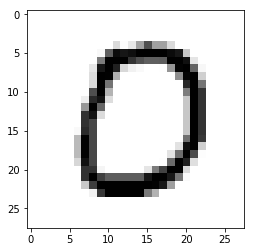

In [10]:
# Evaluate a sample image and display it
import matplotlib.pyplot as plt
from tensorflow.contrib import predictor

%matplotlib inline

image = eval_data[10].reshape(1,28,28,1)

predict_fn = predictor.from_saved_model(export_dir)
predictions = predict_fn(
    {"x": image})

print("Number: ", predictions['classes'][0])

# To interpret the values as a 28x28 image, we need to reshape
# the numpy array, which is one dimensional.
plt.imshow(image.reshape(28, 28), cmap=plt.cm.Greys);

In [11]:
!chmod -R 777 logdir-big